In [1]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from implementations import *
%load_ext autoreload
%autoreload 2

In [2]:
def standardize(tx):
    mean = np.mean(tx, axis=0)
    std = np.std(tx, axis=0)
    tx = (tx-mean)/std
    return tx

# function that add new features 
def build_poly(x, degree):
    """polynomial basis functions for input data x, for j=0 up to j=degree."""
    phi=np.zeros((x.shape[0],degree*x.shape[1]))
    for j in range(degree):
            phi[:,j*x.shape[1]:(j+1)*x.shape[1]]=x**(j+1)
    phi = np.hstack(( np.ones((phi.shape[0], 1), dtype=phi.dtype),phi))
    return phi 


def build_k_indices(y, k_fold, seed):
    """build k indices for k-fold."""
    num_row = y.shape[0]
    interval = int(num_row / k_fold)
    np.random.seed(seed)
    indices = np.random.permutation(num_row)
    k_indices = [indices[k * interval: (k + 1) * interval]
                 for k in range(k_fold)]
    return np.array(k_indices)
def cross_validation_LS(y, x, k_fold, initial_w, max_iters,seed='1'):
    """for Least squares"""
    loss_tr = [] 
    loss_te = []
    ws = []
    k_indices = build_k_indices(y, k_fold, seed)
    for k in range(k_fold):
        # ***************************************************
        # get k'th subgroup in test, others in train
        # ***************************************************
        idx_tr = (np.delete(k_indices, k, 0)).flatten()
        idx_te = k_indices[k]
        x_tr, y_tr = x[idx_tr], y[idx_tr]
        x_te, y_te = x[idx_te], y[idx_te]
        # ***************************************************
        # calculate the loss for train and test data
        # ***************************************************
        w, loss = least_squares(y_tr, x_tr)
        # RMSE
        loss_tr.append(np.sqrt(2*loss))
        loss_te.append(np.sqrt(2*MSE(y_te, x_te, w)))
        ws.append(w)
    var_tr = np.var(loss_tr)
    var_te = np.var(loss_te)
    loss_tr = np.mean(loss_tr)
    loss_te = np.mean(loss_te)
    ws = np.mean(np.asarray(ws), axis=0)
    return loss_tr, loss_te, var_tr, var_te, ws

def cross_validation_LR(y, x, k_fold, initial_w, max_iters, gamma, seed=1):
    """return the loss of ridge regression."""
    loss_tr = [] 
    loss_te = []
    ws = []
    k_indices = build_k_indices(y, k_fold, seed)
    for k in range(k_fold):
        # ***************************************************
        # get k'th subgroup in test, others in train
        # ***************************************************
        idx_tr = (np.delete(k_indices, k, 0)).flatten()
        idx_te = k_indices[k]
        x_tr, y_tr = x[idx_tr], y[idx_tr]
        x_te, y_te = x[idx_te], y[idx_te]
        # ***************************************************
        # calculate the loss for train and test data
        # ***************************************************
        w, loss = logistic_regression(y_tr, x_tr, initial_w, max_iters, gamma)
        loss_tr.append(loss)
        loss_te.append(logistic_loss(y_te, x_te, w))
        ws.append(w)
    var_tr = np.var(loss_tr)
    var_te = np.var(loss_te)
    loss_tr = np.mean(loss_tr)
    loss_te = np.mean(loss_te)
    ws = np.mean(np.asarray(ws), axis=0)
    return loss_tr, loss_te, var_tr, var_te, ws


def cross_validation_RLR(y, x, k_fold, lambda_, initial_w, max_iters, gamma, seed=1):
    """return the loss of ridge regression."""
    loss_tr = [] 
    loss_te = []
    ws = []
    k_indices = build_k_indices(y, k_fold, seed)
    for k in range(k_fold):
        # ***************************************************
        # get k'th subgroup in test, others in train
        # ***************************************************
        idx_tr = (np.delete(k_indices, k, 0)).flatten()
        idx_te = k_indices[k]
        x_tr, y_tr = x[idx_tr], y[idx_tr]
        x_te, y_te = x[idx_te], y[idx_te]
        # ***************************************************
        # calculate the loss for train and test data
        # ***************************************************
        w, loss = reg_logistic_regression(y_tr, x_tr, lambda_, initial_w, max_iters, gamma)
        loss_tr.append(loss)
        loss_te.append(logistic_loss(y_te, x_te, w) + 0.5*lambda_*w.dot(w))
        ws.append(w)
    var_tr = np.var(loss_tr)
    var_te = np.var(loss_te)
    loss_tr = np.mean(loss_tr)
    loss_te = np.mean(loss_te)
    ws = np.mean(np.asarray(ws), axis=0)
    return loss_tr, loss_te, var_tr, var_te, ws


# First : exploring the data

We'll need to have a look at what the data is, how it is distributed for the different features, and start to get an intuition about what methods might work better for analysis and prediction later.

## Load the training data into feature matrix, class labels, and event ids:

In [3]:
from proj1_helpers import *
DATA_TRAIN_PATH = 'data/train.csv' 
y, tX, ids = load_csv_data(DATA_TRAIN_PATH)

In [4]:
# testing methods work
# initial_w = np.ones(tX.shape[1])
# max_iters = 100
# gamma = 0.1
# lambda_ = 0.1
# print('least_squares_GD')
# print(least_squares_GD(y, tX, initial_w, max_iters, gamma))
# print('least_squares_SGD')
# print(least_squares_SGD(y, tX, initial_w, max_iters, gamma))
# print('least_squares')
# print(least_squares(y, tX))
# print('ridge_regression')
# print(ridge_regression(y, tX, lambda_))
# print('logistic_regression SGD')
# print(logistic_regression(y, tX, initial_w, max_iters, gamma, 'SGD'))
# print('logistic_regression GD')
# print(logistic_regression(y, tX, initial_w, max_iters, gamma, 'GD'))
# print('reg_logistic_regression SGD')
# print(reg_logistic_regression(y, tX, lambda_, initial_w, max_iters, gamma, 'SGD'))
# print('reg_logistic_regression GD')
# # print(reg_logistic_regression(y, tX, lambda_, initial_w, max_iters, gamma, 'GD'))
# print('logistic_regression_newton')
# print(logistic_regression_newton(y[:100], tX[:100], initial_w, max_iters, gamma))
# print('reg_logistic_regression_newton')
# print(reg_logistic_regression_newton(y[:100], tX[:100], lambda_, initial_w, max_iters, gamma))

In [5]:
# remove samples with error values
idx_c = np.all(tX!=-999, axis=1)
y_c = y[idx_c]
tX_c = tX[idx_c]
# regularize
mean = np.mean(tX_c, axis=0)
std = np.std(tX_c, axis=0)
tX_c = (tX_c-mean)/std

Overall: s:  85667 , b:  164333  ,total: 250000
NoErrors: s:  31894 , b:  36220  ,total: 68114


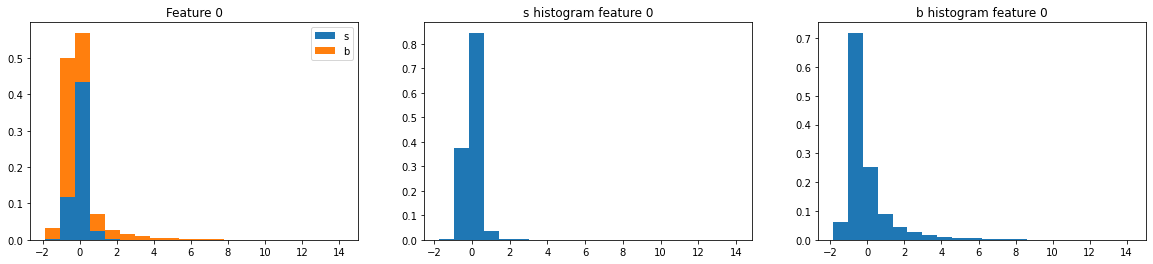

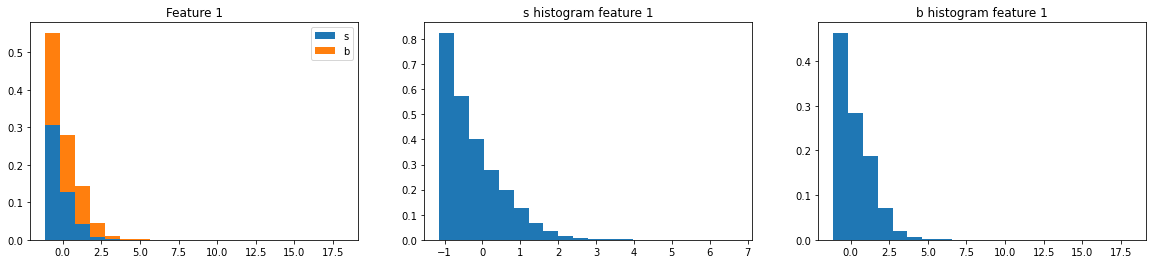

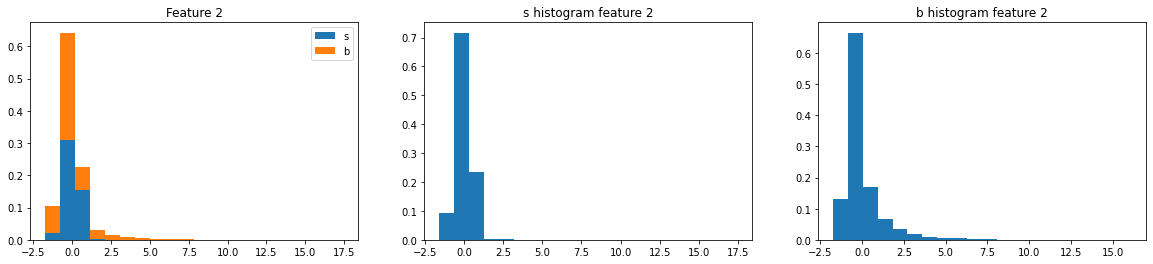

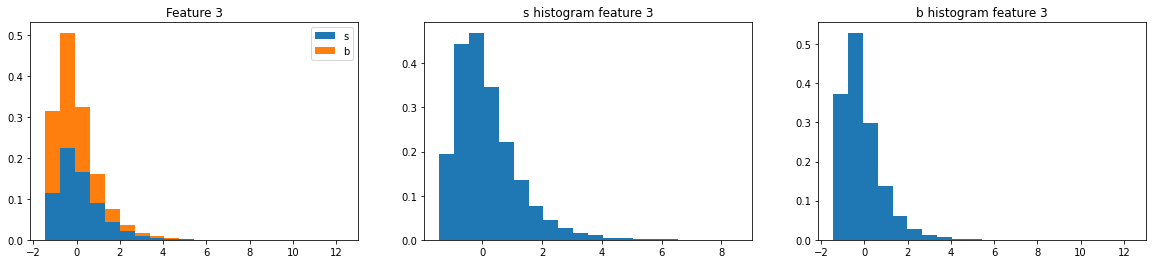

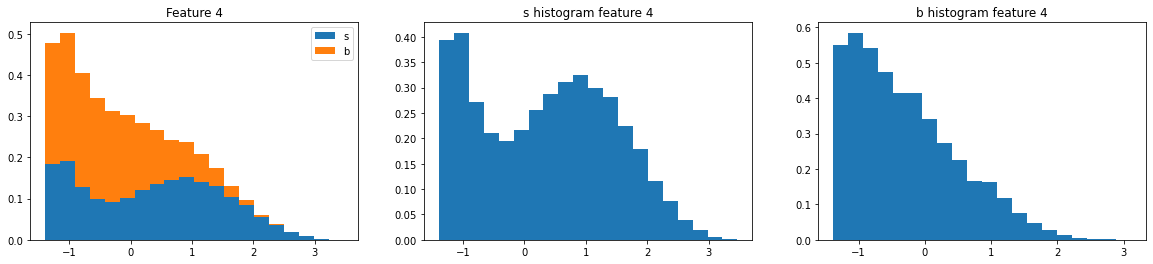

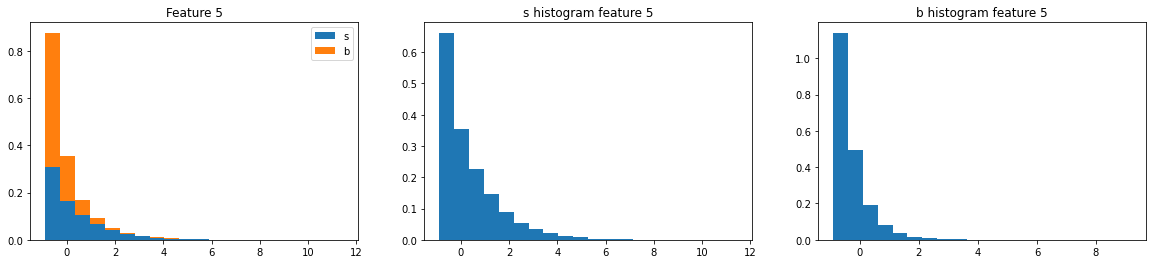

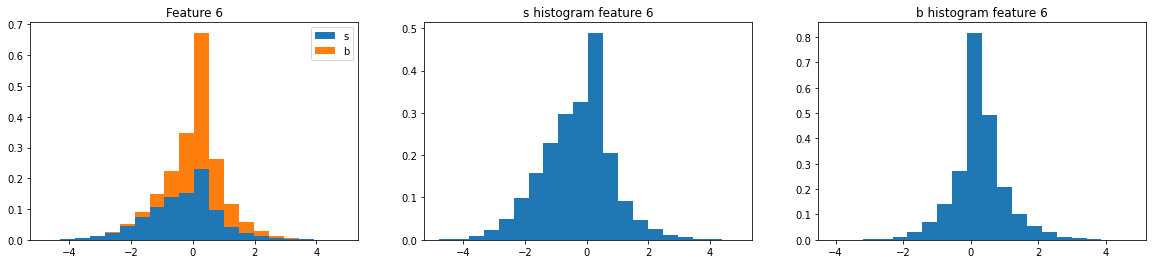

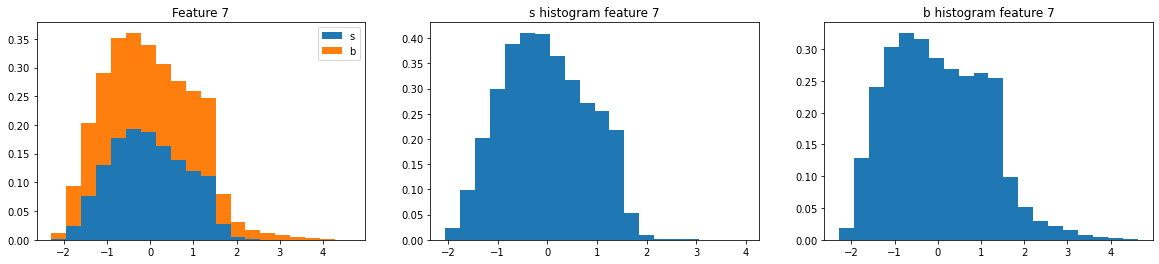

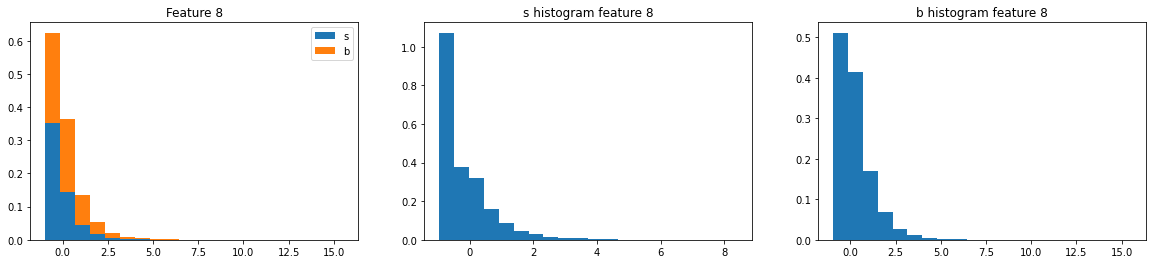

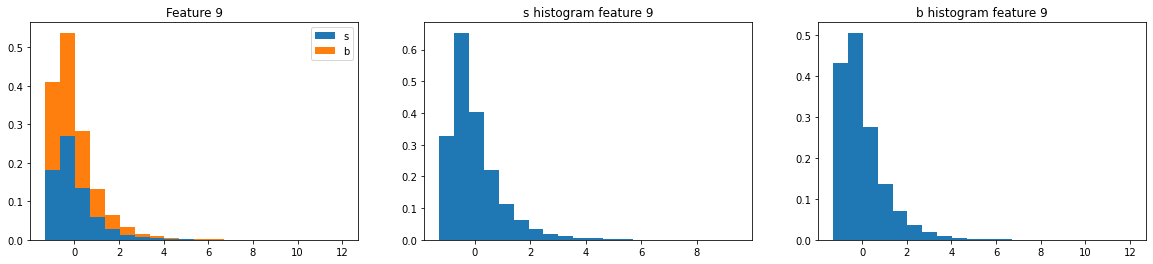

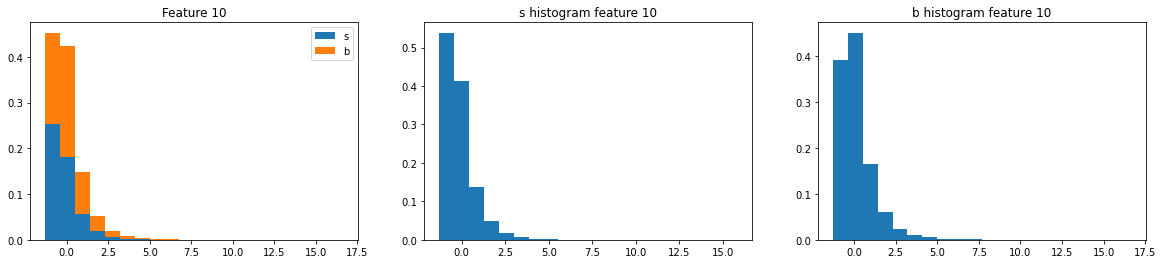

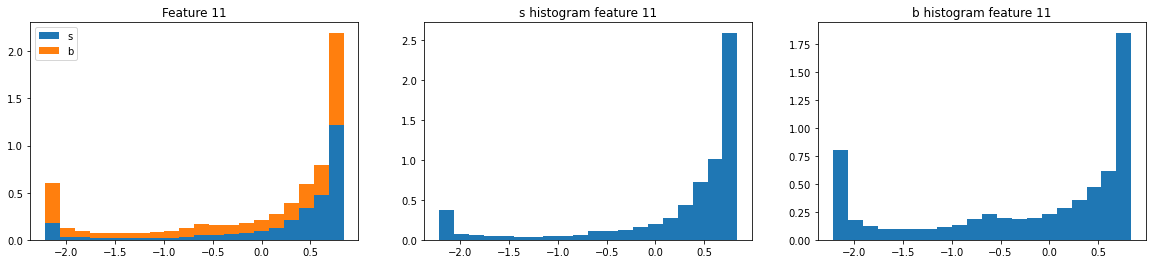

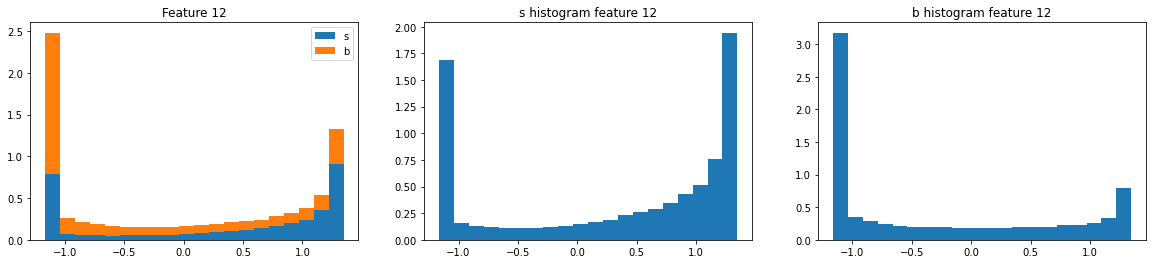

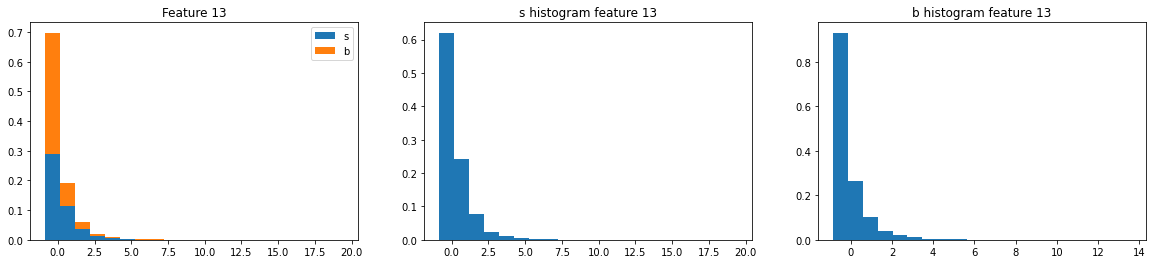

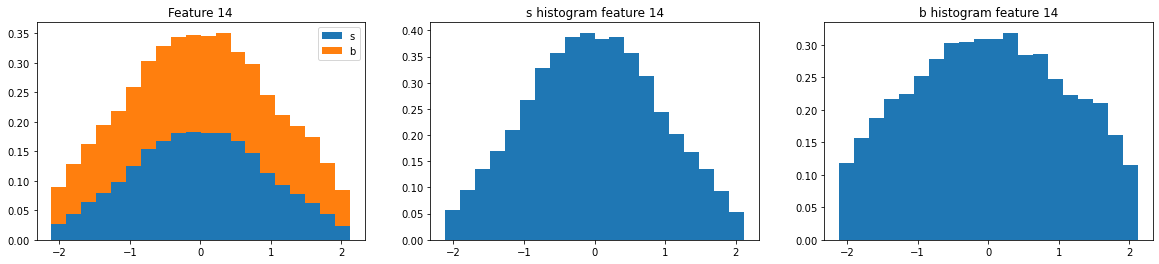

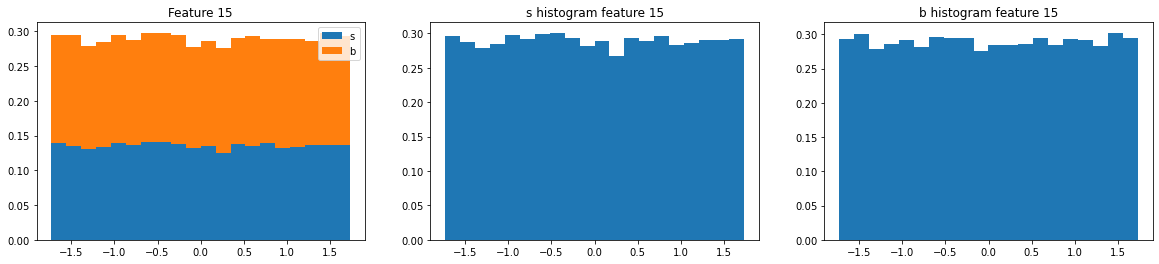

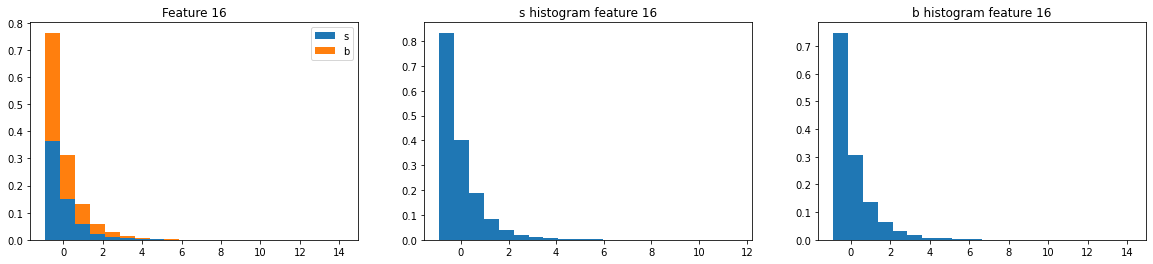

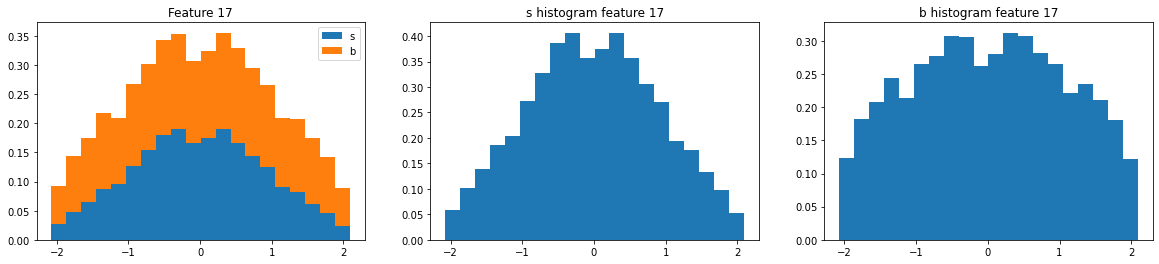

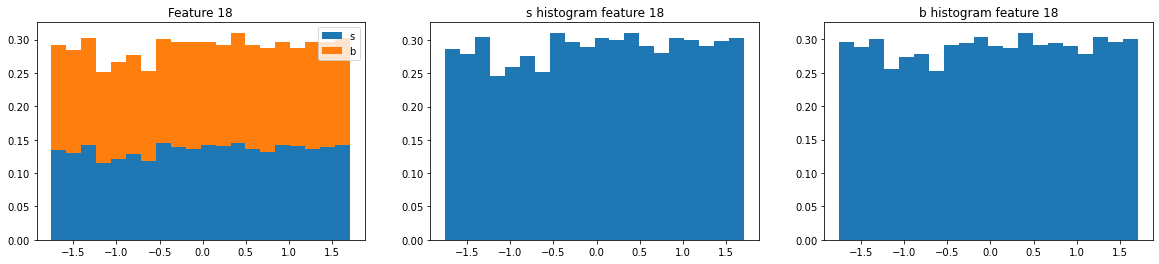

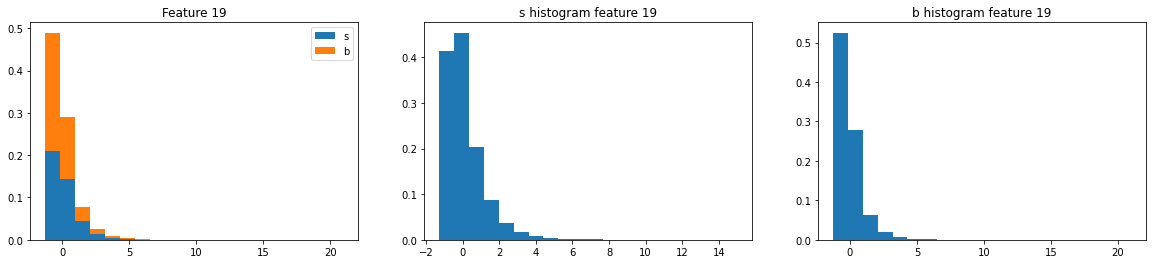

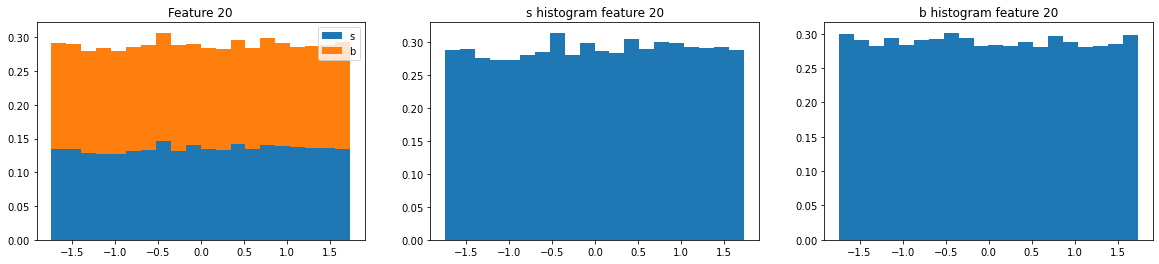

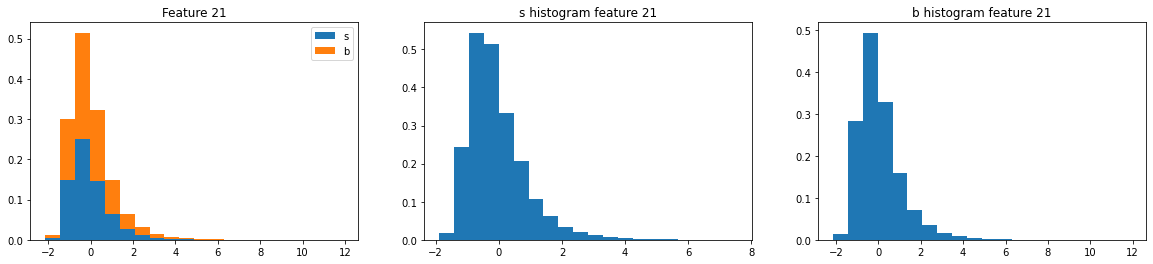

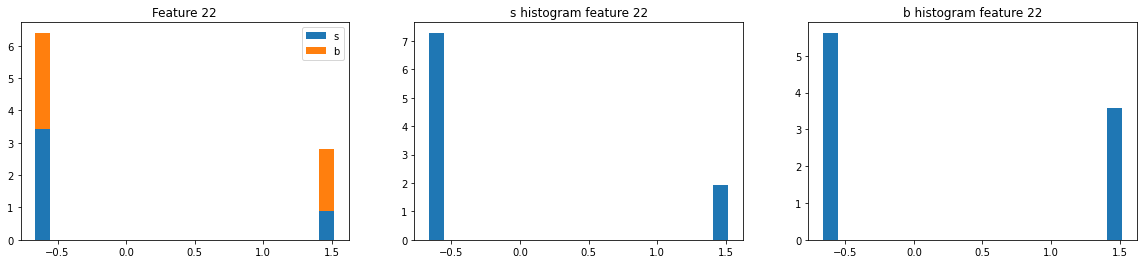

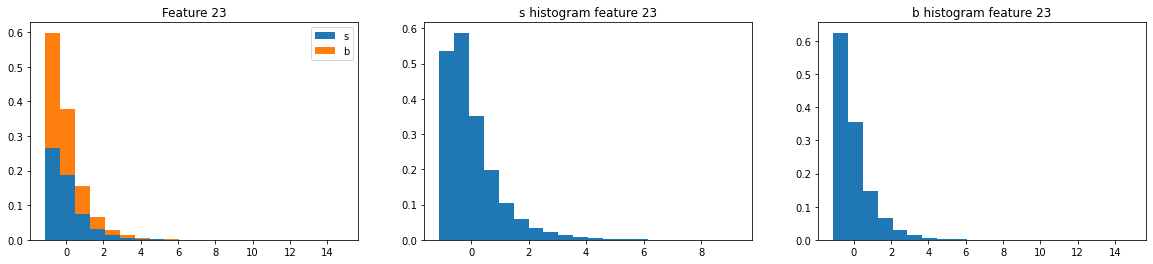

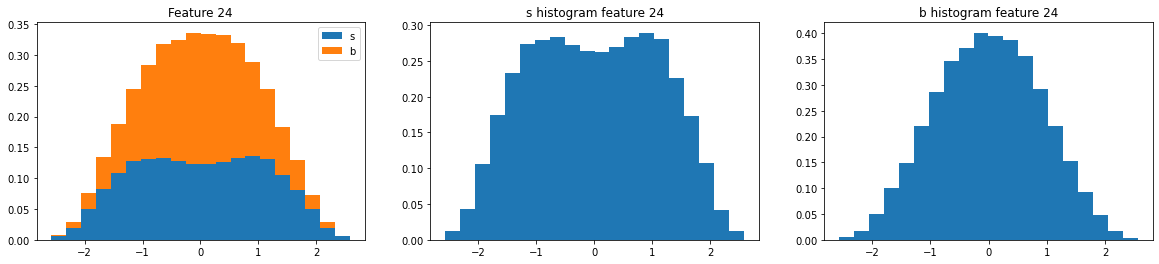

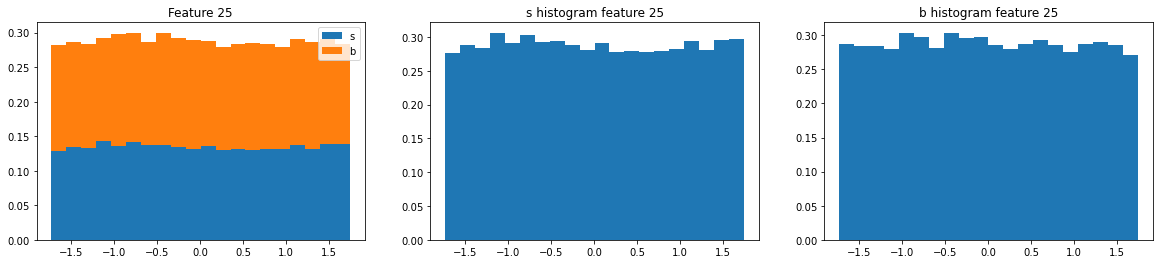

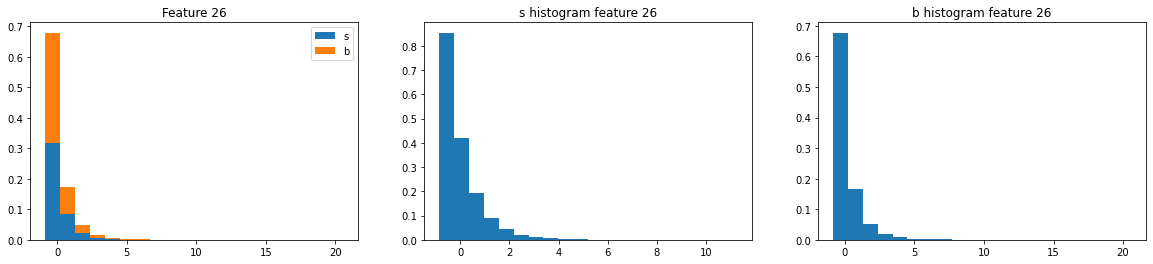

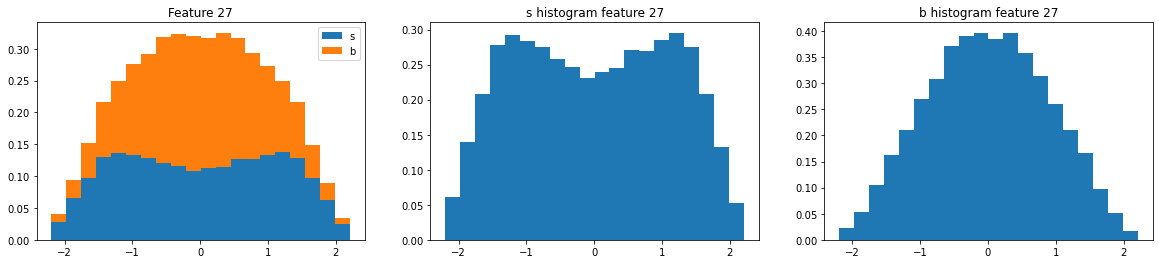

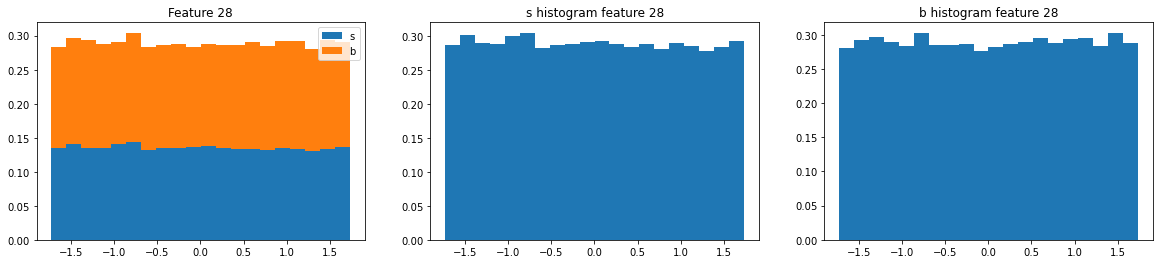

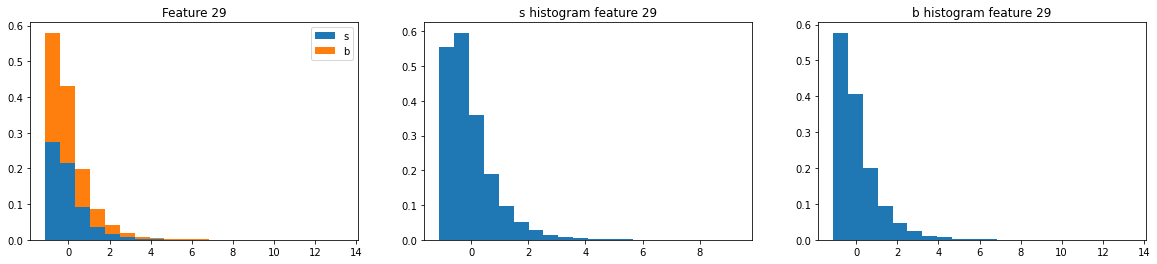

In [6]:
print("Overall: s: ",np.sum(y==1),", b: ",np.sum(y==-1)," ,total:",len(y))
print("NoErrors: s: ",np.sum(y_c==1),", b: ",np.sum(y_c==-1)," ,total:",len(y_c))
for n in range(tX_c.shape[1]):
    plt.figure(figsize=(20,4))
    plt.subplot(131)
    plt.hist([tX_c[y_c==1,n],tX_c[y_c==-1,n]], 20, density=True, histtype='bar', stacked=True)
    plt.legend(['s','b'])
    plt.title('Feature '+str(n))
    plt.subplot(132)
    plt.title('s histogram feature '+str(n))
    plt.hist(tX_c[y_c==1,n], 20, density=True, histtype='bar', stacked=True)
    plt.subplot(133)
    plt.title('b histogram feature '+str(n))
    plt.hist(tX_c[y_c==-1,n], 20, density=True, histtype='bar', stacked=True)    
    plt.show()

In [7]:
# remove features with error values
idx_gf = np.arange(tX.shape[1])[np.all(tX!=-999, axis=0)]
y_gf = y
tX_gf = tX[:,idx_gf]
# regularize
mean = np.mean(tX_gf, axis=0)
std = np.std(tX_gf, axis=0)
tX_gf = (tX_gf-mean)/std

Overall: s:  85667 , b:  164333  ,total: 250000


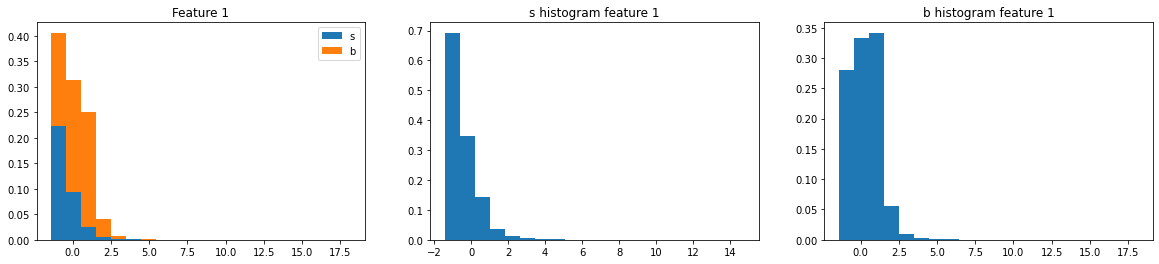

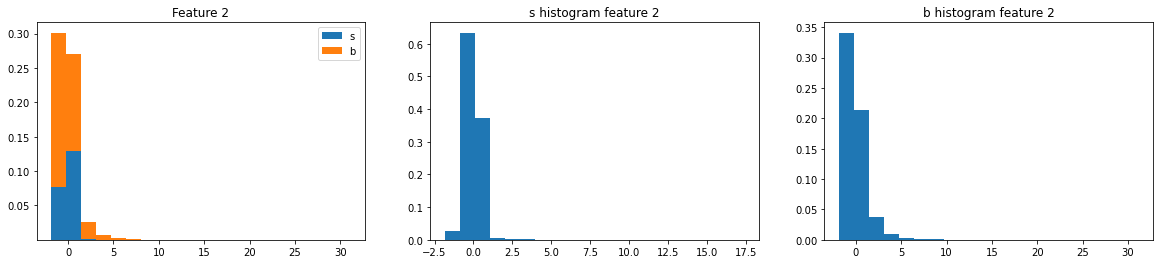

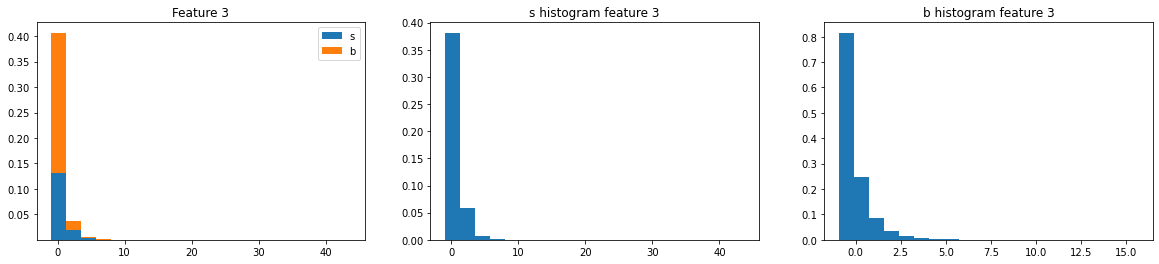

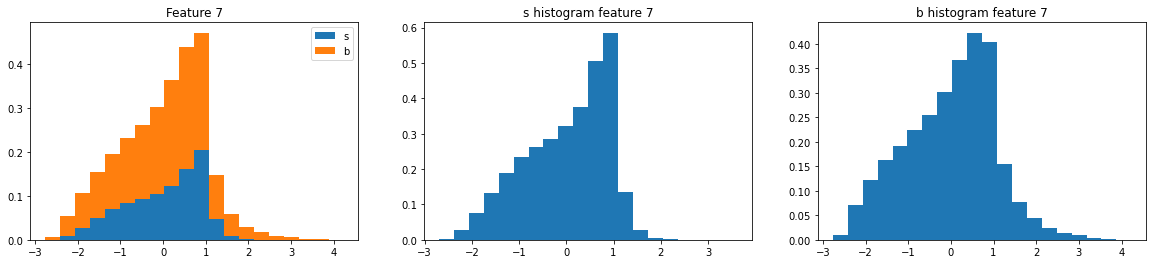

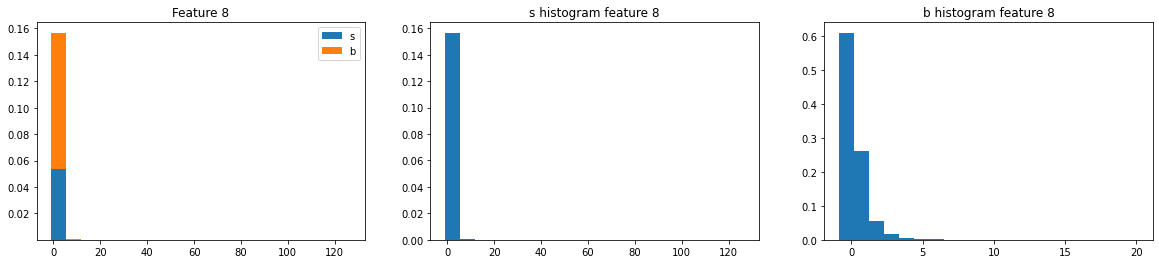

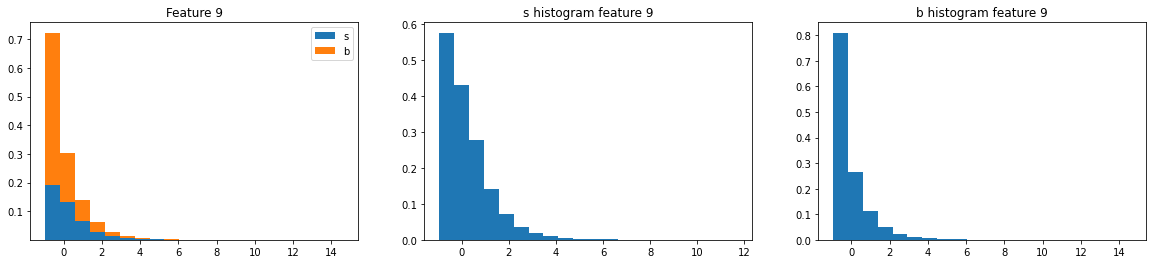

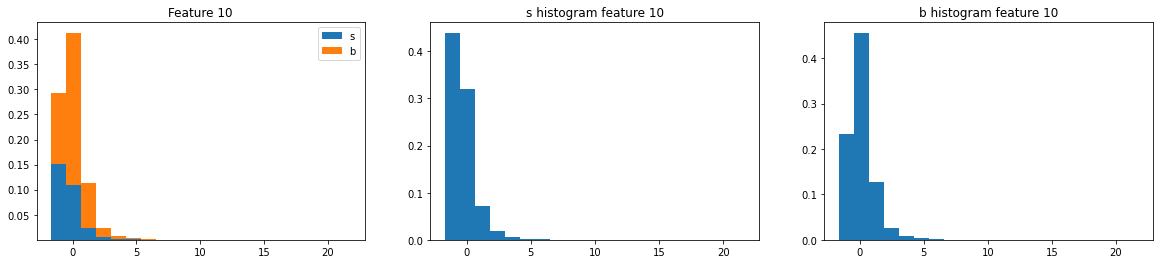

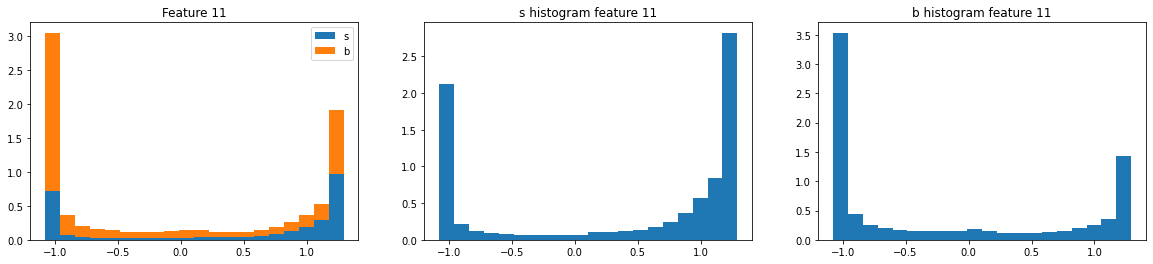

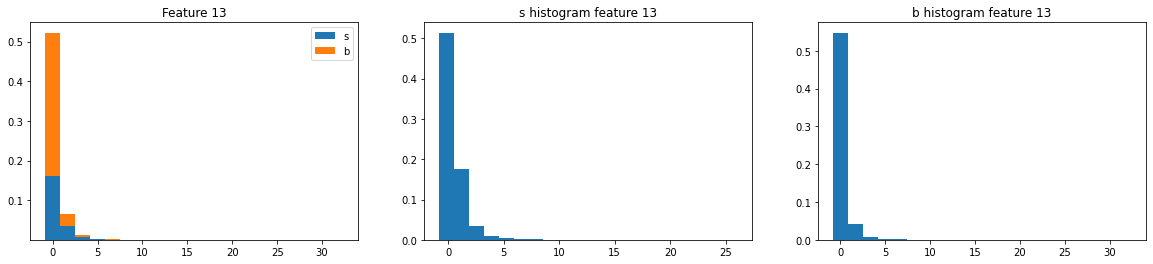

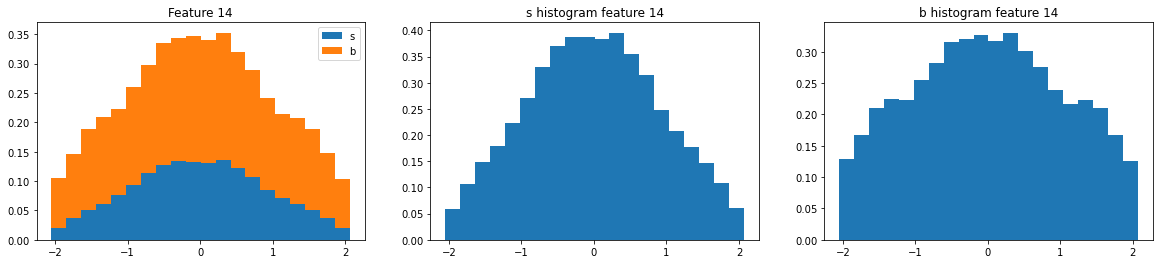

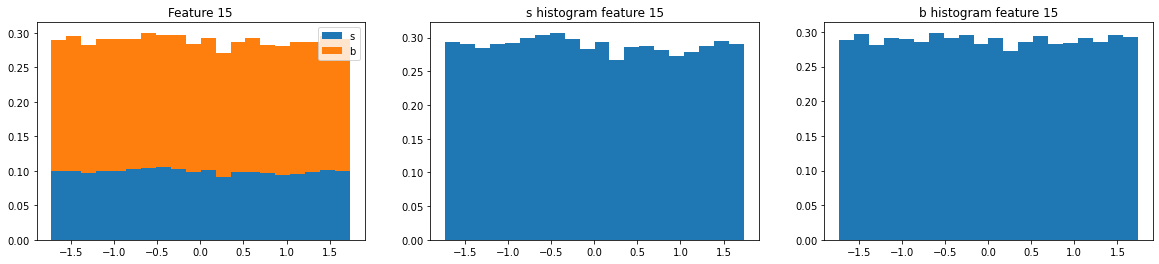

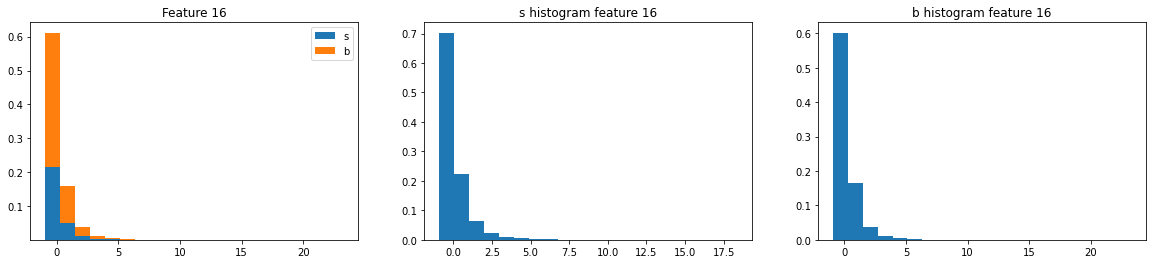

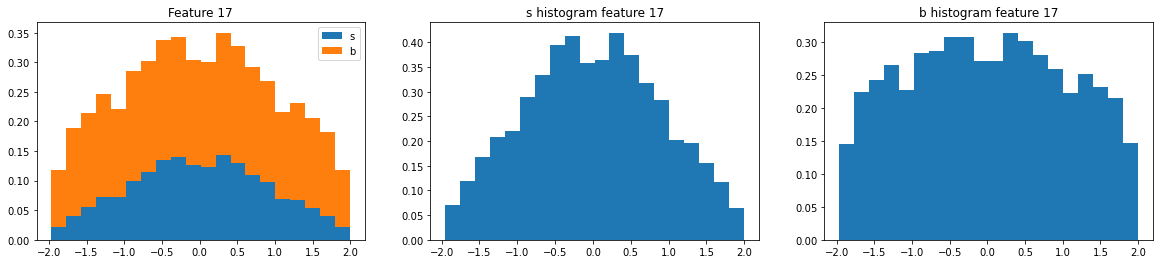

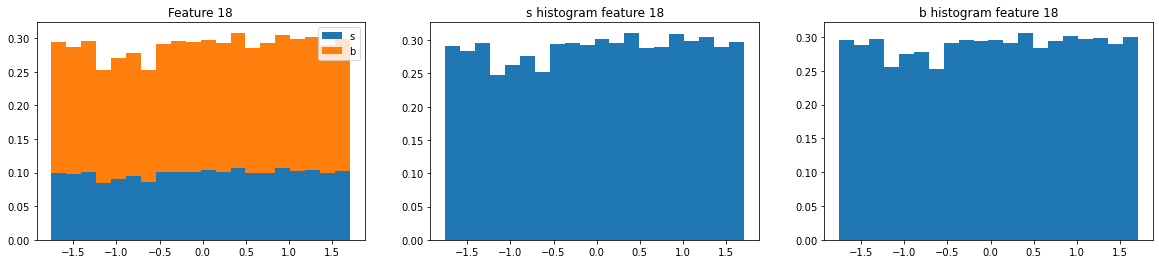

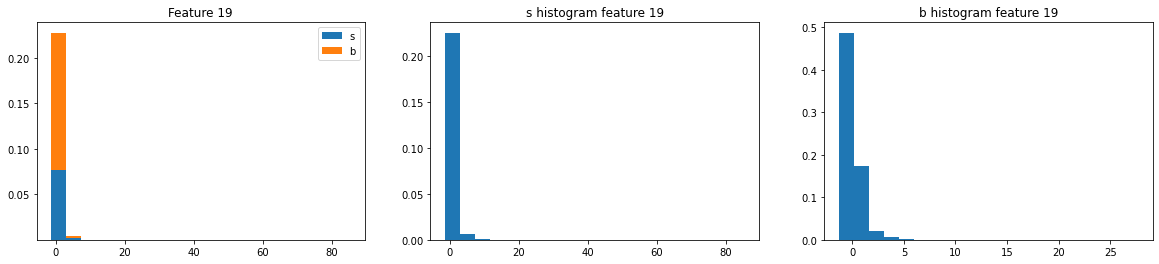

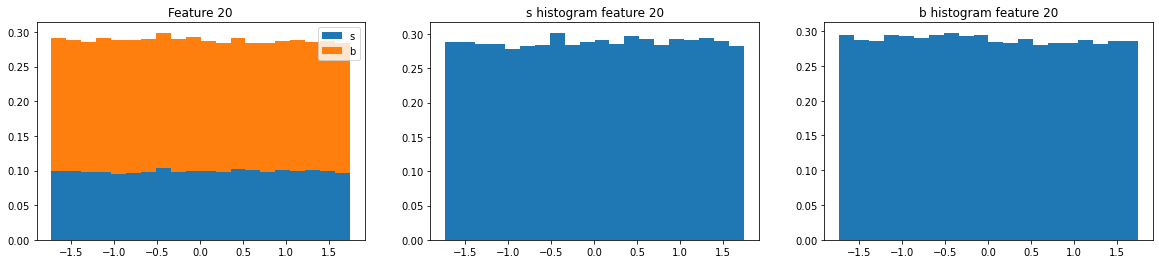

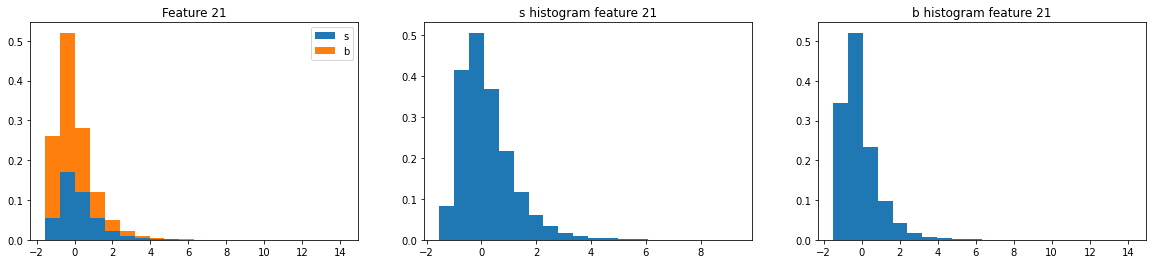

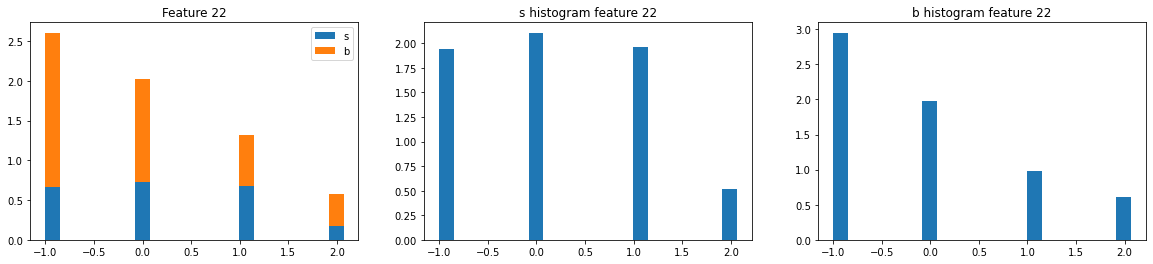

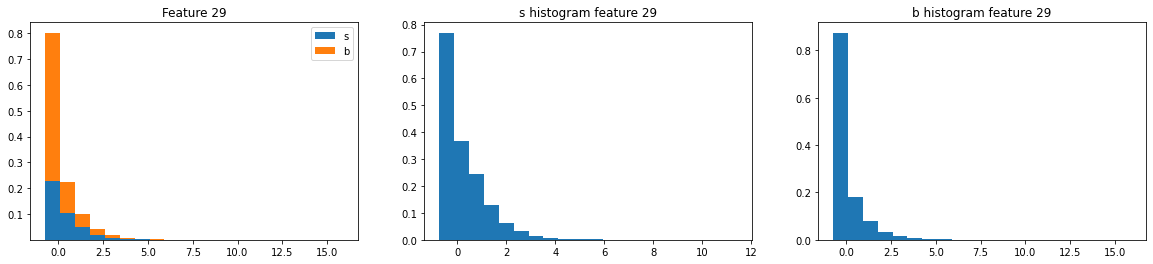

In [8]:
print("Overall: s: ",np.sum(y==1),", b: ",np.sum(y==-1)," ,total:",len(y))
for n in range(tX_gf.shape[1]):
    plt.figure(figsize=(20,4))
    plt.subplot(131)
    plt.hist([tX_gf[y_gf==1,n],tX_gf[y_gf==-1,n]], 20, density=True, histtype='bar', stacked=True)
    plt.legend(['s','b'])
    plt.title('Feature '+str(idx_gf[n]))
    plt.subplot(132)
    plt.title('s histogram feature '+str(idx_gf[n]))
    plt.hist(tX_gf[y_gf==1,n], 20, density=True, histtype='bar', stacked=True)
    plt.subplot(133)
    plt.title('b histogram feature '+str(idx_gf[n]))
    plt.hist(tX_gf[y_gf==-1,n], 20, density=True, histtype='bar', stacked=True)    
    plt.show()

In [9]:
# remove features with error values
y_jet = []
tx_jet = []
y_jet_nm = []
tx_jet_nm = []
# filtering according to undefinition due to jet number
idx_jet_undef = [np.array([0,1,2,3,7,10,11,13,14,15,16,17,18,19,20,21]),
                np.array([0,1,2,3,7,8,9,10,11,13,14,15,16,17,18,19,20,21,23,24,25,29]),
                np.array([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,23,24,25,26,27,28,29]),
                np.array([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,23,24,25,26,27,28,29])]
# Extra filtering according to definition of mass
idx_jet_undef_nm = [np.array([1,2,3,7,10,11,13,14,15,16,17,18,19,20,21]),
                    np.array([1,2,3,7,8,9,10,11,13,14,15,16,17,18,19,20,21,23,24,25,29]),
                    np.array([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,23,24,25,26,27,28,29]),
                    np.array([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,23,24,25,26,27,28,29])]
for jet in range(4):
    idx_jet = tX[:,22]==jet
    y_jet.append(y[idx_jet])
    #tx_jet.append(tX[idx_jet][:,idx_jet_undef[jet]])
    tx_jet.append(standardize(tX[idx_jet][:,idx_jet_undef[jet]]))
for jet in range(4):
    idx_jet = tX[:,22]==jet
    y_jet_nm.append(y[idx_jet])
    #tx_jet_nm.append(tX[idx_jet][:,idx_jet_undef_nm[jet]])
    tx_jet.append(standardize(tX[idx_jet][:,idx_jet_undef_nm[jet]]))

for jet in range(4):
    print('Jet {:} shape is {:}'.format(jet,tx_jet[jet].shape))

Jet 0 shape is (99913, 16)
Jet 1 shape is (77544, 22)
Jet 2 shape is (50379, 29)
Jet 3 shape is (22164, 29)


Overall: s:  85667 , b:  164333  ,total: 250000
Jet 0: s: 25492, b: 74421 ,total: 99913


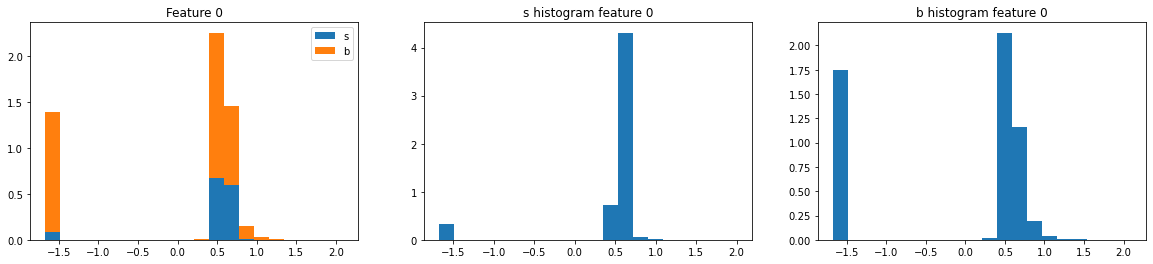

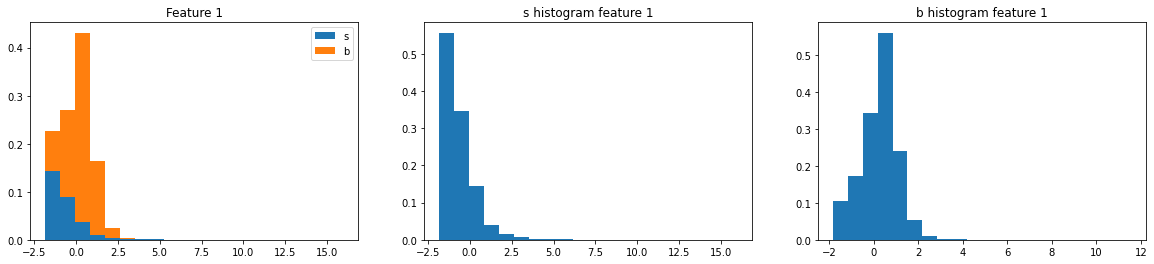

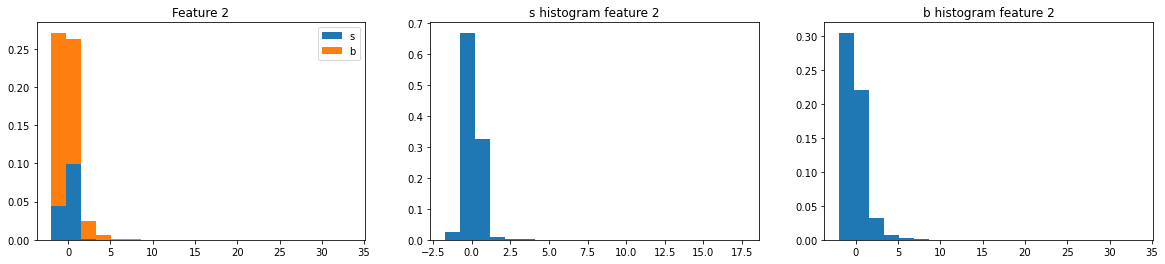

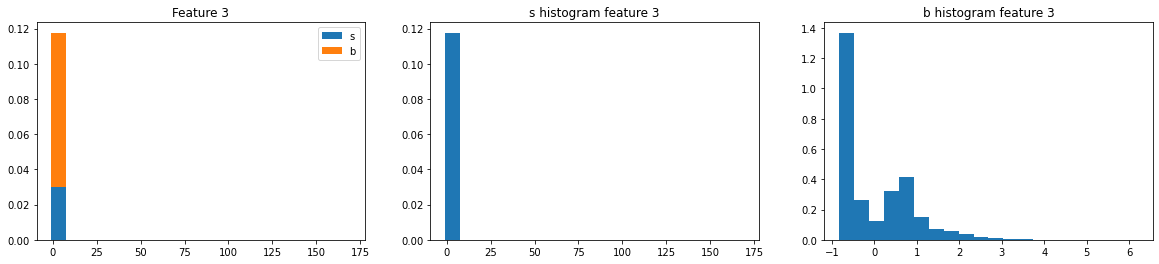

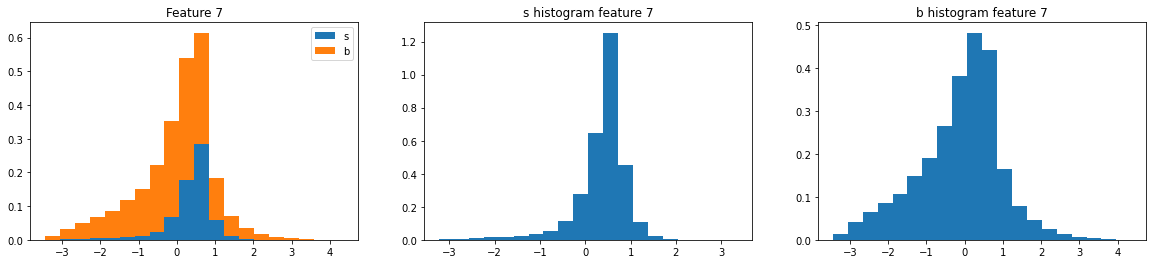

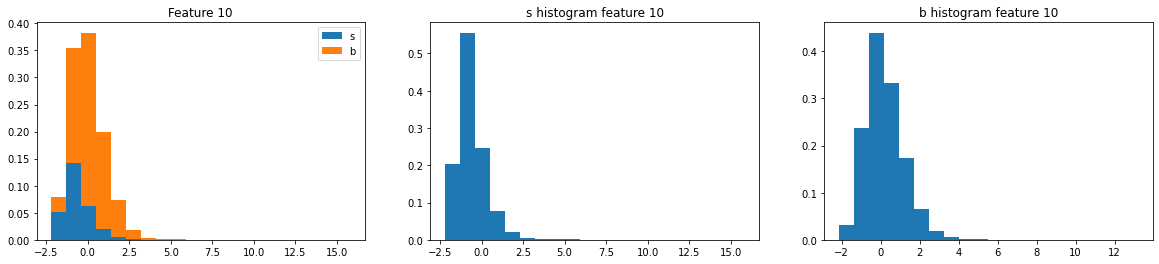

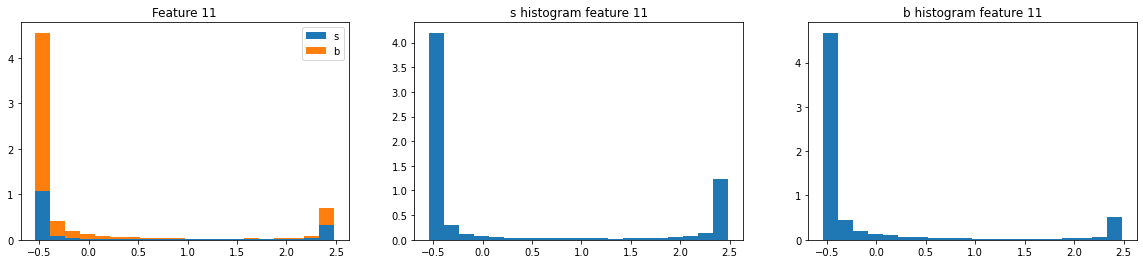

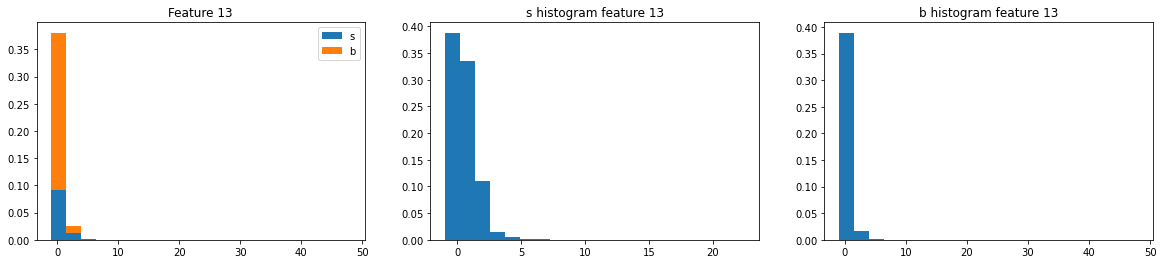

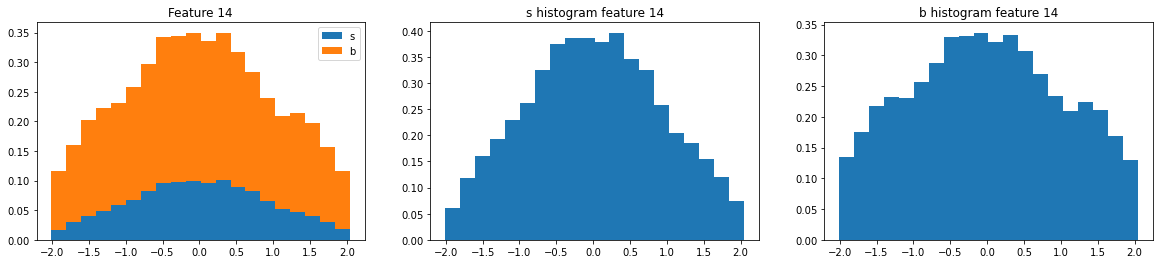

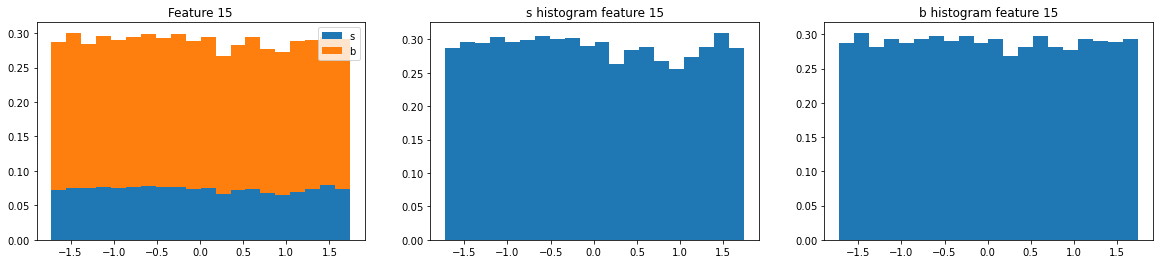

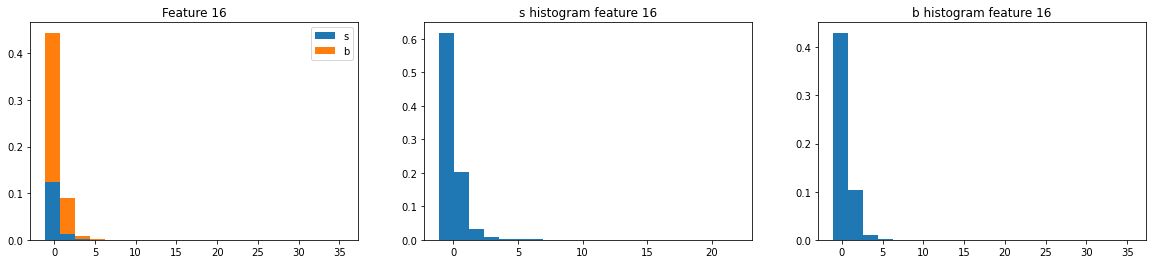

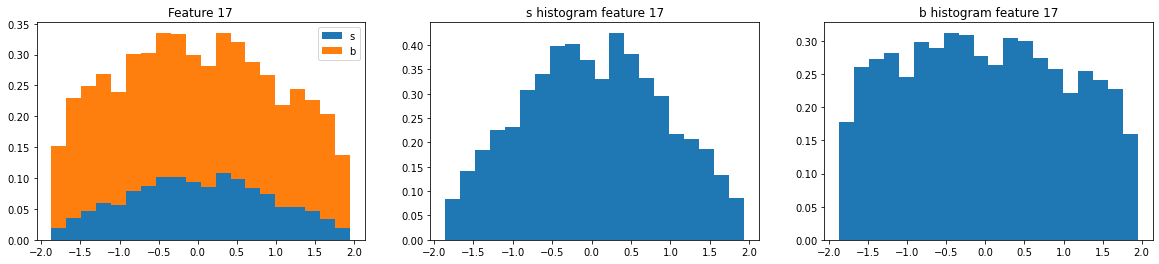

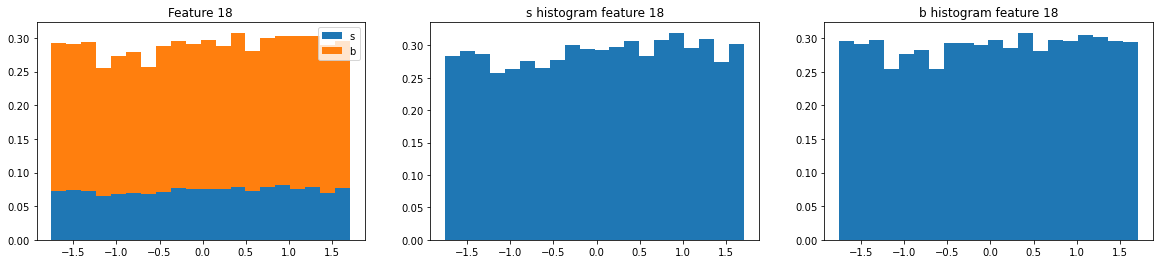

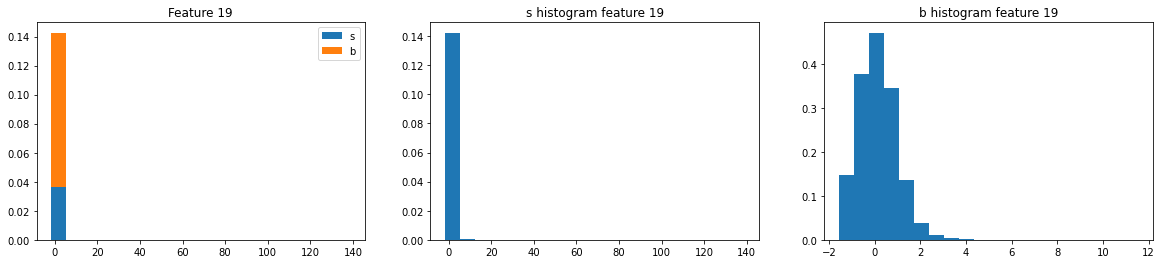

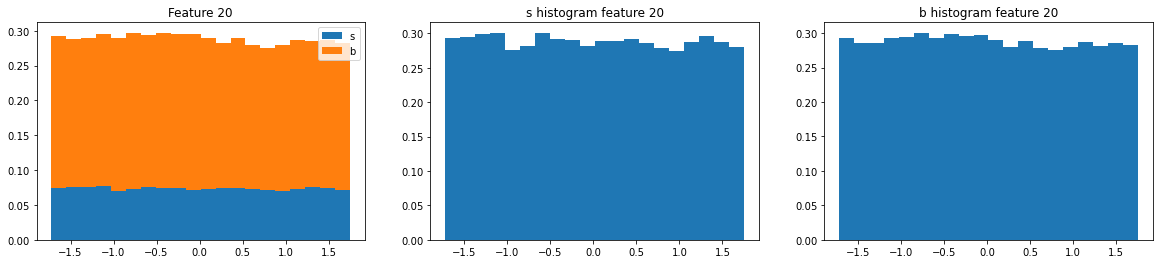

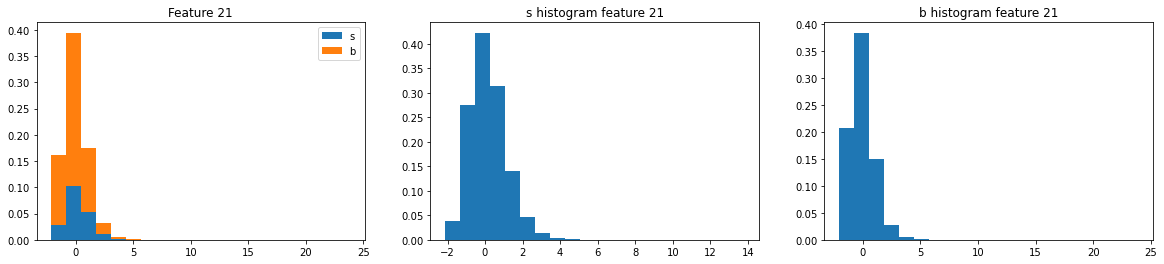

Jet 1: s: 27710, b: 49834 ,total: 77544


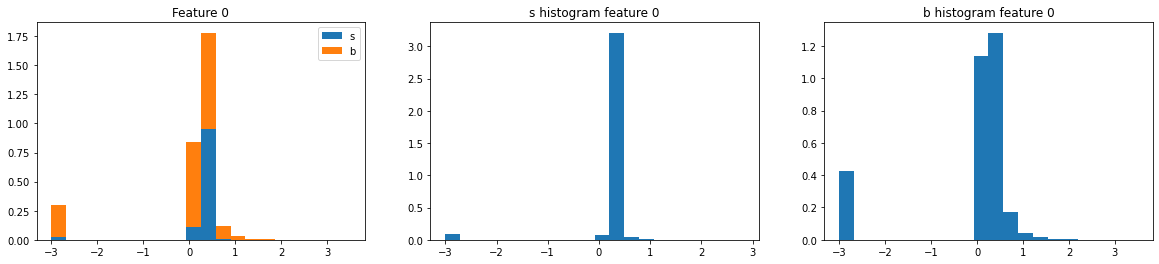

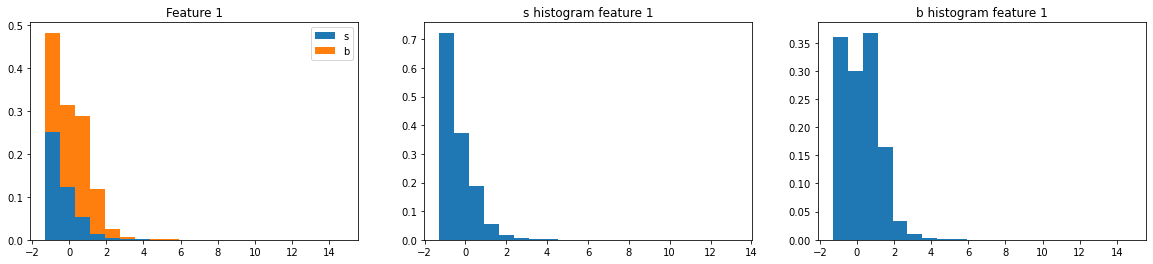

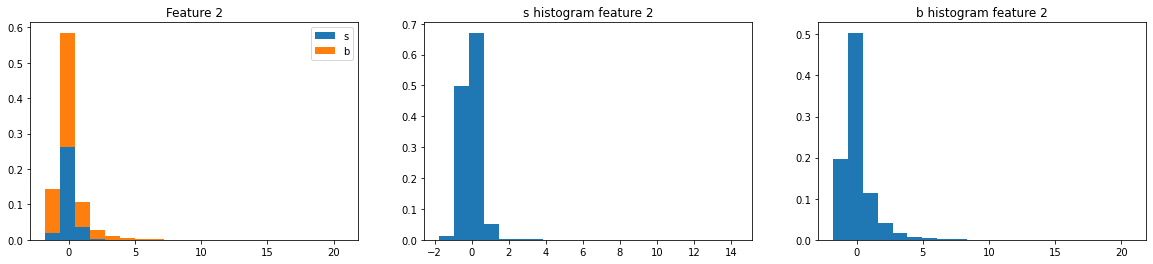

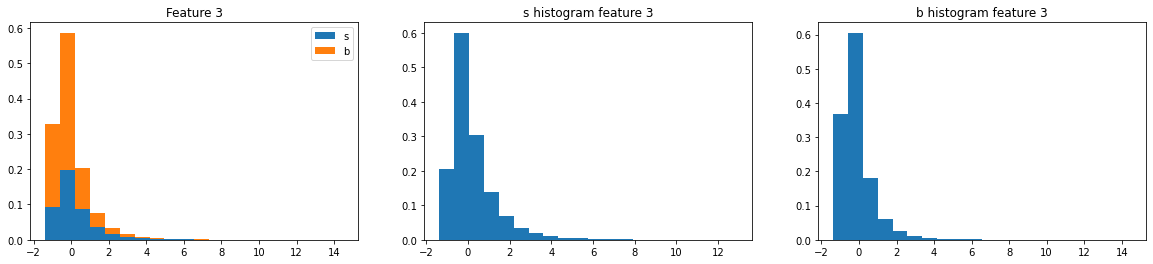

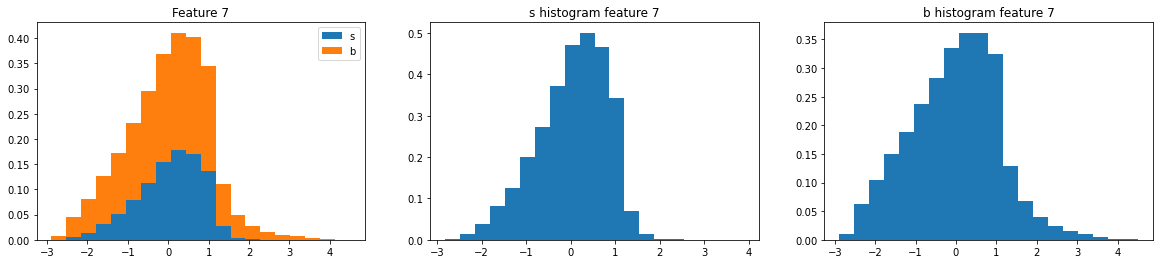

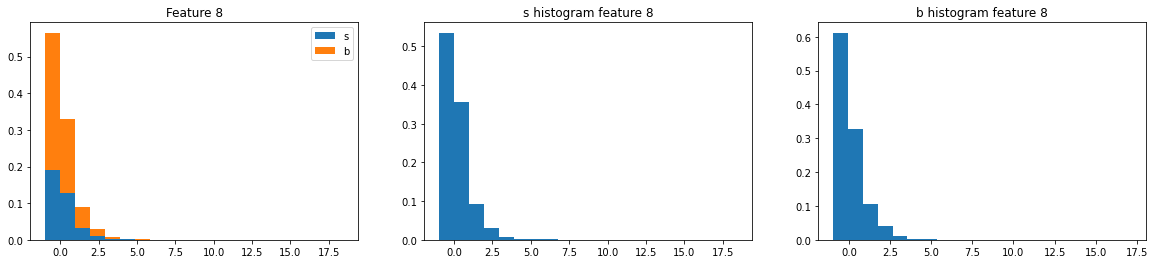

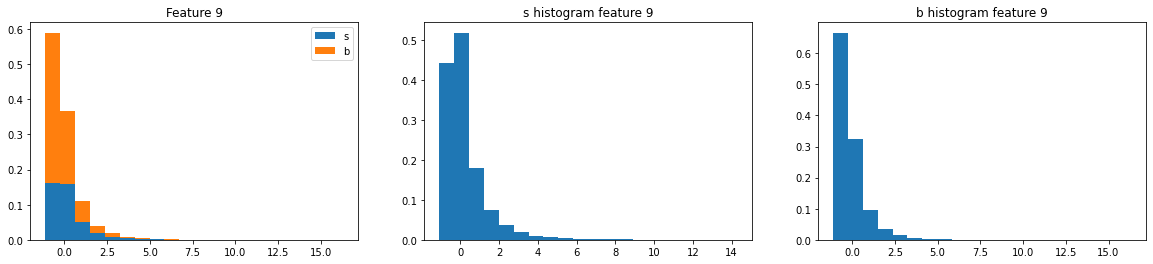

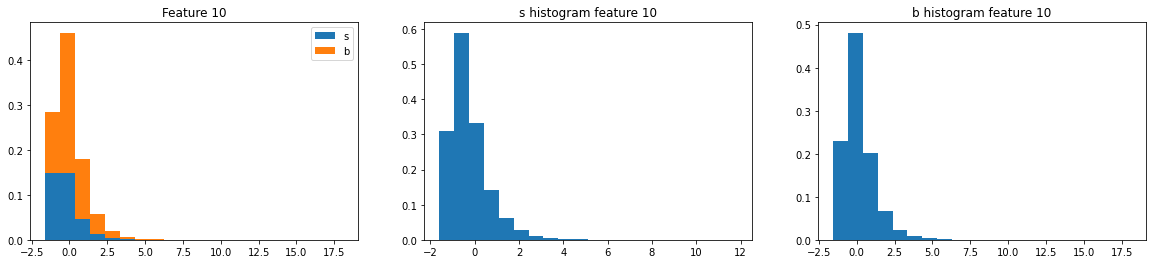

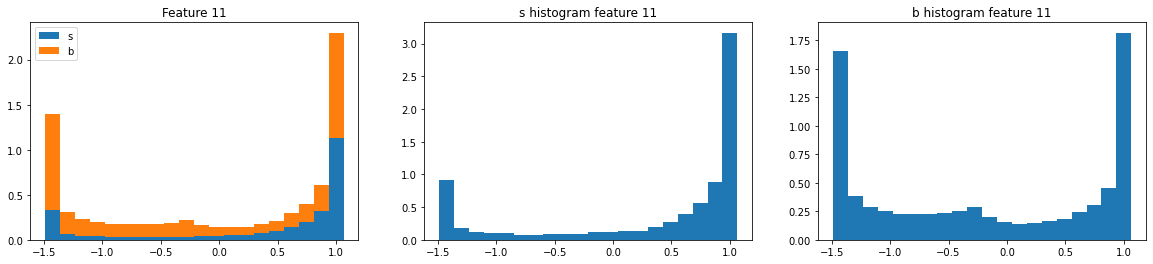

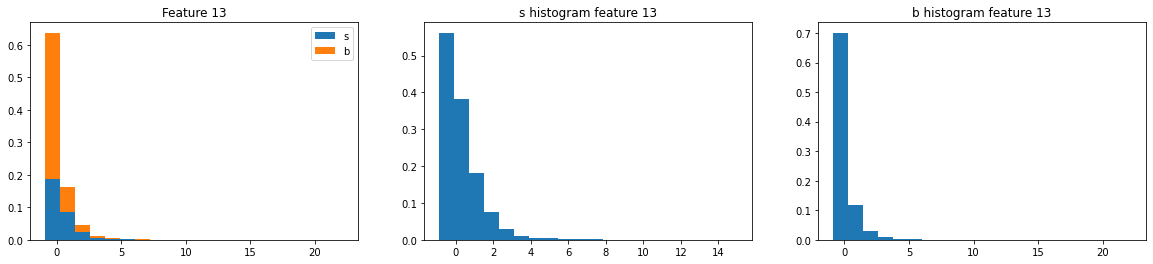

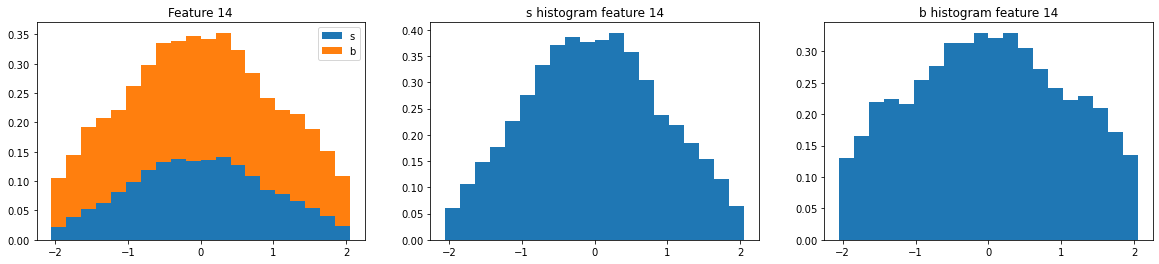

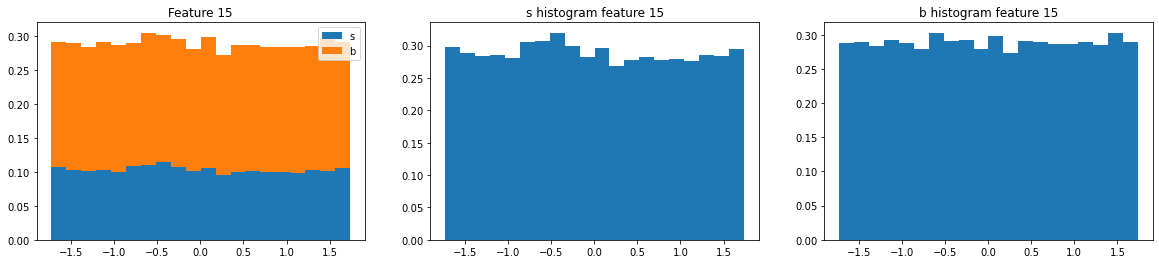

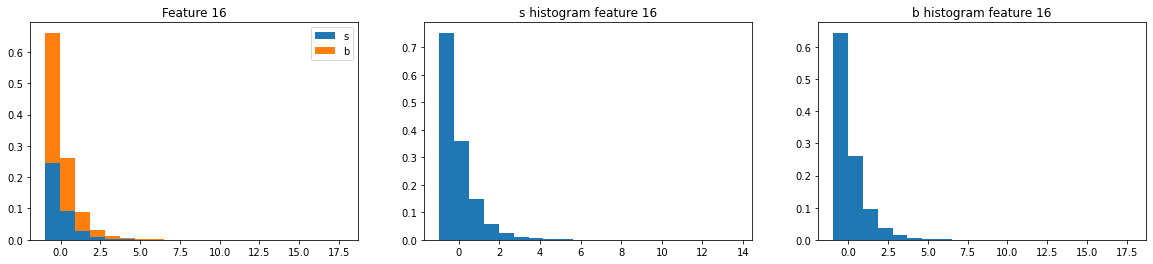

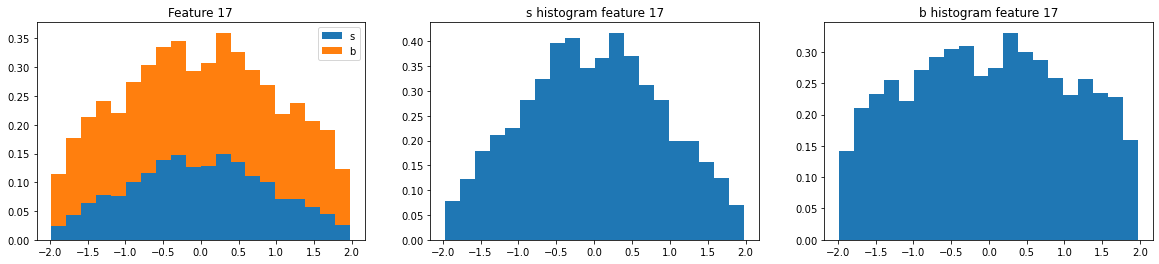

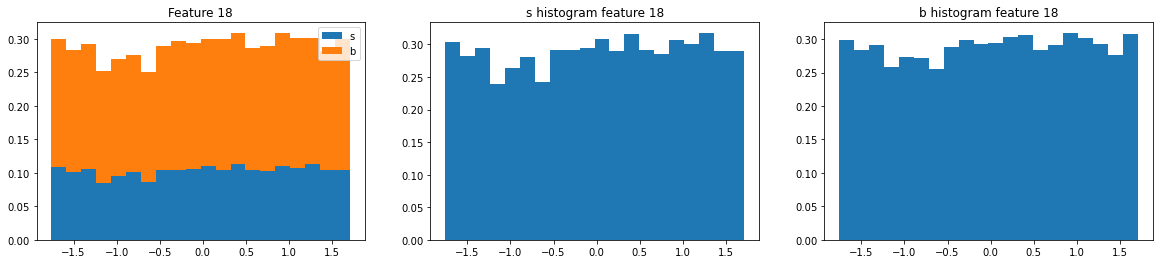

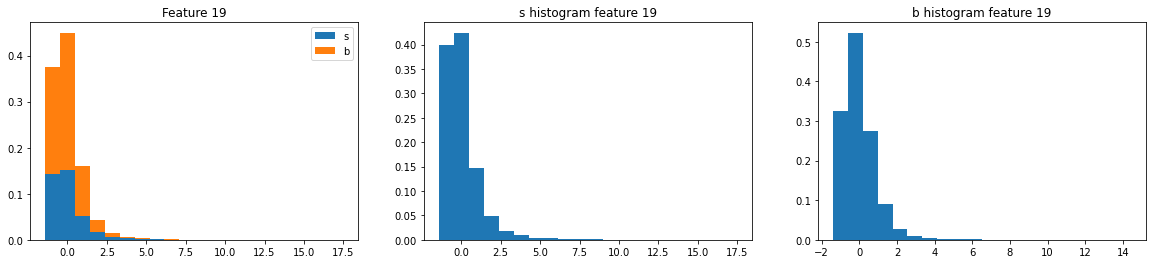

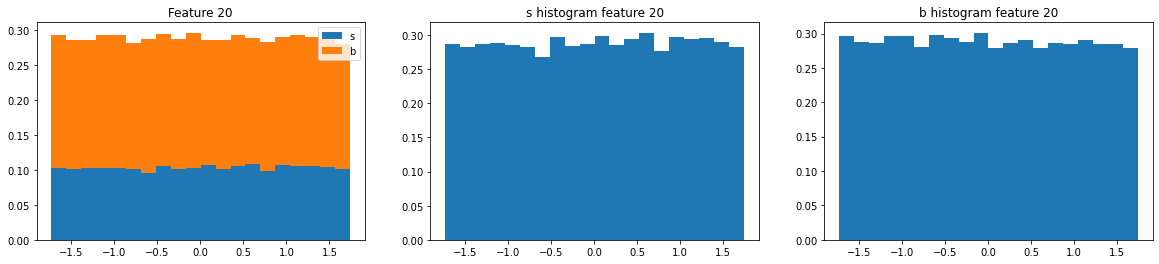

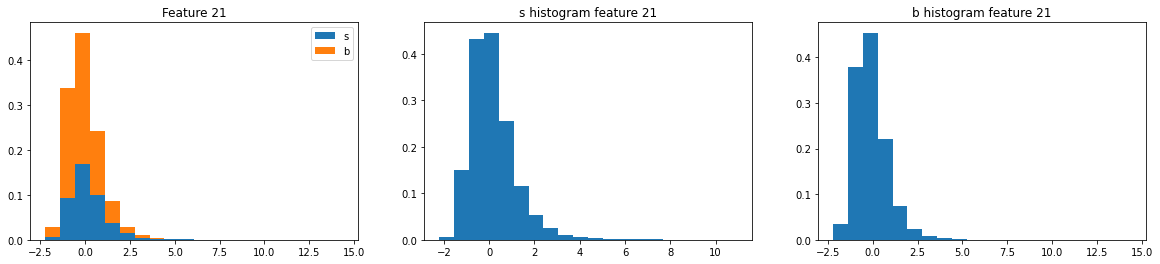

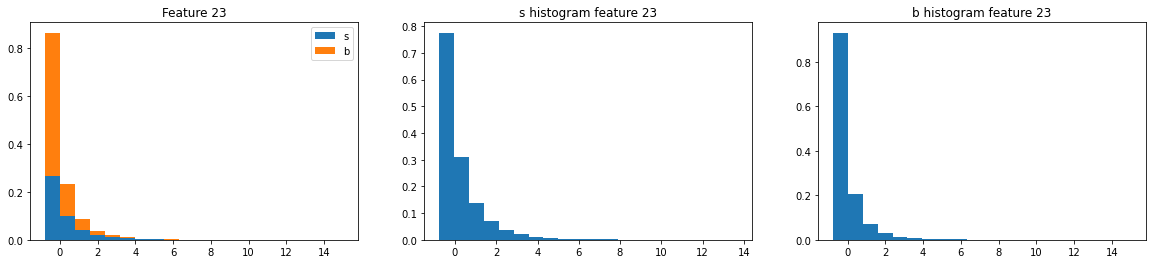

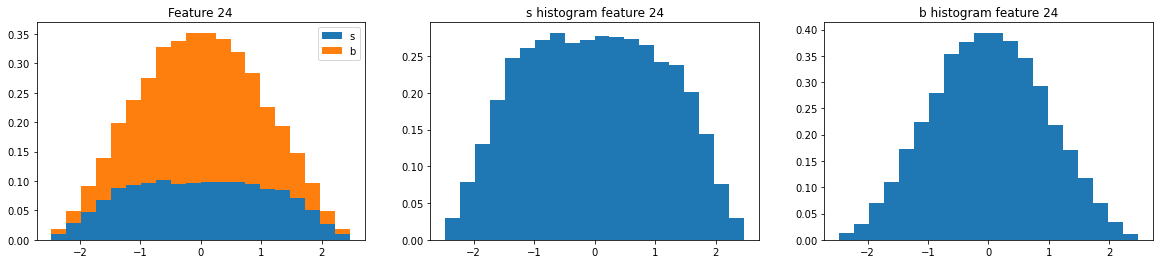

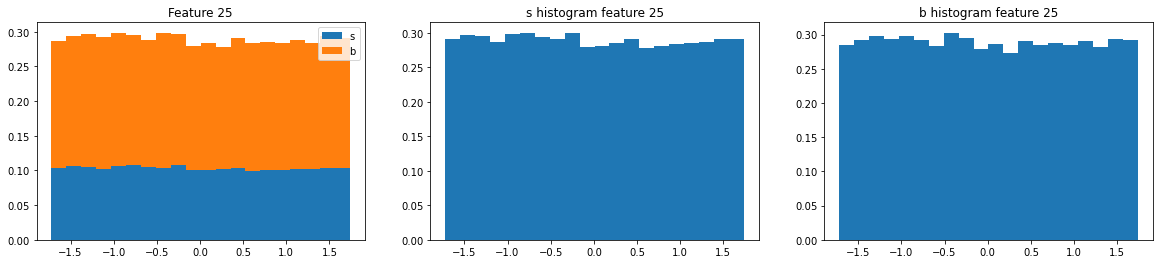

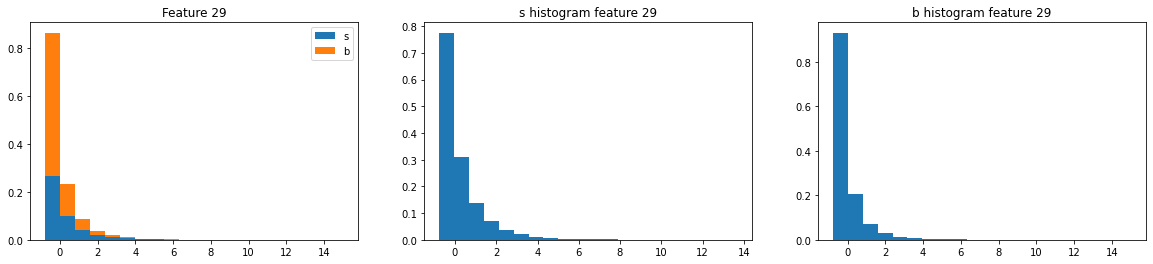

Jet 2: s: 25734, b: 24645 ,total: 50379


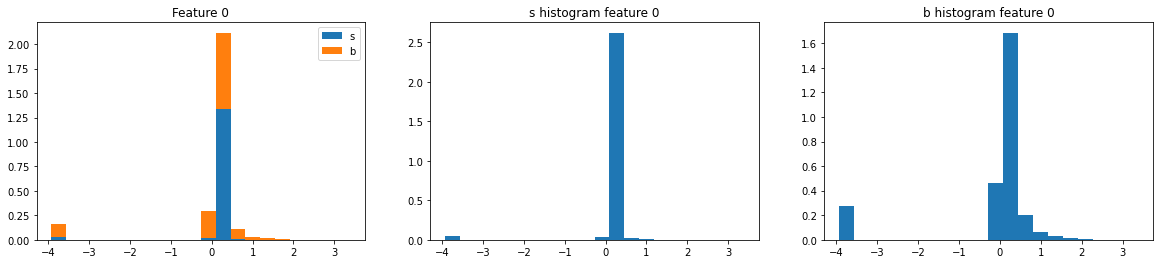

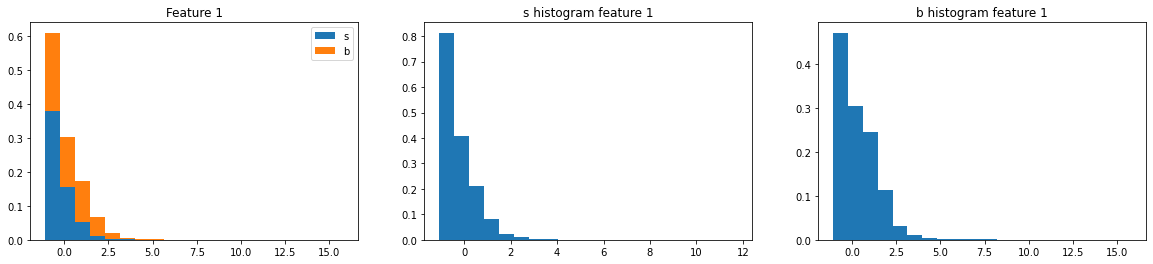

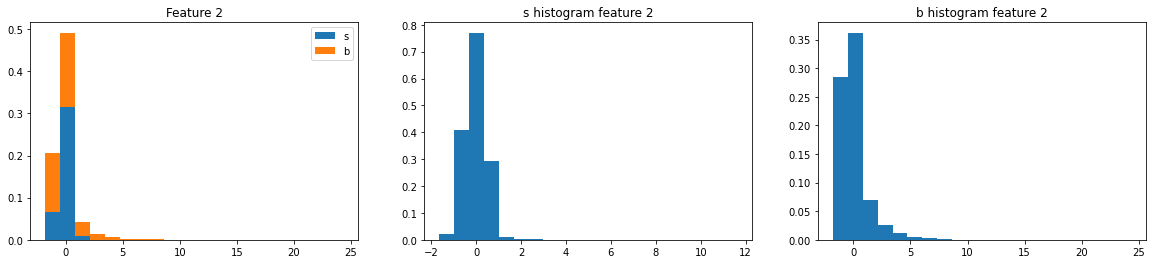

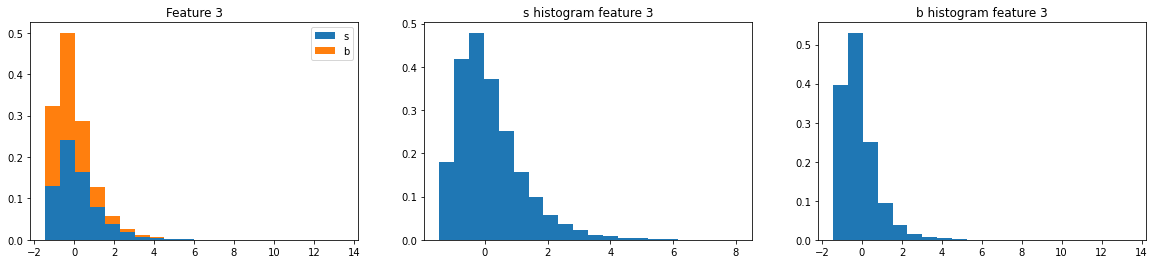

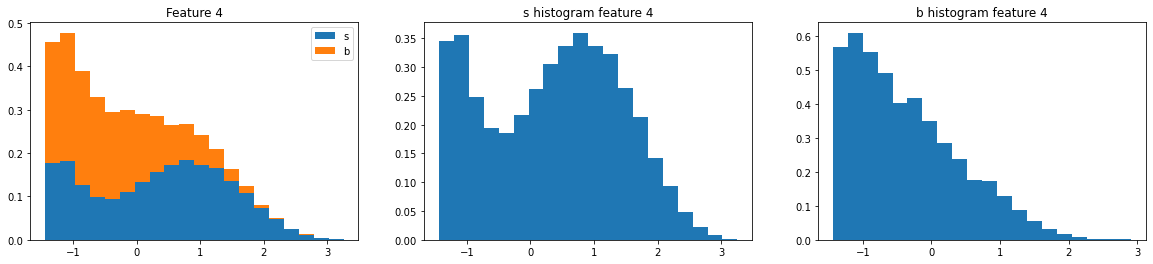

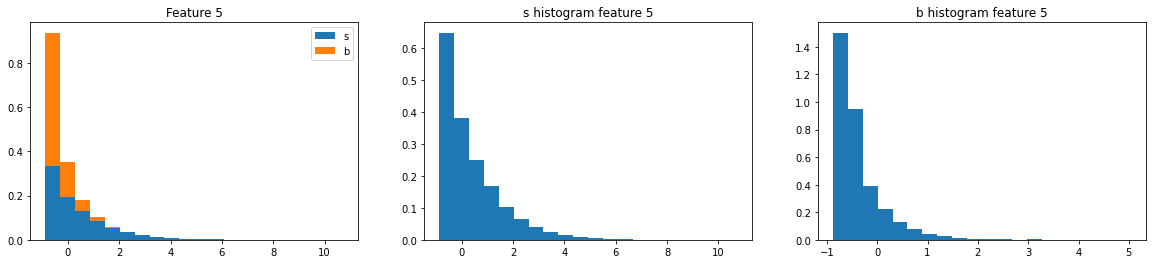

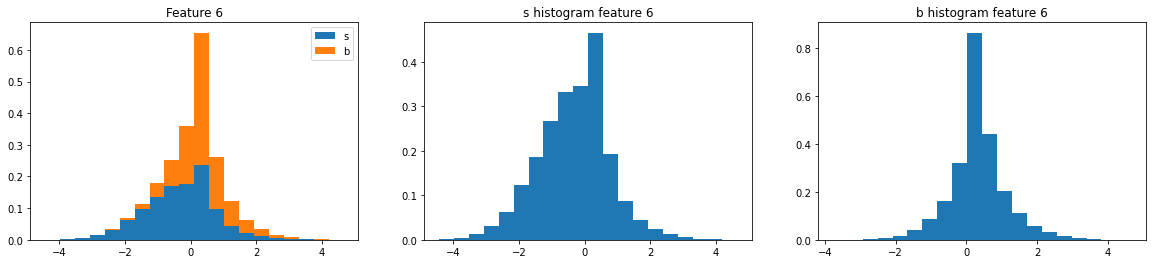

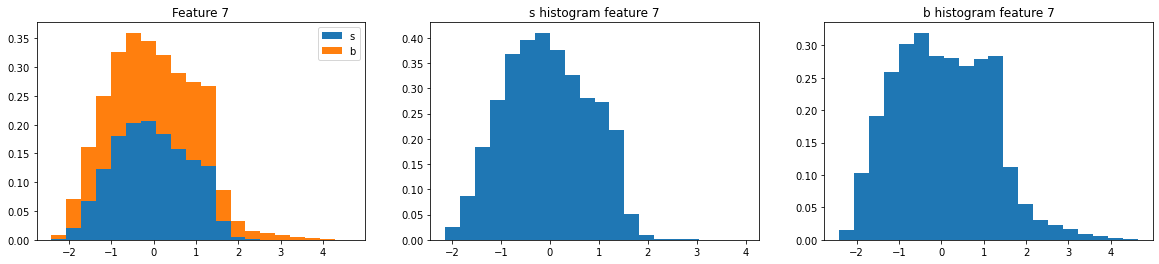

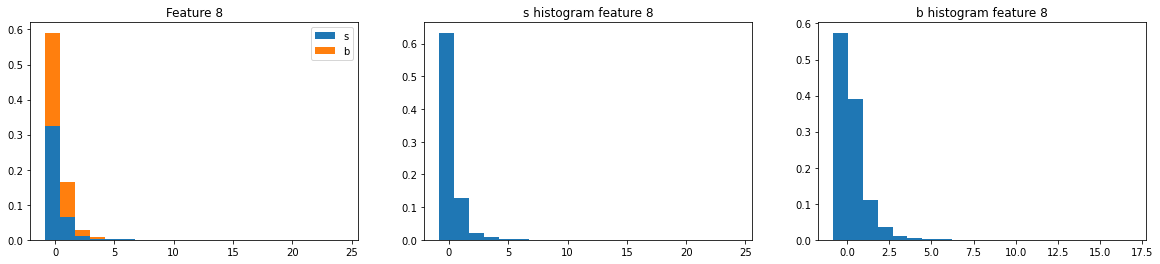

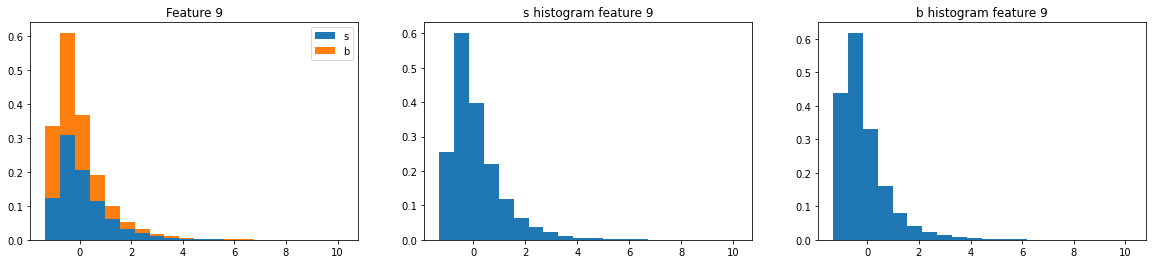

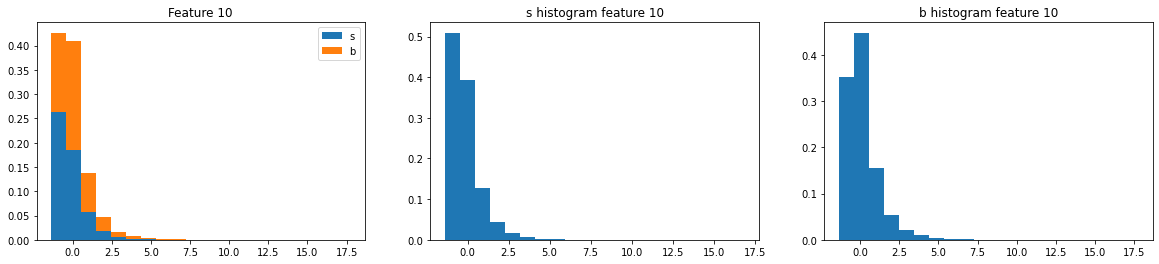

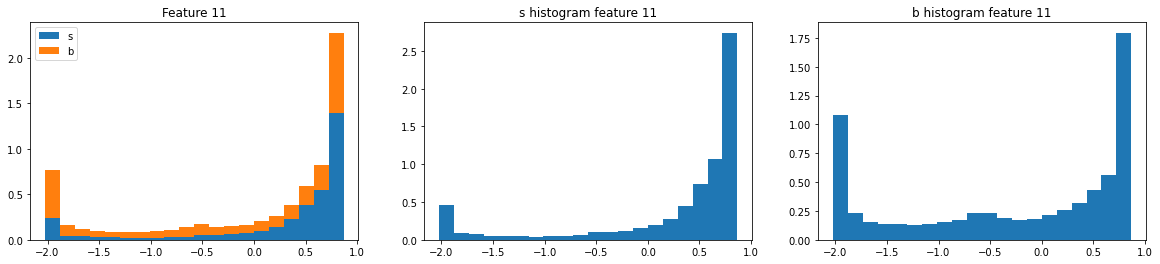

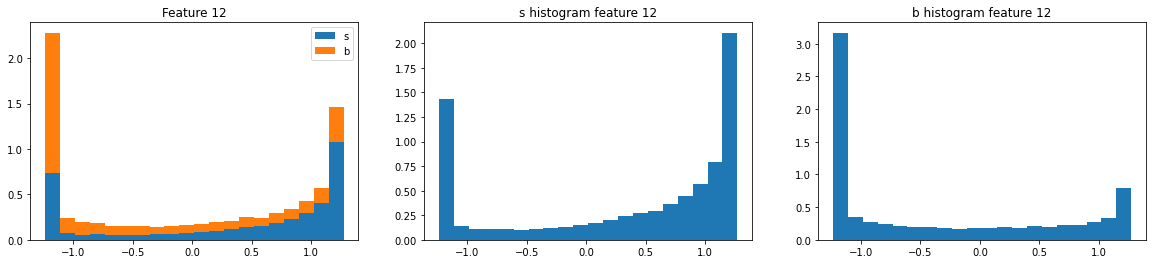

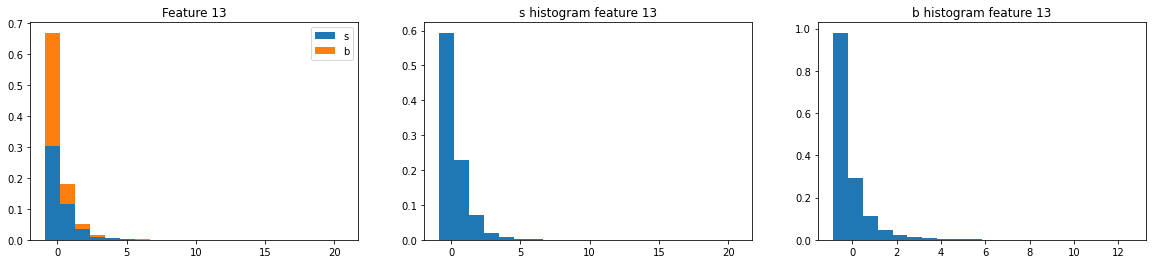

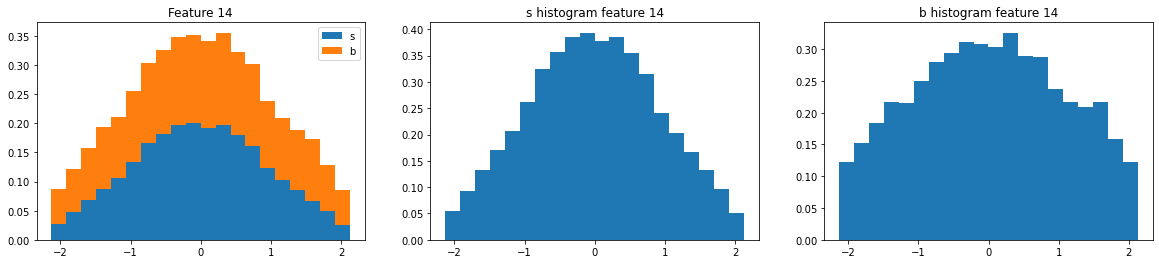

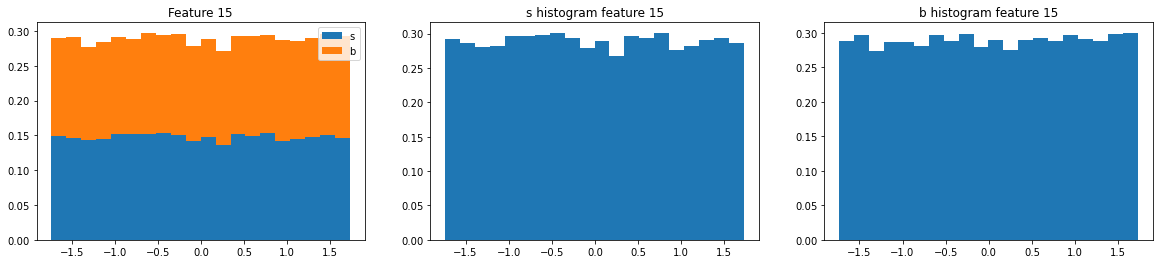

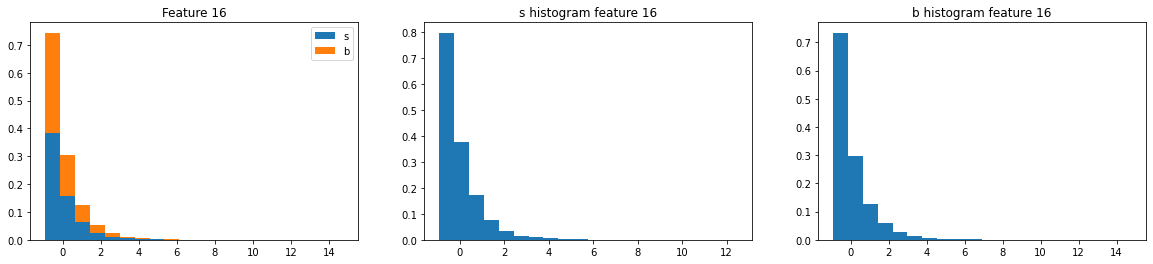

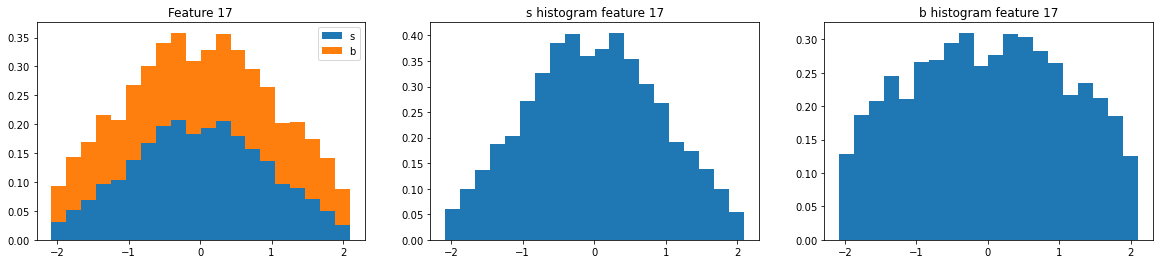

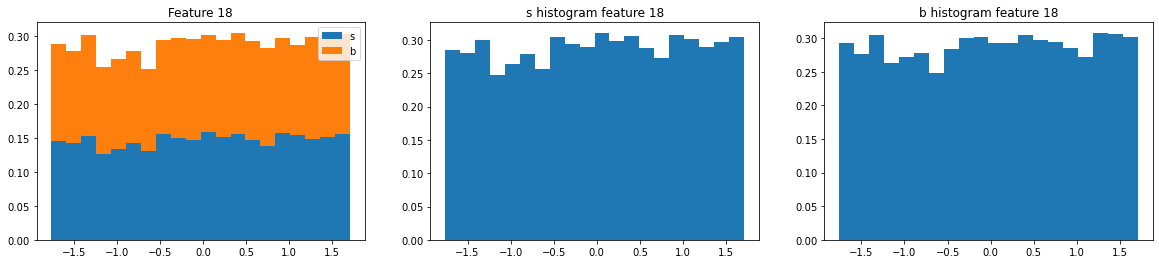

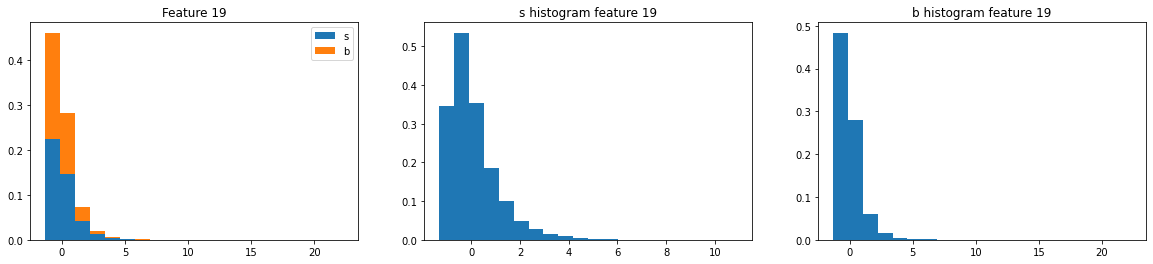

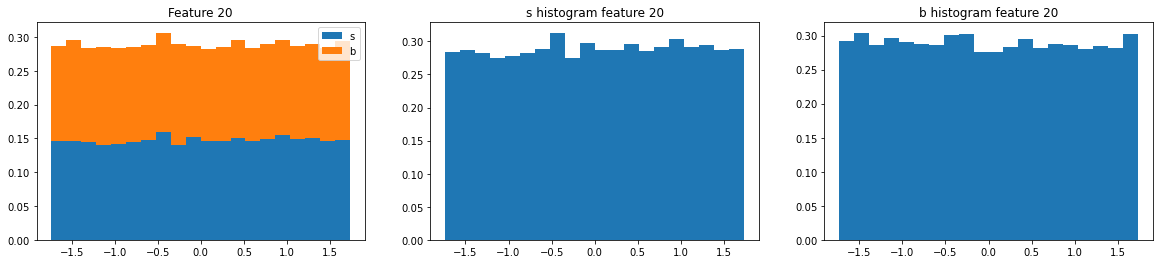

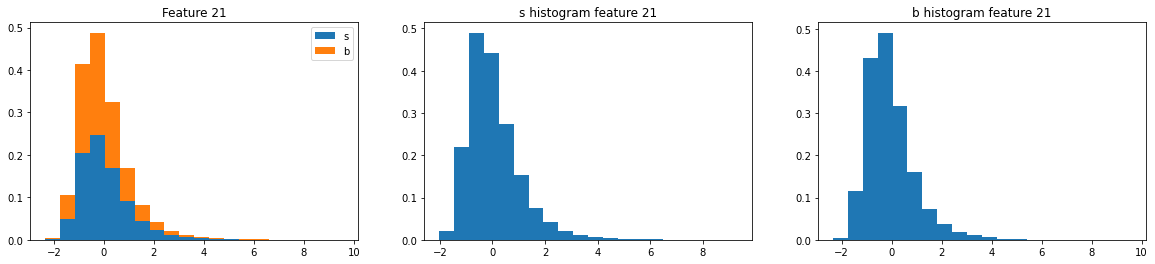

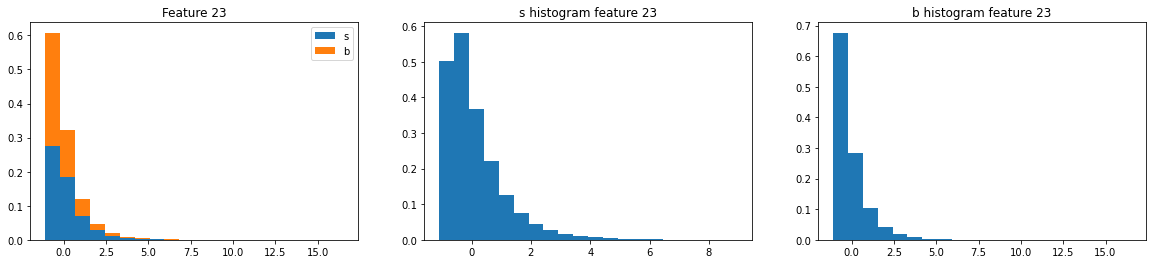

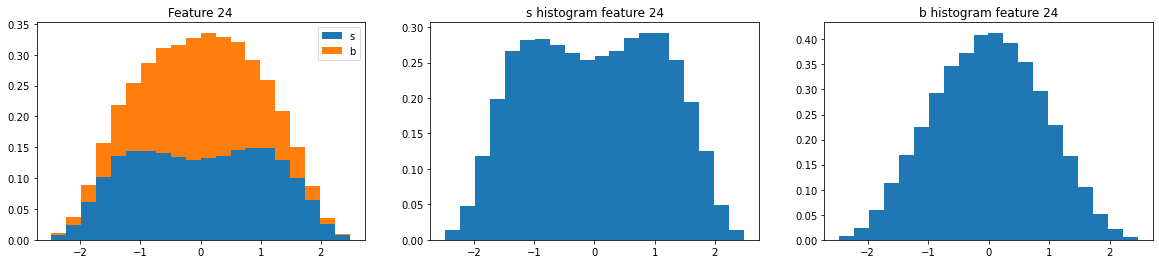

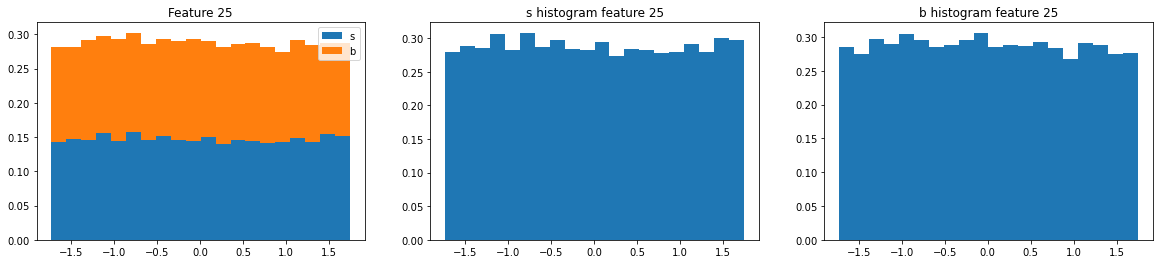

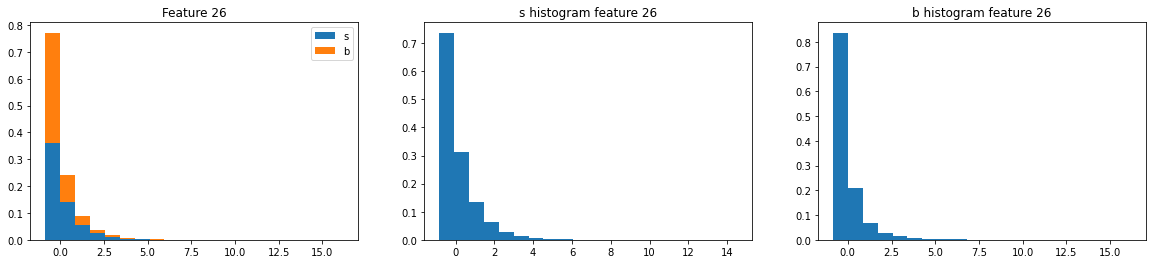

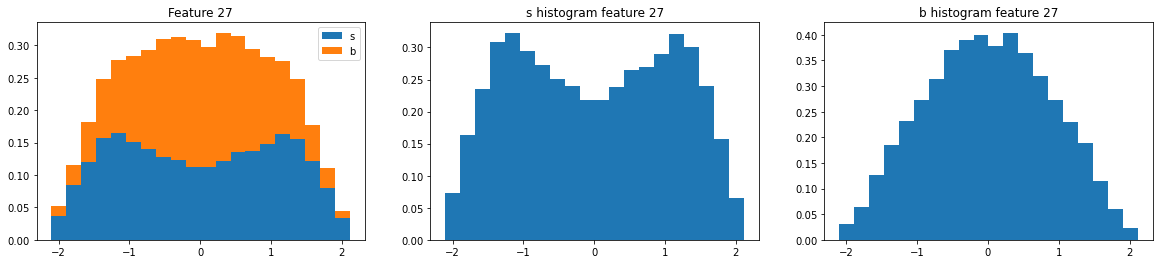

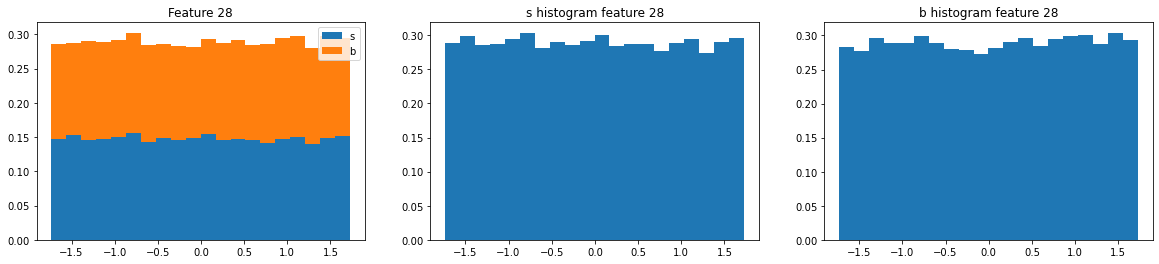

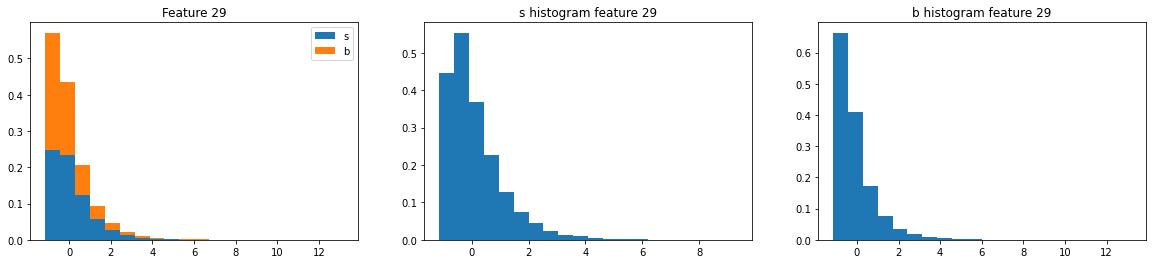

Jet 3: s: 6731, b: 15433 ,total: 22164


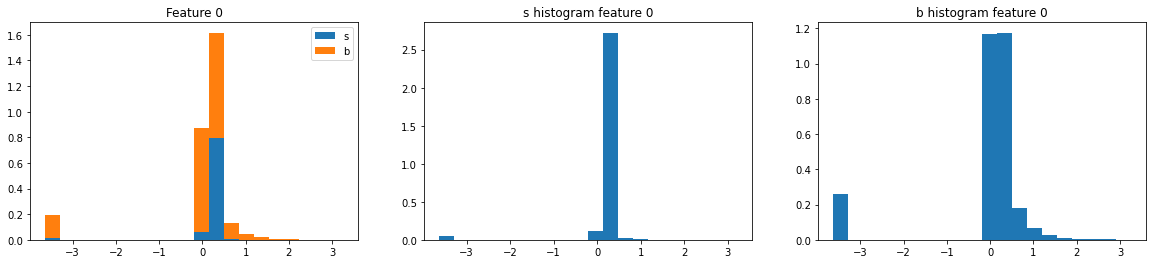

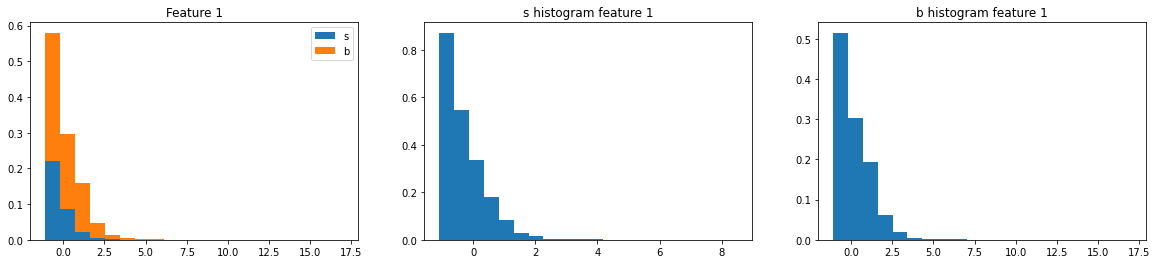

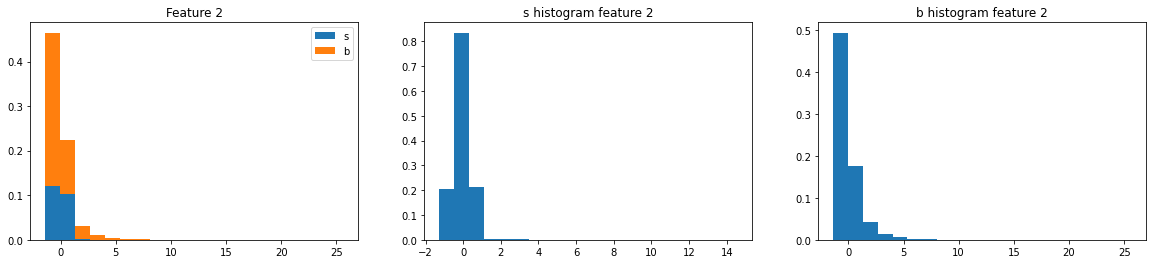

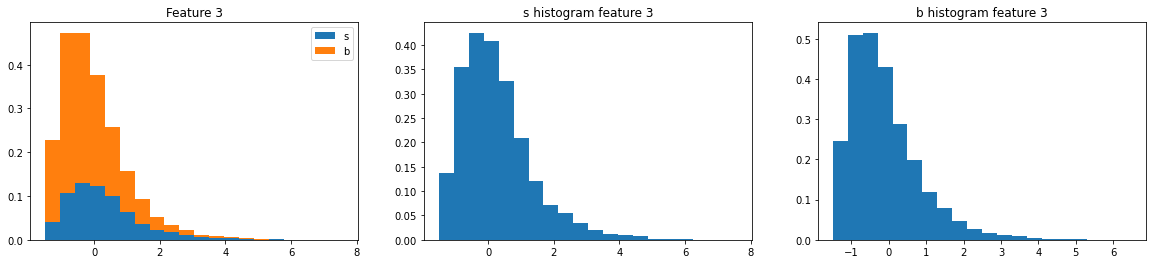

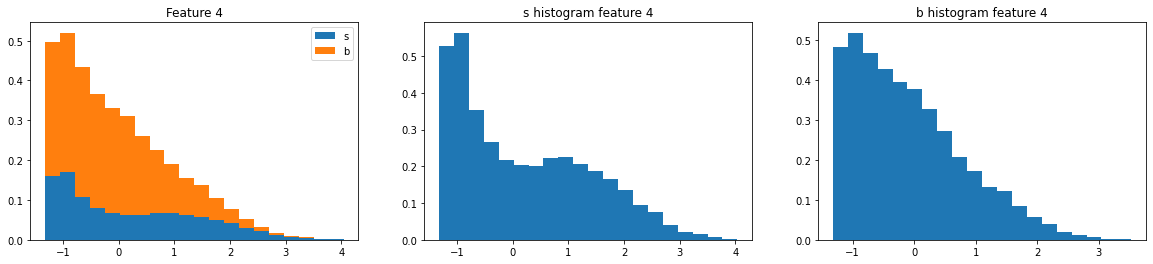

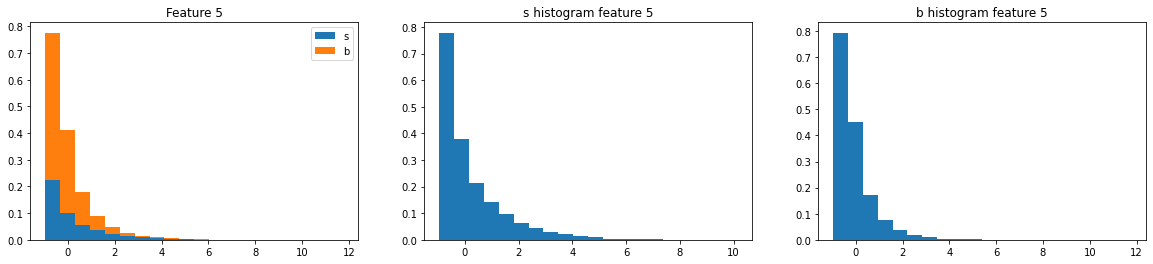

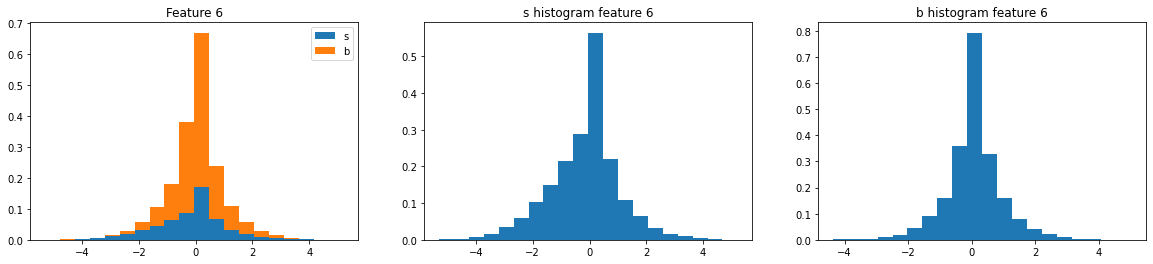

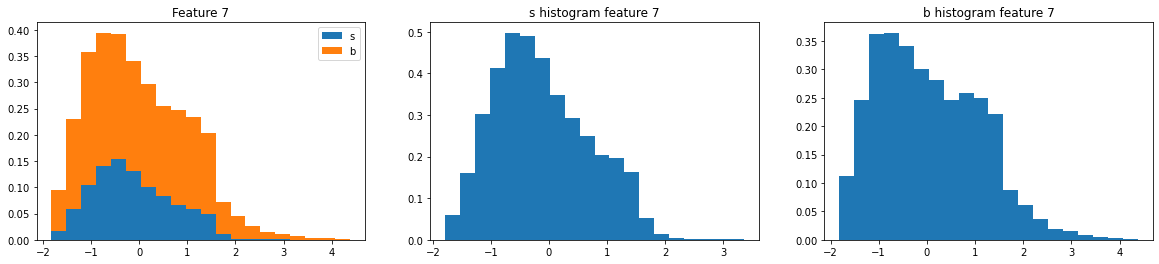

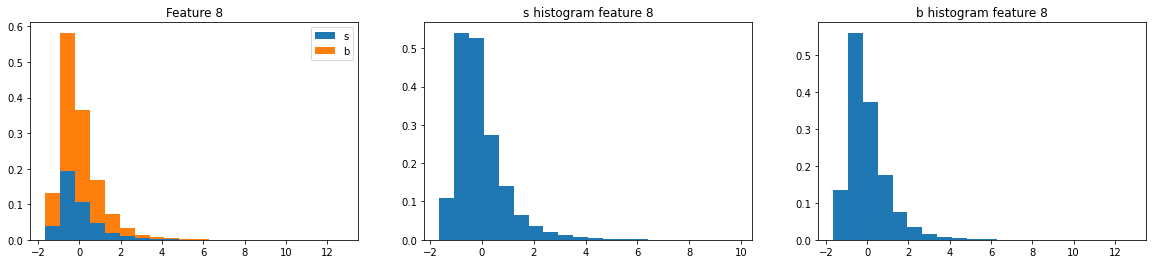

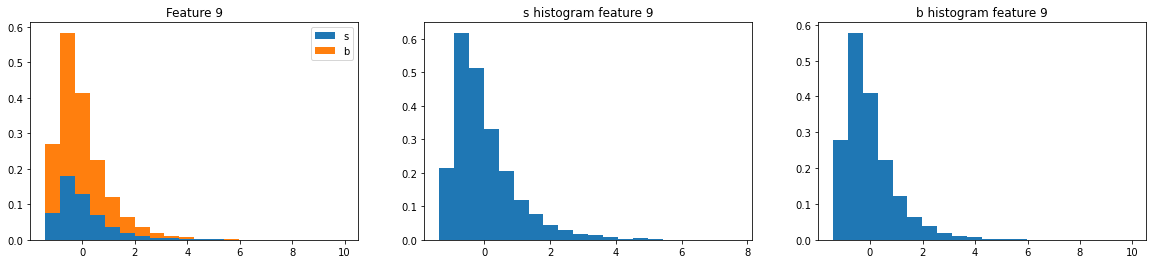

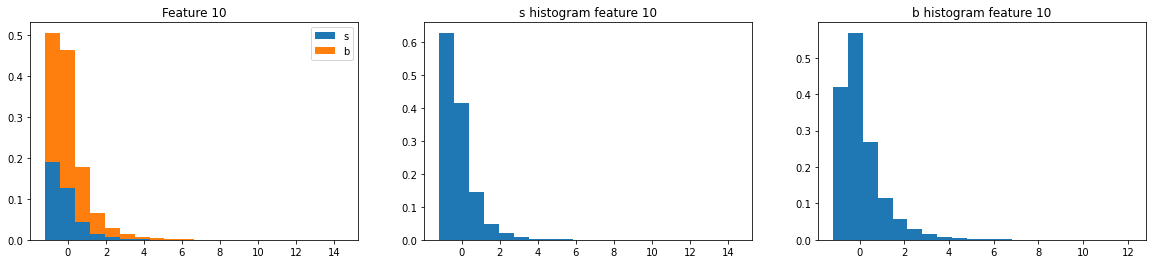

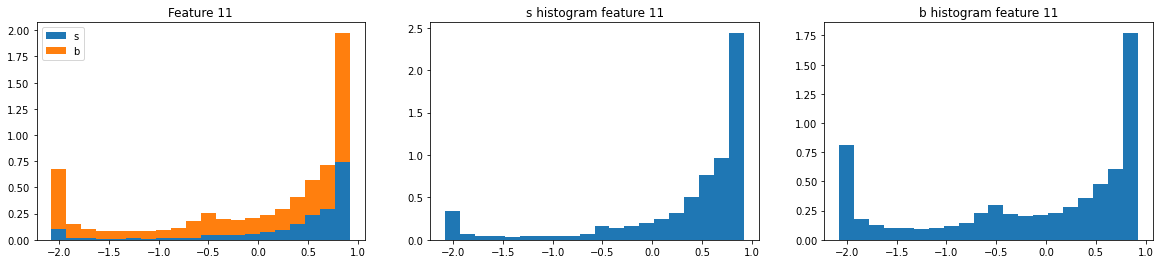

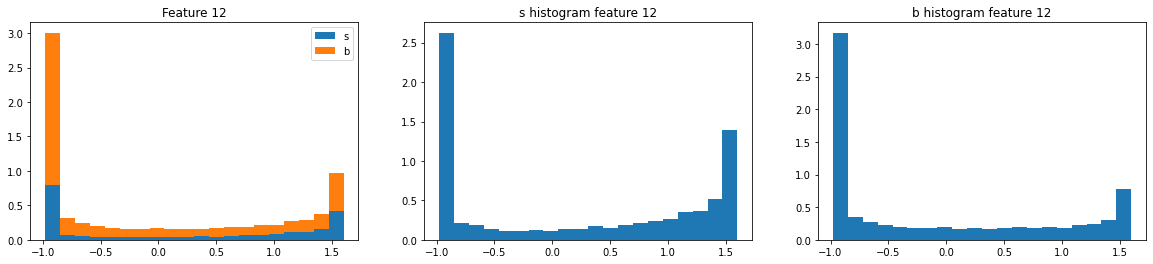

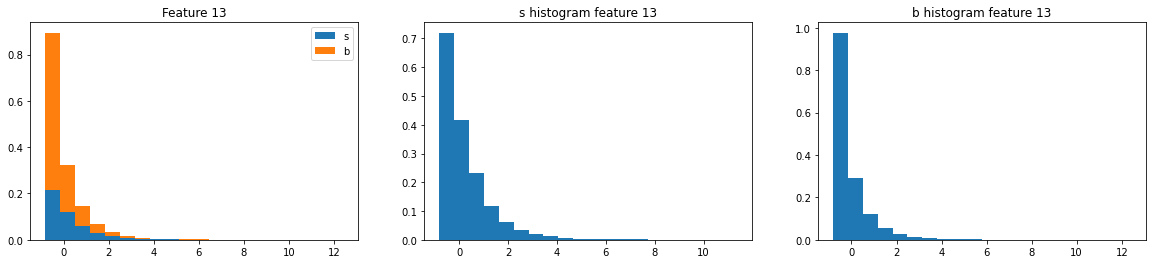

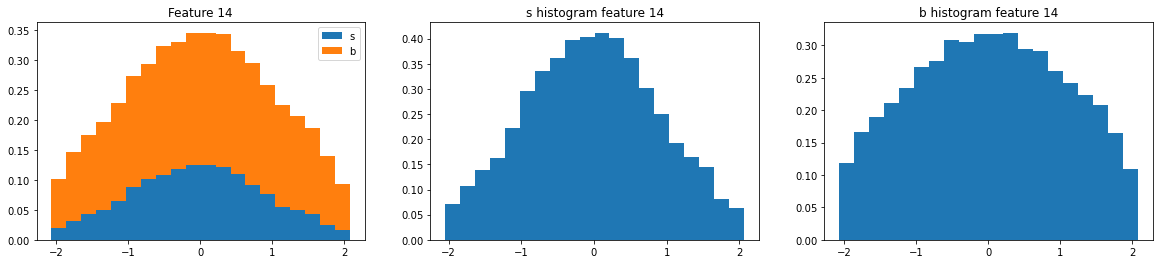

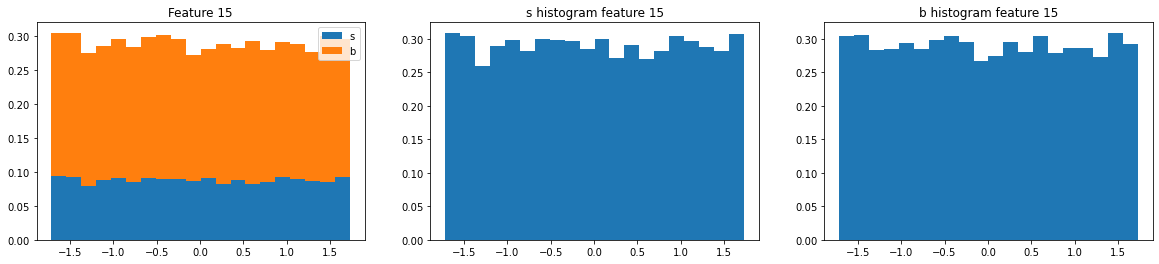

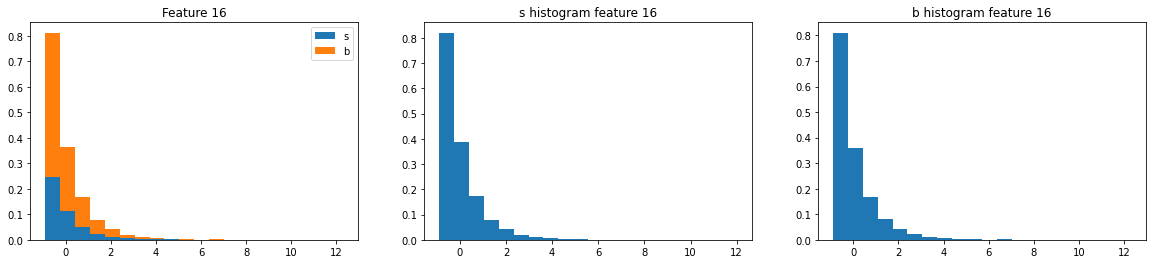

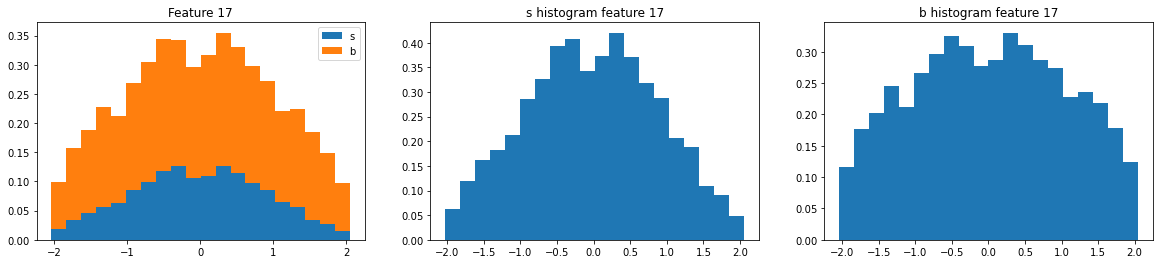

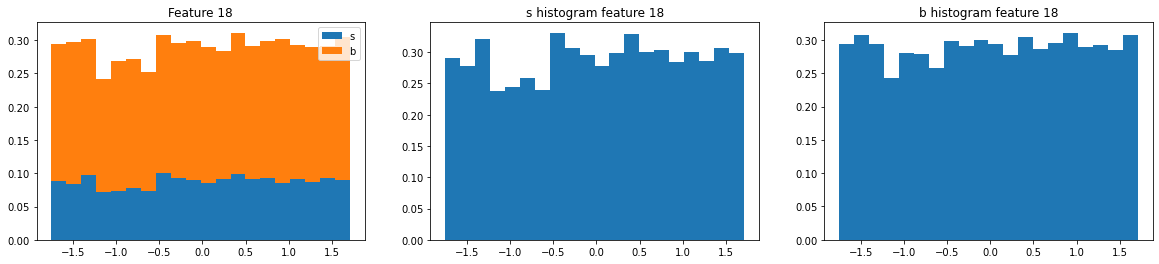

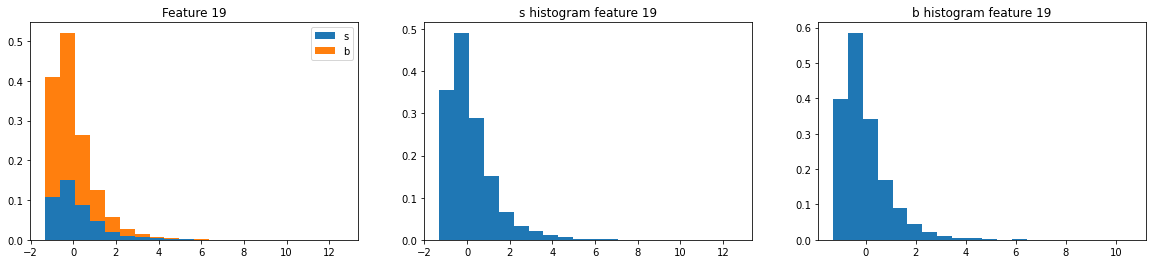

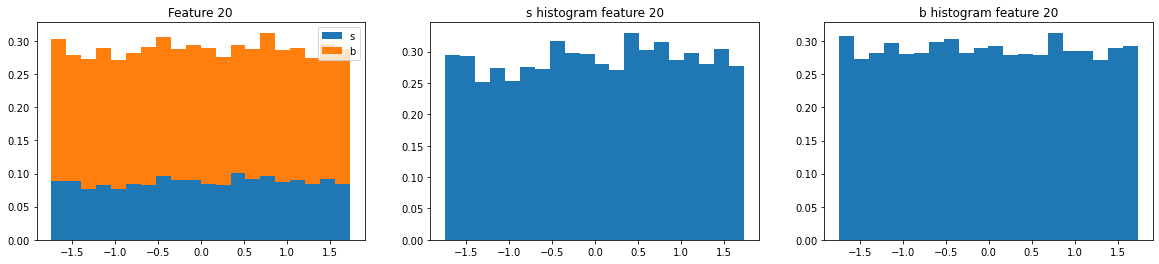

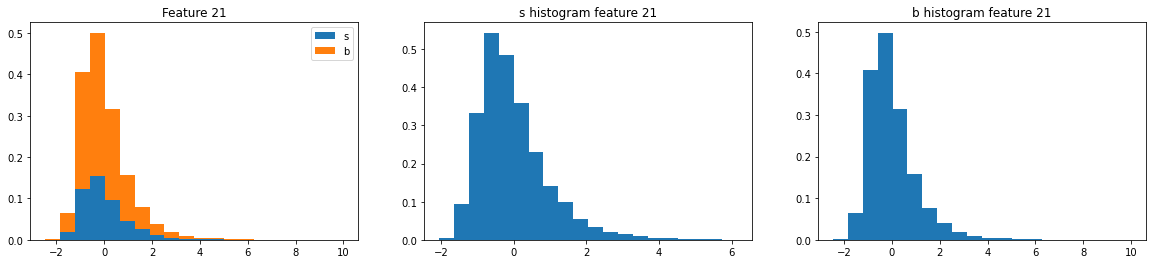

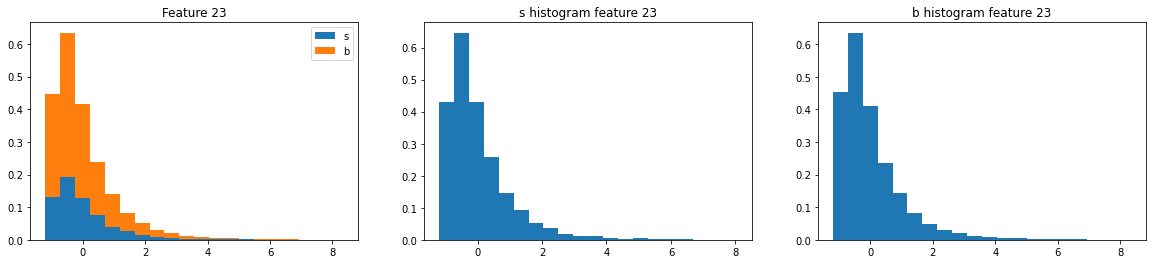

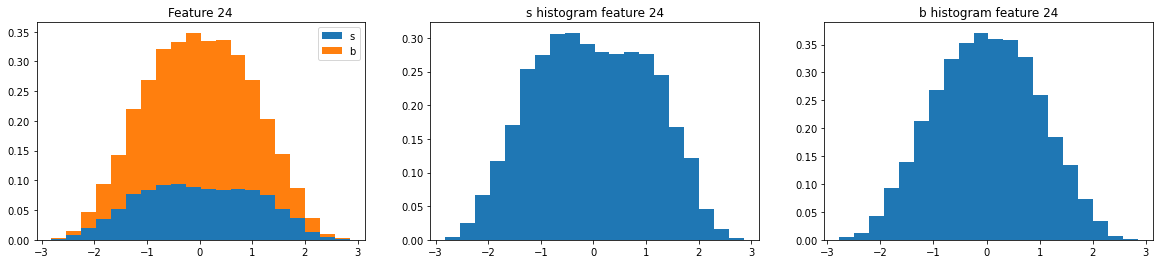

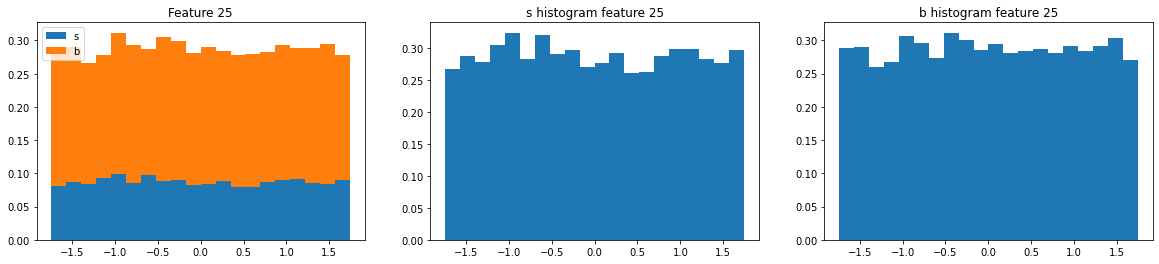

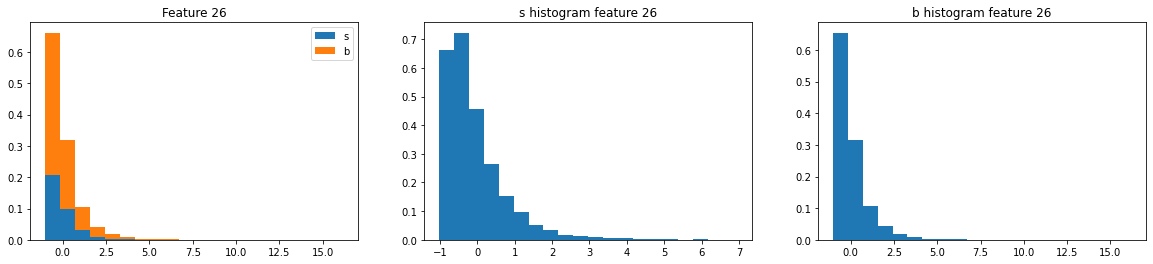

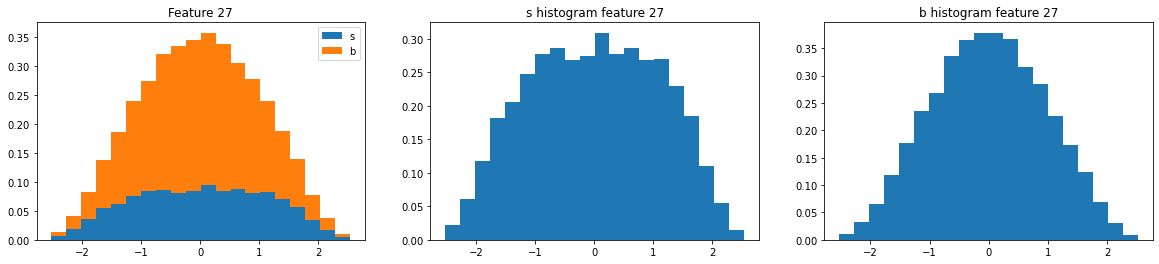

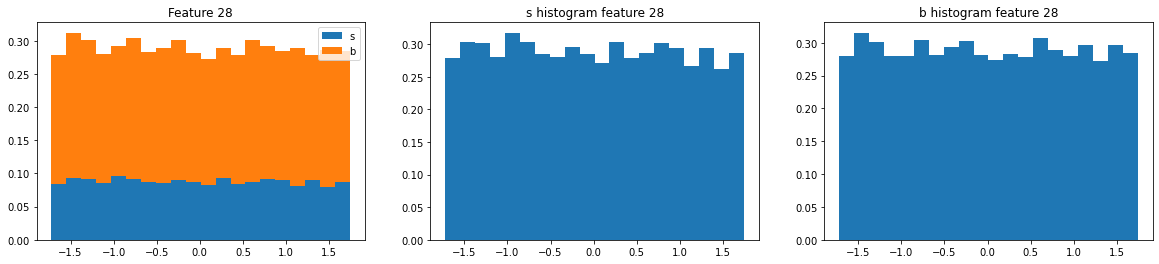

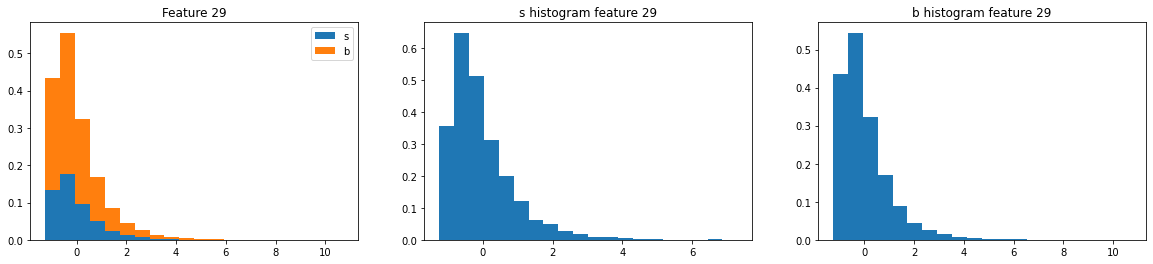

In [10]:
print("Overall: s: ",np.sum(y==1),", b: ",np.sum(y==-1)," ,total:",len(y))
for jet in range(4):
    print('Jet {:}: s: {:}, b: {:} ,total: {:}'.format(jet, np.sum(y_jet[jet]==1),np.sum(y_jet[jet]==-1),len(y_jet[jet])))
    for n,feat in enumerate(idx_jet_undef[jet]):
        plt.figure(figsize=(20,4))
        plt.subplot(131)
        plt.hist([tx_jet[jet][y_jet[jet]==1,n],tx_jet[jet][y_jet[jet]==-1,n]], 20, density=True, histtype='bar', stacked=True)
        plt.legend(['s','b'])
        plt.title('Feature '+str(feat))
        plt.subplot(132)
        plt.title('s histogram feature '+str(feat))
        plt.hist(tx_jet[jet][y_jet[jet]==1,n], 20, density=True, histtype='bar', stacked=True)
        plt.subplot(133)
        plt.title('b histogram feature '+str(feat))
        plt.hist(tx_jet[jet][y_jet[jet]==-1,n], 20, density=True, histtype='bar', stacked=True)    
        plt.show()

Overall: s:  85667 , b:  164333  ,total: 250000
Jet 0: s: 25492, b: 74421 ,total: 99913


IndexError: list index out of range

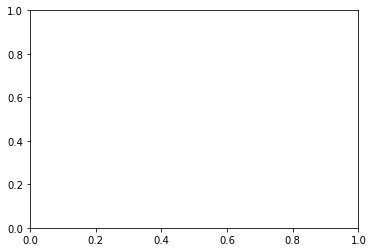

In [11]:
print("Overall: s: ",np.sum(y==1),", b: ",np.sum(y==-1)," ,total:",len(y))
for jet in range(4):
    print('Jet {:}: s: {:}, b: {:} ,total: {:}'.format(jet, np.sum(y_jet_nm[jet]==1),np.sum(y_jet_nm[jet]==-1),len(y_jet_nm[jet])))
    for n,feat in enumerate(idx_jet_undef_nm[jet]):
        plt.figure(figsize=(20,4))
        plt.subplot(131)
        plt.hist([tx_jet_nm[jet][y_jet_nm[jet]==1,n],tx_jet_nm[jet][y_jet_nm[jet]==-1,n]], 20, density=True, histtype='bar', stacked=True)
        plt.legend(['s','b'])
        plt.title('Feature '+str(feat))
        plt.subplot(132)
        plt.title('s histogram feature '+str(feat))
        plt.hist(tx_jet_nm[jet][y_jet_nm[jet]==1,n], 20, density=True, histtype='bar', stacked=True)
        plt.subplot(133)
        plt.title('b histogram feature '+str(feat))
        plt.hist(tx_jet_nm[jet][y_jet_nm[jet]==-1,n], 20, density=True, histtype='bar', stacked=True)    
        plt.show()

# Actual predictions start from here

After having looked at the data we will now do some actual predictions using different models andd parameters.

In [29]:
tx_full = tx_jet+tx_jet_nm
y_full = y_jet+y_jet_nm
# for y_i in y_full:
#     y_i[y_i==-1] = 0
max_iters = 5000
k_fold = 5
tx_full[0]
least_squares(y_full[0],build_poly(tx_full[0],1))

(array([-4.89716053e-01, -2.76328418e-02, -2.68069292e-01, -4.23536318e-01,
        -4.15184793e-02,  3.76232541e-01, -1.73306173e-01,  3.10996258e-02,
         2.02198902e-01, -1.08532033e-03, -6.57977786e-04,  2.34080294e-01,
         6.67013322e-03,  3.75773525e-05,  9.11124828e-02, -5.39213682e-03,
         3.55227839e-02]),
 0.2719971297794218)

In [33]:
initial_w = np.zeros(build_poly(tx_full[0],1).shape[1],)
gamma=0.01
for iter in range(2000):
    w_GD, loss_GD = least_squares_SGD(y_full[0],build_poly(tx_full[0],1), w_GD, 1, gamma)
    print(w_GD, loss_GD)

[-0.50310615 -0.03034672 -0.38234059 -0.52964783 -0.04060617  0.35819447
 -0.31886911 -0.05577338  0.15977445  0.06421381 -0.09465974  0.26297769
 -0.11830155  0.08719638 -0.03075359 -0.075786    0.11424621] 0.3357713293265132
[-0.50963351 -0.0194208  -0.38369932 -0.54098726 -0.04469692  0.35635817
 -0.309332   -0.05241512  0.13578768  0.06252111 -0.09761449  0.26008913
 -0.12526443  0.09746355 -0.04347618 -0.06996666  0.10777629] 0.34157929442377466
[-0.52179989 -0.02577021 -0.36290529 -0.53500623 -0.0529791   0.35532212
 -0.31251664 -0.0811857   0.14267133  0.04086138 -0.08626485  0.26270016
 -0.14171378  0.08512442 -0.02788651 -0.08466874  0.10221196] 0.33516098653296
[-0.51683569 -0.02289657 -0.37172003 -0.5346473  -0.05585702  0.35863763
 -0.31599712 -0.08371852  0.14451309  0.04288122 -0.07939862  0.26157966
 -0.14264799  0.08355596 -0.03538077 -0.08697008  0.09900424] 0.3388182280166236
[-0.50938206 -0.01810392 -0.38424924 -0.53660934 -0.03822845  0.35833701
 -0.32610582 -0.0670

[-0.55322469 -0.04275654 -0.34097534 -0.49463558 -0.00427237  0.37332206
 -0.33129579  0.01732807  0.19989217  0.06680491 -0.01932697  0.28319749
 -0.1275      0.07801948  0.01934526 -0.06137757  0.11193338] 0.31339174126449265
[-0.56548605 -0.05036654 -0.3241824  -0.49555178 -0.01074264  0.36651237
 -0.33663462  0.0239244   0.2006729   0.05525498 -0.01290839  0.27308914
 -0.1384094   0.06302089  0.03646861 -0.0687198   0.09962678] 0.31125088195688927
[-0.56590652 -0.04966274 -0.32463209 -0.49542046 -0.01098444  0.36673796
 -0.33662973  0.02409673  0.20071579  0.0554749  -0.01315078  0.27301322
 -0.13814455  0.06332004  0.03609014 -0.06925158  0.09986679] 0.3114595856338801
[-0.56607888 -0.04975473 -0.32466029 -0.49537965 -0.01087203  0.3667367
 -0.33669381  0.02417952  0.20080084  0.05556938 -0.01286831  0.27300994
 -0.13819337  0.06337393  0.03613758 -0.06945044  0.09999824] 0.3115195465700535
[-0.55911043 -0.04673481 -0.32209492 -0.50322765 -0.0063661   0.35348955
 -0.32885497  0.02

[-0.55619535 -0.04188898 -0.26111775 -0.51334444 -0.02020254  0.35659731
 -0.24897743  0.01806935  0.16650848  0.09198558 -0.03669462  0.30620972
 -0.09787124 -0.00474645  0.07729968 -0.01925753  0.08832507] 0.2848532951125597
[-0.54663533 -0.03626918 -0.27045965 -0.51309046 -0.02694652  0.35779752
 -0.26263322  0.01341618  0.17863329  0.09202323 -0.04697532  0.29808222
 -0.10281362 -0.00134571  0.07574669 -0.01029167  0.08491071] 0.2851049807244995
[-0.54989567 -0.03081181 -0.27376068 -0.51192877 -0.02949348  0.36165355
 -0.26478721  0.01513884  0.17914874  0.09697984 -0.04497797  0.29500119
 -0.09716597 -0.00246604  0.07291355 -0.01532071  0.07884815] 0.28473941011227266
[-0.55157035 -0.03160962 -0.2732713  -0.51051337 -0.02844839  0.36233464
 -0.26499809  0.01595575  0.18053358  0.09561007 -0.04711     0.29626051
 -0.09919768 -0.0008913   0.07374805 -0.01613766  0.08105564] 0.2849492953464159
[-0.54752008 -0.02924476 -0.2672301  -0.51059666 -0.03082732  0.3639356
 -0.25251677  0.014

[-0.48655872 -0.01797351 -0.35482475 -0.54320216 -0.05681808  0.41418705
 -0.3076686   0.00172346  0.17001572  0.08680105 -0.08278936  0.21479381
 -0.05184038 -0.01930799  0.01690423 -0.03166305  0.0311518 ] 0.31829483650754564
[-0.47795796 -0.01269395 -0.35967943 -0.54186114 -0.05192771  0.41230186
 -0.31943658 -0.00174661  0.18446883  0.07237973 -0.08992302  0.21079572
 -0.06427184 -0.00885344  0.02751964 -0.02532553  0.04958909] 0.32052949277009257
[-0.46889994 -0.00703833 -0.37084233 -0.54051573 -0.04608964  0.4245837
 -0.31877877  0.02070815  0.1783048   0.07406776 -0.07854576  0.20556538
 -0.07634153 -0.01269698  0.01994106 -0.02434298  0.05001689] 0.3266170357714795
[-0.48411313 -0.01545066 -0.34993913 -0.53315364 -0.05203923  0.42662358
 -0.30123307  0.02099924  0.17350566  0.04800755 -0.07903679  0.22053804
 -0.09937067  0.00878044  0.02287491  0.00118225  0.0460452 ] 0.3139715937773105
[-4.83102517e-01 -1.71422943e-02 -3.49620731e-01 -5.34304670e-01
 -5.16865447e-02  4.246309

[-4.59976760e-01 -2.03086750e-02 -3.58640598e-01 -5.27085800e-01
 -8.26224546e-02  4.52928339e-01 -2.61124228e-01  2.52986744e-02
  1.53879779e-01  2.09702074e-02 -4.55204807e-02  2.52959694e-01
 -1.02051315e-01 -4.99775368e-02  4.10332925e-03 -3.76548881e-02
 -3.86448112e-04] 0.3126191945281546
[-0.45132463 -0.01529003 -0.36630293 -0.52617116 -0.08726065  0.4602919
 -0.26278689  0.02066251  0.15161031  0.00473714 -0.03544811  0.25064551
 -0.1076728  -0.05617619 -0.00602958 -0.03326698 -0.00963207] 0.32106531916160885
[-0.44987233 -0.01448527 -0.36884589 -0.52643465 -0.0859987   0.4610461
 -0.26362283  0.02115257  0.15184273  0.0020194  -0.03491376  0.25026702
 -0.11031815 -0.0582936  -0.00642831 -0.03526906 -0.00868077] 0.3224904379804251
[-0.4484816  -0.01356257 -0.37133603 -0.52593545 -0.08578059  0.46183653
 -0.26592502  0.02433292  0.15533904  0.00242741 -0.03621189  0.24919196
 -0.11018096 -0.05730391 -0.00482866 -0.03425197 -0.00543135] 0.3229286606289412
[-0.44680081 -0.0127936

[-0.50207228 -0.02101969 -0.33788843 -0.55492094 -0.05772529  0.43024868
 -0.19000304  0.028949    0.06454233 -0.04701409 -0.00849056  0.27743916
 -0.1031467  -0.05773392 -0.01193141 -0.01141039  0.01171381] 0.3193395951778764
[-0.50818628 -0.02509197 -0.33998335 -0.55541459 -0.06091019  0.42522161
 -0.20501741  0.01391644  0.06927542 -0.05110781 -0.01351897  0.26891709
 -0.10227595 -0.05226057 -0.00837384 -0.01587839  0.01352946] 0.318450576707635
[-0.50779136 -0.02575302 -0.33972621 -0.55584202 -0.06067903  0.4246332
 -0.20505867  0.01370524  0.06901363 -0.0509071  -0.01346776  0.26863233
 -0.10218668 -0.05256783 -0.00781044 -0.01529779  0.01316326] 0.3184115712192987
[-0.50035101 -0.02154823 -0.34978898 -0.5560402  -0.06611289  0.42910883
 -0.21215579  0.00972634  0.07276729 -0.04498427 -0.00154719  0.26483547
 -0.10042536 -0.05432107 -0.01577811 -0.01322943  0.00642783] 0.3221592902919912
[-0.50642078 -0.02505598 -0.351886   -0.5558053  -0.06154677  0.42665709
 -0.21637459  0.01267

[-0.52211184 -0.0340249  -0.34162146 -0.55954378 -0.05391778  0.43559039
 -0.21829512  0.01420487  0.07715959 -0.05021279 -0.03889211  0.2533914
 -0.13909969  0.00888375 -0.01028329 -0.06080625  0.00185625] 0.32832832400678463
[-0.51937195 -0.03861109 -0.34003988 -0.56335185 -0.0553675   0.42919622
 -0.21844947  0.01280985  0.07549946 -0.04627241 -0.03764279  0.25176612
 -0.13561056  0.0116113  -0.00831149 -0.06333517  0.00217961] 0.327712052935646
[-0.53406712 -0.04753748 -0.31450685 -0.56736781 -0.05146615  0.41601134
 -0.20195602 -0.02361937  0.06323509 -0.07030151 -0.03513334  0.25959562
 -0.14649938 -0.01108542  0.01219771 -0.03813542 -0.00765933] 0.32969473448750414
[-0.53890789 -0.04987714 -0.31270262 -0.56365419 -0.05636367  0.42156897
 -0.20372252 -0.0217645   0.0667988  -0.0626675  -0.02749574  0.26151166
 -0.14378998 -0.00714601  0.01469669 -0.03973237 -0.01155402] 0.32667947906389844
[-0.54727066 -0.0554366  -0.30626626 -0.57005993 -0.06133136  0.42421017
 -0.19194946 -0.01

[-4.67734140e-01 -2.37205055e-02 -3.60284777e-01 -5.49731685e-01
 -2.72641244e-03  4.55320120e-01 -1.54425604e-01 -6.09709410e-02
  8.02539514e-02 -1.44478882e-04 -6.65915134e-03  2.89660472e-01
 -4.02578313e-02 -4.27068550e-02 -8.74269381e-03 -2.46689538e-02
 -3.29074026e-03] 0.3084742782357829
[-0.45503979 -0.01607692 -0.37319088 -0.54647674  0.00709823  0.46229704
 -0.16018273 -0.02955597  0.07955984  0.00728485 -0.01613336  0.28540003
 -0.01776841 -0.02692025 -0.02310485 -0.04087902 -0.0021876 ] 0.3123239841553231
[-0.45948963 -0.01838485 -0.37526564 -0.54390998  0.0019312   0.46417096
 -0.15744544 -0.02805516  0.08023238  0.01375037 -0.01442834  0.28830781
 -0.0121989  -0.01927222 -0.02538064 -0.04164919 -0.00546139] 0.3126167312209231
[-4.53905338e-01 -1.50686484e-02 -3.85045699e-01 -5.43101229e-01
 -1.86645105e-04  4.69946531e-01 -1.62944954e-01 -2.95928124e-02
  8.04623831e-02  7.85948903e-03 -1.81505273e-02  2.82963805e-01
 -1.02592461e-02 -1.42414559e-02 -3.31828323e-02 -3.55

[-0.47868692 -0.04086447 -0.3225287  -0.51772327 -0.04304485  0.49311235
 -0.22173368 -0.04998093  0.12309229 -0.02799349 -0.00466734  0.27771637
 -0.01356227 -0.07311647  0.01279135 -0.05818325 -0.08908438] 0.3089951241830248
[-0.48336595 -0.03303241 -0.32450199 -0.51532194 -0.03953308  0.49633137
 -0.2224516  -0.04756862  0.12483976 -0.02108114  0.00061159  0.27784189
 -0.00863752 -0.0732211   0.01173235 -0.06460484 -0.08200331] 0.30795748833574615
[-0.49580422 -0.04055894 -0.31035603 -0.51978142 -0.03083701  0.4810271
 -0.21210557 -0.04091697  0.12821097 -0.02265286  0.00271511  0.29079726
  0.01077344 -0.05210319  0.02471996 -0.07697748 -0.08521986] 0.30057230028093523
[-0.50932608 -0.04930504 -0.28856099 -0.52182718 -0.04203194  0.47076731
 -0.22334068 -0.07446644  0.1320499  -0.03064323 -0.0078106   0.27844087
  0.01104874 -0.0384659   0.04445048 -0.05847874 -0.07708076] 0.2985309509132946
[-0.50611322 -0.04710134 -0.29345691 -0.52076445 -0.04447297  0.47250532
 -0.22911774 -0.07

[-0.52585141 -0.04721337 -0.23702043 -0.51162541  0.07056992  0.45560512
 -0.20510321  0.05253595  0.17068     0.00675005 -0.0677842   0.31068814
  0.07009048 -0.0185465   0.11314374 -0.10610249 -0.00078951] 0.29111007430465735
[-0.53251906 -0.05196346 -0.2497407  -0.51494906  0.05395216  0.45213288
 -0.22109884  0.03617062  0.17405541  0.00634539 -0.06261713  0.29653371
  0.06389861 -0.02348955  0.1038767  -0.10297095 -0.00999677] 0.28641820121920547
[-0.53116699 -0.05422664 -0.24860716 -0.51480261  0.05439246  0.45132556
 -0.22107504  0.03599319  0.17344427  0.00650089 -0.06426382  0.296135
  0.06184841 -0.02469994  0.10498359 -0.10180519 -0.01070726] 0.28636421559170827
[-0.52282279 -0.04898861 -0.25390288 -0.51031884  0.04848716  0.4525657
 -0.23035425  0.03162002  0.18721585  0.02046979 -0.0606198   0.29714111
  0.07778322 -0.03389111  0.10328067 -0.1161233  -0.00346131] 0.2873604377090859
[-5.14319537e-01 -4.41140350e-02 -2.59998332e-01 -5.11739569e-01
  5.48345943e-02  4.5716556

  6.52170038e-02] 0.292593313701253
[-0.52425024 -0.07685132 -0.24392575 -0.50530965  0.03683028  0.44450234
 -0.22553745  0.00233587  0.22302583 -0.04463461 -0.06895475  0.29844796
  0.06299641 -0.00276047  0.13083945 -0.10221955  0.06483433] 0.28873412397768367
[-0.52417162 -0.07680686 -0.24390313 -0.5052832   0.0369008   0.44449463
 -0.22548523  0.00230129  0.22297435 -0.04469836 -0.06900585  0.29845018
  0.0630696  -0.00287428  0.13085337 -0.10215099  0.06486019] 0.2887333904743354
[-0.5282546  -0.07898083 -0.24500654 -0.50442297  0.03419798  0.44768639
 -0.22789487  0.00431912  0.22348903 -0.05122576 -0.06735377  0.29471492
  0.05686714 -0.00586076  0.13263463 -0.09676362  0.06377225] 0.2878480358635715
[-0.53793325 -0.08509279 -0.2405723  -0.50980672  0.04094148  0.44182246
 -0.22430422  0.00892671  0.21498303 -0.03350617 -0.06066818  0.28581741
  0.07234065 -0.01591111  0.14350762 -0.09079098  0.06937652] 0.28983802187353475
[-0.5473244  -0.090234   -0.23086134 -0.50665951  0.03

[-0.51860761 -0.07341966 -0.20570434 -0.46660825  0.04163489  0.43524407
 -0.24188554 -0.03454266  0.27803653 -0.0437182  -0.09792397  0.33129356
  0.06237098 -0.0824546   0.16970666 -0.07359149  0.05786042] 0.30690366854081413
[-0.52435766 -0.0775405  -0.20658234 -0.47320082  0.04343904  0.42850914
 -0.24156162 -0.0319158   0.27797488 -0.05202497 -0.09596754  0.32966712
  0.06350133 -0.08915617  0.17232458 -0.06960817  0.032591  ] 0.30555877088986033
[-0.52663642 -0.07863397 -0.20580542 -0.4710941   0.04043426  0.43089857
 -0.24084945 -0.034086    0.27922813 -0.05324776 -0.09310948  0.33143507
  0.06196058 -0.09168667  0.17359641 -0.06752626  0.03026082] 0.30602478506097097
[-0.52966292 -0.08042412 -0.21070705 -0.47114085  0.03518135  0.42947528
 -0.2504361  -0.04157898  0.28142182 -0.05115437 -0.09398321  0.32480609
  0.06376996 -0.08748389  0.1710294  -0.06731309  0.02875179] 0.3048184153775185
[-0.52472756 -0.07697297 -0.21612879 -0.46465441  0.03131085  0.43193864
 -0.25606027 -0.

[-5.07136091e-01 -5.05302262e-02 -2.75624903e-01 -4.75005349e-01
 -9.10103261e-03  4.65893983e-01 -2.90147911e-01 -2.50305737e-04
  2.62045455e-01 -3.12725666e-02 -9.90182657e-02  2.43905026e-01
  5.29497464e-02 -8.85844281e-02  1.17504330e-01 -1.79775308e-02
 -1.02672498e-03] 0.29054088991162763
[-0.50912909 -0.04719422 -0.27637206 -0.47519073 -0.00753949  0.46565815
 -0.29002193  0.0007772   0.26380005 -0.02903442 -0.09627955  0.24587566
  0.05099558 -0.09185118  0.11609518 -0.01820912  0.00209331] 0.2906468739128025
[-5.05715377e-01 -4.49010924e-02 -2.82310133e-01 -4.73188125e-01
 -6.09307784e-03  4.67997198e-01 -2.95062515e-01 -6.06780134e-06
  2.70557160e-01 -2.67127433e-02 -9.19861511e-02  2.43984072e-01
  5.57073825e-02 -9.38424170e-02  1.12457529e-01 -1.97634022e-02
  1.96162954e-03] 0.2929487879163483
[-0.49959762 -0.04088243 -0.28518388 -0.4704639   0.00405662  0.47102425
 -0.3043062  -0.00329727  0.28459647 -0.02993248 -0.09341126  0.24107898
  0.05226924 -0.08534931  0.1087

[-0.57651797 -0.05205688 -0.27105596 -0.50152531 -0.02583264  0.44105992
 -0.27273065 -0.00381287  0.23876997 -0.01753256 -0.04529987  0.23719236
  0.02197504 -0.0735471   0.10006953 -0.02741897  0.01650651] 0.286075626948554
[-0.57535312 -0.05400668 -0.27017755 -0.50193715 -0.02655971  0.4407794
 -0.27074534 -0.00429777  0.23773375 -0.01700194 -0.04398868  0.23770496
  0.02352241 -0.07487953  0.10036405 -0.0269485   0.01599664] 0.2857194967606579
[-0.58110516 -0.04437855 -0.27404588 -0.50068051 -0.03447136  0.44638765
 -0.2637059  -0.00273849  0.23391783 -0.00703544 -0.03927479  0.24257064
  0.02641714 -0.06567685  0.09397066 -0.02844271  0.00473446] 0.2850428787568865
[-0.58977382 -0.04874136 -0.2657218  -0.49552643 -0.02758521  0.44644969
 -0.2553626   0.00187877  0.23442654  0.00383104 -0.05067337  0.25134294
  0.03459538 -0.06418258  0.10086895 -0.02009686  0.01749485] 0.2840012078400474
[-5.82819519e-01 -6.03819147e-02 -2.42892644e-01 -4.95899394e-01
 -2.18280726e-02  4.40180795e

[-0.60845857 -0.03250399 -0.29975902 -0.56412129 -0.0250523   0.43879832
 -0.23935441  0.00725471  0.14132087 -0.00956203 -0.00619549  0.19869734
  0.02796798 -0.03367135  0.07265703  0.00854676 -0.00882057] 0.30345045279398414
[-0.59720376 -0.02568711 -0.30991902 -0.56072424 -0.03146844  0.44138014
 -0.25181232  0.00153632  0.15288001  0.00441595  0.01126667  0.19470088
  0.03331967 -0.03307297  0.06703709  0.00262069 -0.01176979] 0.304964682410226
[-0.59198899 -0.02288453 -0.31814383 -0.56305742 -0.03471868  0.44447187
 -0.25791629 -0.00125239  0.15434529  0.0011472   0.01965881  0.18929614
  0.02961326 -0.03365919  0.06135484  0.00071573 -0.0171129 ] 0.30899084099822355
[-0.59084023 -0.02480741 -0.3173522  -0.56443504 -0.03545534  0.44221679
 -0.25759584 -0.00181399  0.15350871  0.00291945  0.01887794  0.18876591
  0.03068357 -0.03516849  0.06226529  0.00148228 -0.01676722] 0.3091145889527807
[-0.58234294 -0.02009199 -0.32762997 -0.56603948 -0.03928691  0.44779394
 -0.26616867 -0.00

[-0.56219624 -0.03826419 -0.34093548 -0.51733761 -0.02565541  0.44558232
 -0.24665476 -0.02318759  0.20577633 -0.00603065 -0.03538548  0.22111904
  0.04014862 -0.04395478  0.0660617  -0.01113586  0.05231607] 0.2916122829035282
[-0.54892822 -0.03134746 -0.3466792  -0.524639   -0.01608381  0.45029094
 -0.24945539  0.00827311  0.19642416 -0.00291263 -0.05057361  0.20946893
  0.0555064  -0.03306023  0.05859639 -0.02857668  0.05196546] 0.2967524649794048
[-0.54949645 -0.03161969 -0.34604442 -0.52420499 -0.01818512  0.45129002
 -0.25031932  0.00767978  0.19670693 -0.00336313 -0.05079112  0.20877405
  0.05507321 -0.03371186  0.05906633 -0.02950055  0.05187389] 0.2967790817906661
[-0.53810013 -0.02488695 -0.34576354 -0.52715994  0.00342848  0.45429881
 -0.26305144  0.03297472  0.20139828 -0.00550802 -0.04042125  0.19906666
  0.0589099  -0.04571327  0.05887553 -0.01851675  0.06013635] 0.30243580719901314
[-0.52451079 -0.01729184 -0.34739164 -0.52771337 -0.00639589  0.4563577
 -0.26603673  0.025

  0.05494725 -0.06556492  0.03683835  0.00748076  0.06534047] 0.30283801150857087
[-4.60797083e-01  9.44859939e-03 -3.37758267e-01 -5.07318913e-01
 -5.28073205e-02  4.84218202e-01 -2.36464440e-01  2.04043138e-04
  2.07823287e-01 -1.96886955e-02 -6.61352724e-02  2.20358030e-01
  4.27899330e-02 -7.79571793e-02  3.90038938e-02  1.08599530e-02
  6.79021069e-02] 0.30202284789380973
[-0.46941693  0.00471383 -0.33600748 -0.50386963 -0.04724869  0.48036342
 -0.2382613   0.00464807  0.21218075 -0.01124553 -0.06951074  0.22185158
  0.05399959 -0.06515259  0.04474202  0.01055322  0.07297253] 0.2997343175836341
[-0.45994897 -0.01113427 -0.30956751 -0.49577763 -0.05067646  0.47722295
 -0.21912919  0.00066638  0.21224185 -0.02100303 -0.05311733  0.25120514
  0.03744001 -0.07034196  0.06052485  0.01997124  0.0623807 ] 0.2866519847264158
[-0.43704285 -0.049476   -0.26569781 -0.49379388 -0.06755232  0.46899735
 -0.17154262 -0.00837972  0.19969535 -0.03159123 -0.03291713  0.28953099
  0.01084962 -0.0787

[-0.47498218 -0.0518199  -0.26907962 -0.50639667 -0.02480519  0.43475792
 -0.14787939 -0.00474579  0.21405305  0.00112075 -0.05013557  0.30139939
  0.02793621 -0.07724682  0.09664613 -0.0323255   0.07645974] 0.27921057828076346
[-0.46477684 -0.04642264 -0.28295078 -0.51101985 -0.03184894  0.43890957
 -0.15880715 -0.01018154  0.21603943  0.00375897 -0.05503985  0.29169126
  0.03020415 -0.0637415   0.08565818 -0.02378003  0.07374554] 0.2774060028466832
[-0.46973182 -0.05031483 -0.28599139 -0.522357   -0.03450497  0.4340636
 -0.15675592 -0.01209686  0.2089401   0.01150883 -0.05762909  0.28422758
  0.03070571 -0.05843894  0.0875115  -0.02699337  0.06476546] 0.277328252061346
[-0.47214092 -0.04628233 -0.28789586 -0.52208095 -0.03310703  0.43529704
 -0.15676519 -0.01083169  0.20989598  0.01176302 -0.05831928  0.28478176
  0.02785285 -0.05691575  0.08522185 -0.03062424  0.0633026 ] 0.2771307371156073
[-0.46521575 -0.05787412 -0.29166086 -0.51789989 -0.03794203  0.43502773
 -0.16797899 -0.0138

[-0.47330043 -0.03281054 -0.31650429 -0.45890102  0.01900895  0.44885985
 -0.16605409 -0.02450713  0.23193484  0.12416702 -0.00075018  0.28201487
  0.05286201 -0.12375877  0.08141355  0.00944803  0.08301027] 0.3000260746552083
[-0.47710123 -0.03481554 -0.3165564  -0.4573914   0.01548065  0.45053172
 -0.17196995 -0.02528245  0.234698    0.1197116  -0.00598635  0.2793169
  0.05035304 -0.12410302  0.08418305  0.01590281  0.08247887] 0.2991427845880101
[-0.46921886 -0.03004647 -0.32824674 -0.45490451  0.01035694  0.45540967
 -0.17985463 -0.0293715   0.24167762  0.116362   -0.01546918  0.27723617
  0.05273012 -0.12098687  0.07573543  0.02189813  0.0779349 ] 0.30072187935965616
[-0.46129945 -0.02563987 -0.33034918 -0.45518789  0.02058146  0.457946
 -0.18227519 -0.00972245  0.24313326  0.12741747 -0.00271573  0.27851357
  0.06328638 -0.12106682  0.07343046  0.02943029  0.09341009] 0.3080239541014291
[-0.45746589 -0.03205674 -0.32359003 -0.45585461  0.01835234  0.45677395
 -0.17049462 -0.01109

[-0.48599662 -0.04927292 -0.30215671 -0.49838642 -0.03221033  0.40391875
 -0.16084523 -0.08980229  0.22879833  0.05737969 -0.0404156   0.28595265
 -0.02838678 -0.10987257  0.09299703  0.02807714  0.0550614 ] 0.28722338418903953
[-0.49137387 -0.04027213 -0.30214222 -0.4998582  -0.02862148  0.40043595
 -0.15937734 -0.08696112  0.23296566  0.0513902  -0.04134071  0.29147087
 -0.02340398 -0.10563264  0.09185127  0.02067653  0.06045369] 0.28587737394129586
[-0.49577959 -0.04253137 -0.30155436 -0.49675683 -0.0272756   0.40043571
 -0.16088661 -0.08552693  0.23631787  0.05393751 -0.04857632  0.29348566
 -0.02150944 -0.1039498   0.09415324  0.0149244   0.06361084] 0.2856526306353239
[-0.50541862 -0.04736304 -0.29087416 -0.49007643 -0.02228118  0.39572196
 -0.15416169 -0.08046485  0.24102409  0.05743186 -0.0567054   0.30415057
 -0.02332064 -0.09623813  0.10645789  0.0025632   0.06997112] 0.28636171994107035
[-0.51142861 -0.05031124 -0.28648392 -0.48553029 -0.01886078  0.39456001
 -0.15147739 -0.

[-0.38760121 -0.02710661 -0.30854663 -0.45505394 -0.06004098  0.43738593
 -0.16235757 -0.12210614  0.26388194  0.03548557 -0.04032955  0.31921178
 -0.0215098  -0.0634813   0.08143712  0.03568993  0.10393374] 0.30094508484546206
[-0.375612   -0.01990858 -0.32241227 -0.45718315 -0.0330651   0.43799186
 -0.1716498  -0.09278177  0.26762154  0.01643247 -0.04702788  0.3143915
 -0.03498836 -0.04666554  0.08504978  0.01536215  0.13090763] 0.29971687344232645
[-0.3660086  -0.0144225  -0.32851586 -0.45733494 -0.04031655  0.44180167
 -0.17532813 -0.09788666  0.26986532  0.00858311 -0.0327409   0.31545134
 -0.04070776 -0.04818359  0.07470376  0.0014658   0.12889206] 0.3023607573007029
[-0.37196493 -0.01758402 -0.32723124 -0.4552178  -0.03599507  0.44108825
 -0.17507452 -0.0948349   0.27231588  0.01351914 -0.03047503  0.31724621
 -0.0398731  -0.05433263  0.07806774  0.00770353  0.13422439] 0.30244397072384255
[-0.38532268 -0.02510459 -0.30888789 -0.45426019 -0.0277208   0.43617438
 -0.16341245 -0.0

[-0.43538185 -0.0221539  -0.37556466 -0.54041911 -0.06590373  0.42674207
 -0.16292165 -0.10146398  0.18302855  0.00232534  0.00173701  0.21368964
 -0.0319583  -0.05692632  0.0459348   0.02507449  0.08129688] 0.30013896124675266
[-4.36745435e-01 -2.29355821e-02 -3.77156466e-01 -5.40229851e-01
 -6.47732641e-02  4.25762510e-01 -1.66380445e-01 -1.00934204e-01
  1.84216670e-01  8.20869950e-04  1.09075511e-04  2.12089364e-01
 -3.42804222e-02 -5.60844227e-02  4.54416787e-02  2.35411520e-02
  8.39969551e-02] 0.3003825236396558
[-0.43374049 -0.02044762 -0.37072376 -0.53725727 -0.06702822  0.42905676
 -0.15718756 -0.10192844  0.18231365 -0.0008605   0.00457292  0.21928673
 -0.03967365 -0.05664208  0.04853825  0.02840026  0.08075639] 0.2989098100847859
[-0.44210222 -0.0253021  -0.37294351 -0.53663694 -0.07421077  0.42752456
 -0.15063491 -0.09788529  0.17843227  0.0016488   0.0020255   0.22149515
 -0.03568884 -0.04614364  0.04891598  0.02225733  0.07974419] 0.29714121948388494
[-0.43875925 -0.0233

[-0.48450974 -0.00850096 -0.34806298 -0.50847956 -0.10246817  0.46909093
 -0.11880364 -0.04918722  0.17309374  0.01393702 -0.02806087  0.24783265
  0.0308435  -0.00695821  0.04153082 -0.03287632  0.03776347] 0.2939289437941565
[-0.49449873 -0.01459408 -0.34745426 -0.51198345 -0.10698091  0.46156936
 -0.11358644 -0.04381339  0.16768109  0.02039274 -0.01961639  0.24533387
  0.03065824 -0.01516579  0.04480927 -0.01782633  0.02479041] 0.29419885578820804
[-0.49924128 -0.01719411 -0.34947805 -0.51016285 -0.11205382  0.45847029
 -0.12237883 -0.05558026  0.17161873  0.02309635 -0.0129088   0.24193814
  0.03338141 -0.01644062  0.04456805 -0.01371867  0.02249712] 0.2952438033261245
[-0.50233447 -0.01920585 -0.35090722 -0.51465853 -0.11340616  0.45709595
 -0.11866778 -0.0539162   0.16596543  0.02332491 -0.01519747  0.24181011
  0.03748653 -0.012118    0.04211274 -0.01273732  0.01418814] 0.2974603986732743
[-0.51675183 -0.02936226 -0.33087766 -0.52732323 -0.10409077  0.44950478
 -0.09752826 -0.04

[-0.53636437 -0.06259939 -0.33380177 -0.46883509 -0.03999068  0.45156018
 -0.14042446 -0.01087575  0.15746973  0.03860058 -0.0684322   0.22602592
  0.02487666  0.055286    0.06700679  0.035917    0.05673917] 0.2864120268990026
[-0.53428031 -0.06608783 -0.33134214 -0.46728047 -0.04098804  0.4512116
 -0.1412657  -0.01199247  0.1574502   0.03891631 -0.06588678  0.22557823
  0.02886928  0.05183019  0.0704328   0.03546065  0.05784967] 0.2855455996495177
[-0.53522579 -0.06450522 -0.33215871 -0.46693874 -0.04027128  0.45222754
 -0.14101248 -0.01148887  0.15726058  0.04074923 -0.06643911  0.22535156
  0.0303621   0.05229536  0.06964144  0.03382162  0.05745809] 0.2859675469652754
[-0.53726672 -0.06108898 -0.33355486 -0.46709543 -0.03879249  0.45225981
 -0.14240998 -0.01051509  0.15794762  0.04286912 -0.06561667  0.22403953
  0.034008    0.05046571  0.06939906  0.03606941  0.0601783 ] 0.2863690868495223
[-0.53810417 -0.06158133 -0.33413857 -0.46718706 -0.03822231  0.45196261
 -0.14326852 -0.0101

[-0.43389072 -0.09046486 -0.33909882 -0.45264625 -0.04683863  0.44047633
 -0.21128572 -0.0639312   0.22910204  0.07033684 -0.01878134  0.22084552
  0.02074224  0.02554382  0.14200452 -0.00743198  0.0604727 ] 0.28735923158537513
[-0.44158711 -0.09545843 -0.33814596 -0.45890308 -0.04995701  0.43009625
 -0.206022   -0.06034944  0.22822257  0.07173545 -0.01803454  0.22442161
  0.03403891  0.01405895  0.1458787  -0.00505397  0.06134109] 0.2871205663945864
[-0.43798747 -0.10148374 -0.33527727 -0.46513623 -0.05261851  0.41930727
 -0.20497455 -0.06215915  0.22532178  0.06949953 -0.01250506  0.2223495
  0.03296332  0.0079692   0.14963847 -0.00515446  0.05812908] 0.28799876654533696
[-0.42361874 -0.0885659  -0.31824684 -0.403713   -0.03257582  0.44848941
 -0.16020176 -0.06435155  0.21282845  0.09327443 -0.01173293  0.24618988
  0.01434332  0.02051847  0.15220236 -0.01737748  0.06961164] 0.2882334704483246
[-0.42592491 -0.0900285  -0.32124749 -0.40334386 -0.0313553   0.44796371
 -0.16633698 -0.06

 -0.04545017  0.04448842  0.11915931  0.03096443  0.06411462] 0.2865592571767371
[-0.44159401 -0.06720294 -0.34628666 -0.41103796 -0.04532714  0.43633672
 -0.19442394 -0.03751444  0.23943387  0.04340218  0.06690022  0.24483364
 -0.05204732  0.05383387  0.11716685  0.03173584  0.06562024] 0.28524465939809635
[-0.4333727  -0.06245638 -0.35834121 -0.41149379 -0.03415226  0.43542409
 -0.20613921 -0.0173972   0.2507985   0.04820701  0.07070319  0.23847498
 -0.04650114  0.04064895  0.10896607  0.04440349  0.07113476] 0.2889757358348435
[-0.42517012 -0.05841714 -0.37200072 -0.41852665 -0.03015338  0.43851253
 -0.20703851 -0.01676603  0.24328627  0.04101049  0.0672443   0.22964796
 -0.05793157  0.04966742  0.10219577  0.05501316  0.07196576] 0.2915140839640863
[-0.42369595 -0.05711077 -0.37039848 -0.41551641 -0.03136773  0.44077502
 -0.20546132 -0.01744106  0.24310586  0.04075694  0.06800895  0.23191488
 -0.05553135  0.0476568   0.10238508  0.05543843  0.06963713] 0.2913450426985458
[-0.422773

[-0.42765965 -0.02561334 -0.35373116 -0.48649276 -0.05383879  0.4287565
 -0.1329417  -0.00824362  0.14720014  0.04820748  0.03151149  0.22244521
 -0.04042621  0.06879807  0.12037522 -0.02452183  0.0274038 ] 0.2858713959913415
[-0.41773449 -0.01919544 -0.35895907 -0.48352887 -0.04993046  0.43406829
 -0.12896141  0.01636077  0.14876312  0.04483471  0.02960907  0.23391557
 -0.04495164  0.08434589  0.10935784 -0.03051506  0.03136015] 0.287774576181326
[-0.4196994  -0.0205085  -0.35982371 -0.48605843 -0.05151482  0.43406534
 -0.12757702  0.01732555  0.14601985  0.04553588  0.03283899  0.23230295
 -0.04217752  0.08521207  0.10979206 -0.03244031  0.0277853 ] 0.2884513511090721
[-0.40635051 -0.01262943 -0.35551215 -0.48936808 -0.06082513  0.43980389
 -0.11783981  0.01129849  0.13969689  0.04978763  0.05449037  0.23809311
 -0.03551441  0.08198578  0.10529707 -0.01325765  0.02627032] 0.2906337975546673
[-0.41011204 -0.00633315 -0.35586767 -0.48672    -0.05793407  0.44291798
 -0.11655429  0.01329

  3.10097377e-02] 0.3070273593155951
[-3.32861287e-01 -7.56805647e-05 -4.03251929e-01 -4.38083507e-01
 -5.93826555e-02  4.72292435e-01 -1.63959114e-01 -9.02166621e-03
  1.93120475e-01  2.98866755e-02  1.12859610e-01  2.31321867e-01
 -3.70714357e-03  4.91000472e-02  1.07608775e-01 -3.68759886e-03
  3.10329058e-02] 0.3070217804845424
[-0.32085286  0.0069125  -0.4081213  -0.43920385 -0.05290182  0.47546283
 -0.17058207  0.01981128  0.19532928  0.04460589  0.09307393  0.22894562
  0.01567997  0.04736037  0.09772736 -0.0214553   0.03955638] 0.3133528440645384
[-0.33260515 -0.00196226 -0.40628731 -0.46385227 -0.04461698  0.47015637
 -0.1635952   0.02613373  0.16155489  0.03705139  0.09335422  0.19743538
  0.01188481  0.06709381  0.10818499 -0.03056281  0.04490578] 0.310729973762865
[-0.33091126 -0.0047976  -0.40431389 -0.46487427 -0.04591776  0.4679331
 -0.16292755  0.02528032  0.16100414  0.03756207  0.0923165   0.19798976
  0.01318647  0.0675361   0.11001783 -0.02767128  0.04325636] 0.3096

[-0.31067559 -0.00306333 -0.43552359 -0.48420084 -0.04633102  0.4473539
 -0.1763322   0.08744039  0.16160963  0.04655719  0.0941097   0.16855806
  0.01215231  0.01464632  0.10182279 -0.04158976  0.03424824] 0.3312305426914345
[-0.30780884 -0.00786189 -0.4326757  -0.48734662 -0.04800502  0.44193722
 -0.17572967  0.08598689  0.1600923   0.04278231  0.09117196  0.1679615
  0.00845267  0.01939573  0.1052369  -0.04088147  0.03245669] 0.3291226214178098
[-0.30978266 -0.00455798 -0.43682428 -0.48936108 -0.04713783  0.44388163
 -0.17402339  0.08704876  0.15473373  0.04021729  0.0879781   0.16462134
  0.00659109  0.02097923  0.10085534 -0.04170811  0.02780165] 0.3318351117805324
[-0.31215761 -0.00058263 -0.43869783 -0.48876176 -0.04523329  0.44411101
 -0.17725851  0.08811092  0.15639512  0.03776064  0.08658809  0.1632092
  0.00261913  0.02468484  0.10029746 -0.04162082  0.03159739] 0.33270860977425254
[-0.31001949 -0.00416155 -0.43796147 -0.49163241 -0.04615406  0.43968866
 -0.17687162  0.08696

[-0.39143243 -0.05272356 -0.3762381  -0.45636355 -0.08744223  0.43271751
 -0.14478261 -0.03489735  0.16469004 -0.03786325  0.06040694  0.19458656
  0.00434116  0.01621716  0.15970267 -0.06388868 -0.03574217] 0.29737107861417234
[-0.39377904 -0.04879565 -0.37803877 -0.45539494 -0.08871627  0.43513747
 -0.14253618 -0.03380027  0.16385918 -0.03928606  0.05938343  0.19610308
  0.00486333  0.01737682  0.15686998 -0.06751867 -0.03862748] 0.29767181086851846
[-0.39882441 -0.05173637 -0.38021652 -0.45464227 -0.08499189  0.43392186
 -0.14585212 -0.03141994  0.16559836 -0.04685706  0.05501181  0.19309344
 -0.00323987  0.02100258  0.15812639 -0.07371587 -0.03822576] 0.2978289411856119
[-0.40161301 -0.05327614 -0.38057462 -0.45503763 -0.0841385   0.4340826
 -0.14410316 -0.0299644   0.16638767 -0.04642717  0.05739532  0.19535578
  0.00160977  0.02585677  0.15753015 -0.07475901 -0.03978144] 0.29750523593141287
[-4.13081169e-01 -6.02711521e-02 -3.64330890e-01 -4.60068116e-01
 -9.88271143e-02  4.31352

[-0.47132048 -0.08304209 -0.36342457 -0.42035076 -0.07970103  0.43472577
 -0.13346517 -0.06523845  0.20487174 -0.02534391  0.03659484  0.22335242
  0.02885795  0.01768992  0.18694632 -0.07308073 -0.03530521] 0.29032991134835723
[-0.48805768 -0.05502629 -0.37818823 -0.42802421 -0.06836478  0.45333805
 -0.10164328 -0.05920036  0.12157484 -0.02672608  0.03343906  0.23583746
  0.03551898 -0.00131054  0.12280117 -0.050137   -0.04078362] 0.29452089825263517
[-0.49510707 -0.05922293 -0.37912498 -0.4278459  -0.06493159  0.45103969
 -0.10530664 -0.05554342  0.12336651 -0.03875597  0.03752881  0.23161644
  0.0271657  -0.00797917  0.12634029 -0.04250155 -0.03605018] 0.29274271293071014
[-0.49925673 -0.06142773 -0.38019882 -0.42743323 -0.06213443  0.45208092
 -0.10535113 -0.05337303  0.12314873 -0.04409807  0.03973304  0.22981196
  0.02184645 -0.01430158  0.12712276 -0.04373074 -0.03432737] 0.29270122547868327
[-0.50192628 -0.0627749  -0.38143092 -0.42605189 -0.06079236  0.45319743
 -0.10651351 -0

[-0.49969085 -0.07987015 -0.38816747 -0.41244767 -0.03540732  0.4167954
 -0.1962474  -0.08726042  0.26433216 -0.04961541  0.00849164  0.21315506
  0.00868863 -0.03526221  0.17889781 -0.09636601  0.05645193] 0.2948045184105734
[-0.48579123 -0.07269919 -0.39681092 -0.42072578 -0.0242981   0.42279075
 -0.20957752 -0.05280336  0.26291959 -0.02657163  0.00099366  0.19862136
  0.03192427 -0.02055351  0.17086686 -0.09636261  0.05726549] 0.2937430840265229
[-4.88531899e-01 -7.43467586e-02 -3.98225274e-01 -4.20523539e-01
 -2.25869500e-02  4.22102755e-01 -2.11623796e-01 -5.16361667e-02
  2.63723951e-01 -2.62180201e-02 -3.46495670e-04  1.96437473e-01
  3.24086750e-02 -1.75286216e-02  1.71541514e-01 -9.84955860e-02
  5.70274263e-02] 0.2946323937513421
[-0.49317426 -0.06657608 -0.40259918 -0.42128813 -0.01890893  0.42401758
 -0.2120647  -0.04925764  0.26212718 -0.02196816 -0.00083353  0.19182573
  0.03553471 -0.02391729  0.16955568 -0.09509506  0.0559503 ] 0.29499603749116055
[-0.50373354 -0.071919

  0.00947635 -0.07321859  0.18177402  0.00698281  0.04394859] 0.2866935244855489
[-0.45051581 -0.0602747  -0.3353074  -0.40670869 -0.02827144  0.41421431
 -0.1631817   0.05012486  0.28688015  0.01572418 -0.06769033  0.26354354
  0.00678112 -0.06973398  0.17994525  0.00550765  0.04246347] 0.2867359000551359
[-0.45804372 -0.06448155 -0.33162682 -0.40240204 -0.03139019  0.41175993
 -0.16299061  0.03164002  0.29152198  0.00760771 -0.06925055  0.26789398
  0.0026675  -0.05937966  0.18542758  0.00622493  0.05167468] 0.2876893655079225
[-0.44697548 -0.05727798 -0.33522267 -0.39590115 -0.03579692  0.42272835
 -0.16565043  0.0257092   0.29252802  0.00184539 -0.08659794  0.26940838
  0.01060709 -0.05899821  0.17723497  0.0205351   0.06038064] 0.2908749194172262
[-0.45763754 -0.06339879 -0.31669522 -0.39471472 -0.04509095  0.41940591
 -0.1574418   0.00738241  0.29506847 -0.01213983 -0.06953515  0.2793953
  0.01082417 -0.06469131  0.18681284  0.0153869   0.0587375 ] 0.29130806978123985
[-0.4533310

[-0.46624867 -0.12124038 -0.30579116 -0.42030517  0.05423547  0.33716513
 -0.1917978   0.06686394  0.30402536  0.02301817 -0.04735296  0.26167961
  0.01599528 -0.06279023  0.23433111  0.02564125  0.12112738] 0.32571488473371624
[-0.46791957 -0.11844351 -0.30738022 -0.41800102  0.0540611   0.34096336
 -0.19159738  0.06759517  0.30509714  0.02430803 -0.04774524  0.26285819
  0.016608   -0.06221451  0.23170886  0.02298917  0.12260476] 0.32463931311663347
[-0.47358641 -0.12185425 -0.30951847 -0.41763499  0.04822416  0.33874794
 -0.18892992  0.0692342   0.30682617  0.02110639 -0.05248696  0.26655308
  0.00675879 -0.05900565  0.22978769  0.01570943  0.12011944] 0.32289472020372356
[-0.47549518 -0.11865923 -0.31066759 -0.41549237  0.04686457  0.34186445
 -0.18841215  0.06962529  0.30791654  0.02030034 -0.05512707  0.26800675
  0.00623122 -0.05998705  0.22815743  0.01785278  0.12088993] 0.3221240892216591
[-0.47528716 -0.11852587 -0.310588   -0.41535969  0.04670153  0.3420781
 -0.18823108  0.0

[-0.50604386 -0.11271642 -0.33883081 -0.42973974 -0.01103691  0.36197586
 -0.1887269   0.07161595  0.29214798  0.0038711  -0.07971813  0.25433
  0.03400892 -0.08127632  0.19853517  0.00664609  0.06661797] 0.2974116570645775
[-0.50550147 -0.1122268  -0.33875343 -0.42854167 -0.01063955  0.36301796
 -0.18838722  0.07288872  0.29191681  0.00483407 -0.07886168  0.25455328
  0.03371238 -0.08150199  0.1983114   0.00757735  0.06668296] 0.29733195203487905
[-0.50664242 -0.1129419  -0.3403432  -0.42828977 -0.01125319  0.36306233
 -0.19019252  0.07247814  0.2926372   0.00330791 -0.07931851  0.25345381
  0.03186079 -0.07961005  0.19740732  0.00736161  0.06711562] 0.2972949404949559
[-5.08605535e-01 -1.14094785e-01 -3.40356254e-01 -4.27813054e-01
 -9.82277726e-03  3.61586967e-01 -1.92181429e-01  7.34294569e-02
  2.94274868e-01  6.28680371e-05 -7.78522958e-02  2.53471341e-01
  3.06996881e-02 -8.17219891e-02  1.98424040e-01  8.26626477e-03
  6.80396266e-02] 0.2983009574547928
[-0.51173006 -0.11555017

[-4.67896094e-01 -6.40460097e-02 -2.84444515e-01 -4.39190741e-01
  3.69544082e-02  3.64059339e-01 -8.86306419e-02  9.42606910e-02
  2.64482037e-01 -9.48916567e-05  2.60014442e-03  3.39292992e-01
  7.74580336e-03 -8.81380149e-02  1.87625126e-01  1.53248508e-02
  7.42861870e-02] 0.3102518342250442
[-0.47285687 -0.05574235 -0.29054233 -0.4379248   0.03478764  0.36891757
 -0.08531463  0.09692947  0.26364513  0.00404025  0.00536352  0.34120483
  0.00646171 -0.08121645  0.17686237  0.01143938  0.07631276] 0.30729059284538324
[-0.46672752 -0.06600205 -0.27471577 -0.42367977  0.04248309  0.37040319
 -0.0871986   0.09366474  0.28064865  0.0127608   0.00713303  0.36230752
  0.01699789 -0.08906378  0.18788229  0.01761085  0.08184736] 0.32117887821403823
[-0.45566025 -0.05985636 -0.29170508 -0.42852324  0.04269756  0.38103541
 -0.08900188  0.12112404  0.27339056  0.02043126  0.00216166  0.35381597
  0.01415529 -0.07500836  0.1747104   0.03608755  0.07567294] 0.31489837961764283
[-0.45650753 -0.058

[-0.45789527 -0.07042679 -0.35751971 -0.4582444  -0.00836111  0.37142831
 -0.14289684  0.02593719  0.27352976  0.07095878 -0.03025543  0.27352771
  0.06661795 -0.08323165  0.11558048  0.01815827  0.00242086] 0.2867484706003778
[-0.44943833 -0.06534713 -0.3698405  -0.45616577 -0.01450242  0.38637164
 -0.14760468  0.04691994  0.2685683   0.06285345 -0.02454256  0.26450929
  0.07420048 -0.09227718  0.10308171  0.02096221 -0.00932247] 0.28891249713334155
[-0.45611153 -0.06836258 -0.3616214  -0.44822228 -0.03312263  0.3983645
 -0.14745823  0.03048399  0.27303013  0.06149082 -0.03171631  0.26884159
  0.07194878 -0.08134744  0.10779953  0.01162692 -0.01216568] 0.2862712235393664
[-0.45467687 -0.06713374 -0.36205978 -0.44376449 -0.0324695   0.40057879
 -0.1484345   0.02980254  0.27374177  0.06361342 -0.03121292  0.2687494
  0.07058215 -0.07924603  0.10750589  0.0101023  -0.01120991] 0.2864017139715501
[-0.44166001 -0.05959183 -0.37211352 -0.44670988  0.00421515  0.39911503
 -0.14099859  0.0620

  0.02139467 -0.10715425  0.0674369   0.01702864 -0.01769822] 0.2954263436150909
[-0.45337678 -0.03477517 -0.38365153 -0.46400071 -0.02381988  0.38553594
 -0.14888992  0.08430519  0.24233429  0.09190892 -0.04470722  0.23981399
  0.02808069 -0.10337171  0.06690393  0.01211761 -0.01812078] 0.29626731857796634
[-0.44199766 -0.02870051 -0.38793896 -0.46822122 -0.02127299  0.39055901
 -0.15796366  0.07823209  0.24318255  0.07995118 -0.06398199  0.232237
  0.0155571  -0.10444433  0.06013247  0.02636475 -0.01000047] 0.2988663016639195
[-0.43752051 -0.02585562 -0.39502235 -0.46613859 -0.02446006  0.39328446
 -0.16343517  0.07606726  0.24994445  0.07839345 -0.06683811  0.23117149
  0.01652474 -0.10003167  0.05739123  0.03170332 -0.00480191] 0.30133138311465074
[-0.43794135 -0.02515118 -0.39522429 -0.46583569 -0.02467396  0.39384654
 -0.16369368  0.07629052  0.2501423   0.07773839 -0.06741905  0.23103822
  0.01583791 -0.10019874  0.05726647  0.03202275 -0.0045248 ] 0.3014694097044325
[-0.4410453

[-0.39959757 -0.0888286  -0.24554975 -0.41957525  0.04290929  0.38876286
 -0.0678614   0.14517898  0.24949325  0.06762257  0.0258714   0.31602334
  0.01206229 -0.10933358  0.22473099  0.06784891  0.04088769] 0.3397276671858811
[-0.40440637 -0.09162307 -0.24739655 -0.41761155  0.04670447  0.3852182
 -0.07469299  0.14028612  0.25346379  0.07082399  0.02821142  0.31430906
  0.01294524 -0.11518944  0.22591166  0.07015521  0.04969937] 0.34099664447146694
[-0.39711565 -0.08697099 -0.26007109 -0.41269427  0.05098986  0.39157033
 -0.07358688  0.15773708  0.25204259  0.0789389   0.02893216  0.31611836
  0.01067218 -0.12561857  0.21530102  0.06128413  0.05571901] 0.3418343670847984
[-0.40415397 -0.07518981 -0.25995975 -0.41469784  0.05655093  0.39273742
 -0.0638236   0.1611854   0.24531124  0.08929668  0.02798077  0.32281473
  0.01128798 -0.11889187  0.20971348  0.05044704  0.06371251] 0.3431144596978336
[-0.40867791 -0.06761733 -0.26393854 -0.4107585   0.05960935  0.39844682
 -0.06797918  0.163

[-0.48487283 -0.04763445 -0.28286936 -0.43228426  0.0249315   0.41212792
 -0.0854878   0.10710716  0.22173821  0.05733896  0.0437958   0.26262087
 -0.02693191 -0.14379804  0.20875859  0.05110589  0.06989912] 0.31294085100911906
[-0.48557893 -0.04799105 -0.28296476 -0.43196501  0.02548263  0.41235704
 -0.08557915  0.10746593  0.22200911  0.05619638  0.04372444  0.26266939
 -0.02786828 -0.14478841  0.20890168  0.05158919  0.07028731] 0.3132804520813077
[-0.48891781 -0.04964421 -0.2826845  -0.42977393  0.02778353  0.41346934
 -0.0861833   0.10911602  0.22438559  0.05792654  0.04125032  0.26441971
 -0.02838359 -0.14294185  0.20994422  0.04633761  0.07217403] 0.31347357494845446
[-0.4909735  -0.05070176 -0.28344225 -0.42957334  0.02935758  0.41445661
 -0.08536058  0.11021095  0.22371699  0.0618684   0.04313294  0.26402076
 -0.02527745 -0.14360073  0.20959342  0.04312246  0.07374201] 0.3140938406455641
[-0.49237533 -0.05146397 -0.28252261 -0.42939789  0.02823264  0.41475781
 -0.08385952  0.1

 -0.05404157 -0.10265335  0.16859383  0.01001508  0.00956643] 0.29651965780720413
[-0.53548103 -0.02946824 -0.33317127 -0.433013    0.0074402   0.43838453
 -0.08094279  0.1005414   0.19685296  0.05391159  0.02294375  0.25490916
 -0.04540589 -0.11093133  0.1677569   0.01550187  0.00771466] 0.2941083843935017
[-0.53552842 -0.02949422 -0.33318966 -0.43301563  0.00747015  0.4383781
 -0.08096277  0.10056365  0.1968874   0.05386011  0.02300193  0.25492468
 -0.04538298 -0.11098593  0.16774583  0.01551345  0.00769764] 0.29411964821378633
[-0.53624286 -0.02997623 -0.33402819 -0.43331264  0.00785071  0.43794627
 -0.08228485  0.10089614  0.19727854  0.05319812  0.02321357  0.25389436
 -0.04673536 -0.11184887  0.16753217  0.01598984  0.00669664] 0.29412410971949615
[-0.53094382 -0.02671975 -0.34350986 -0.43230409  0.01000728  0.43994912
 -0.0901366   0.11290666  0.20662762  0.05433601  0.01617086  0.25025
 -0.04673006 -0.11057019  0.16260094  0.0172464   0.01884158] 0.2942987710181737
[-0.53967126

[-0.52915799 -0.03467246 -0.38387519 -0.46931427  0.00621739  0.44556772
 -0.08271832  0.05163308  0.15709979  0.07703259  0.01622212  0.19182051
 -0.04683292 -0.05545023  0.16629279  0.00922246 -0.01832958] 0.29204500449848214
[-0.5344944  -0.03868982 -0.38164243 -0.48079867  0.00368462  0.43359826
 -0.08755598  0.05450394  0.16093063  0.06809465  0.00971023  0.19111085
 -0.0423602  -0.05144799  0.16947626  0.00783033 -0.02033474] 0.2914237195305307
[-0.52507425 -0.03287707 -0.39328339 -0.47725017 -0.0032279   0.43914251
 -0.09414439  0.04943613  0.16945191  0.06114353  0.01237276  0.19418227
 -0.0511468  -0.06581969  0.1563268   0.00309915 -0.02198499] 0.2908813786248577
[-5.30848703e-01 -3.59203012e-02 -3.93136473e-01 -4.75865385e-01
 -5.44395233e-05  4.36926667e-01 -9.63012611e-02  5.23946881e-02
  1.74117400e-01  6.21320270e-02  4.02042551e-03  1.97118323e-01
 -4.29986974e-02 -6.16858786e-02  1.57406532e-01 -5.97792156e-04
 -1.62683560e-02] 0.2892590240112045
[-0.53344533 -0.03157

[-4.58095794e-01  2.67424321e-02 -4.31362685e-01 -5.02896770e-01
  4.17046003e-02  4.56104921e-01 -1.35448031e-01  6.85259855e-02
  1.76709100e-01 -6.26096021e-03 -4.59166305e-04  1.76906836e-01
 -5.11963475e-02 -2.56543684e-02  1.08145584e-01  2.02399154e-02
 -2.80197776e-02] 0.3146469442672935
[-4.66717237e-01  2.14674927e-02 -4.31716062e-01 -5.02646511e-01
  3.67554269e-02  4.53642206e-01 -1.45057390e-01  4.79082269e-02
  1.80009889e-01  2.75539422e-04 -4.05822522e-03  1.67943863e-01
 -4.30560773e-02 -1.54890945e-02  1.14361844e-01  1.77432473e-02
 -2.41620592e-02] 0.31091971373600813
[-0.47400457  0.01758592 -0.42961042 -0.49988139  0.0317802   0.45581762
 -0.14095053  0.04635945  0.17977864  0.0060428  -0.00450596  0.17074635
 -0.03657572 -0.0255177   0.11966286  0.01948785 -0.01910974] 0.3074050287809194
[-0.47279864  0.01556736 -0.42829075 -0.50080275  0.03231206  0.45500538
 -0.13941565  0.04577506  0.17868941  0.00834712 -0.00278091  0.17081619
 -0.03449908 -0.0265442   0.1211

 -7.58929550e-02] 0.3128226916923091
[-0.5501781   0.0155898  -0.28122702 -0.50371441 -0.00496629  0.41792354
 -0.10046289  0.08542859  0.09319751  0.0039932   0.00344116  0.28341634
 -0.02600552 -0.02992855  0.17339172  0.04255697 -0.07009455] 0.3061429235875422
[-0.55716516  0.01193471 -0.27161533 -0.50009386 -0.01836378  0.42271024
 -0.09481931  0.06826437  0.09270419 -0.00522823  0.00214298  0.28819814
 -0.0380747  -0.03908653  0.17979773  0.035954   -0.07188364] 0.30862505132996565
[-0.56186915  0.00867141 -0.27292712 -0.50601494 -0.02127034  0.41832008
 -0.09468373  0.05666348  0.09015527 -0.00860287  0.01018599  0.28310398
 -0.04688202 -0.03847751  0.18185363  0.04263092 -0.07115138] 0.310865892480801
[-5.51728451e-01  1.48287146e-02 -2.90157272e-01 -5.02887798e-01
 -1.32092117e-02  4.23045131e-01 -9.62139786e-02  6.12869978e-02
  9.31298569e-02 -1.11142864e-04 -7.63801050e-04  2.88571839e-01
 -4.45046648e-02 -3.08258448e-02  1.72761098e-01  4.97279776e-02
 -7.52940573e-02] 0.30

[-0.46853801  0.05339025 -0.35824961 -0.47783703  0.05821802  0.45848958
 -0.11591273  0.08712437  0.13427763  0.08758505 -0.01942657  0.27913619
  0.03294984 -0.04056154  0.15496637  0.01648601 -0.05606697] 0.3065974486098802
[-0.45634657  0.06053192 -0.36539084 -0.47405024  0.05017122  0.46026633
 -0.12441841  0.08057869  0.14546187  0.07989371 -0.0367298   0.28332684
  0.02589372 -0.03970546  0.14617245  0.02838425 -0.06049555] 0.30547900850669757
[-0.46609573  0.05542191 -0.354896   -0.46807896  0.05596289  0.45348784
 -0.12239407  0.0858235   0.15116928  0.09688084 -0.03831586  0.2902984
  0.03778362 -0.02433304  0.15876277  0.02257327 -0.05776934] 0.30516276575354423
[-0.46605428  0.05535253 -0.35486005 -0.46812412  0.0559331   0.4534091
 -0.12239277  0.08580262  0.15115087  0.09695638 -0.03834454  0.29028722
  0.0378537  -0.02439374  0.15880444  0.02259729 -0.05774891] 0.3051558316667371
[-0.46629645  0.05575789 -0.35495565 -0.46794976  0.0560855   0.45376782
 -0.12207891  0.085

 -4.77951581e-04] 0.3065226667972779
[-0.48925474  0.04143254 -0.3328269  -0.47213533  0.06315055  0.42666841
 -0.1145342   0.11951448  0.15806316  0.08972771 -0.01591229  0.31057298
 -0.04929567 -0.05687596  0.19290071  0.02584669  0.00156382] 0.30336495204764813
[-0.48259554  0.04475745 -0.34464682 -0.47653138  0.06782513  0.43130809
 -0.11857332  0.11598886  0.15516164  0.08721642 -0.01056373  0.3042341
 -0.04970049 -0.06319637  0.19057566  0.01946857 -0.0041441 ] 0.3033991018396107
[-0.48308099  0.04454886 -0.34438575 -0.47591664  0.06723934  0.43223864
 -0.11856267  0.11590331  0.15557809  0.08675048 -0.01100599  0.30468202
 -0.04974801 -0.06341392  0.19096898  0.02012679 -0.00429531] 0.3033359686078962
[-0.46930097  0.05192432 -0.353943   -0.47935528  0.05687466  0.43607552
 -0.12635225  0.10850471  0.1553648   0.09194395 -0.02929002  0.29861741
 -0.03771869 -0.05560114  0.17839941  0.01314504 -0.01080546] 0.30083443413586225
[-0.47280773  0.05015184 -0.35508584 -0.47748128  0.05

[-0.40927627  0.05064419 -0.37038119 -0.4798496   0.05598852  0.45846823
 -0.11356753  0.09064874  0.14340619  0.05231473  0.01778375  0.29863809
 -0.04418257 -0.05486609  0.13376874  0.03324442  0.04099744] 0.308754468608806
[-0.41330474  0.0482735  -0.37436552 -0.47962296  0.05589161  0.4573175
 -0.11757967  0.09257512  0.14581985  0.04993096  0.0229272   0.29678522
 -0.05003177 -0.05541046  0.13126421  0.02662571  0.03904323] 0.3080920618470204
[-0.41507438  0.0474175  -0.37460842 -0.47843603  0.05494695  0.45926497
 -0.11899831  0.09343268  0.14683097  0.04706025  0.02000531  0.29621745
 -0.05252969 -0.05643228  0.13199874  0.0280363   0.04100396] 0.30803400265641195
[-0.4094234   0.0508162  -0.38370152 -0.4788251   0.05054981  0.46225668
 -0.12797396  0.09077266  0.15554013  0.04833327  0.01872936  0.29025793
 -0.05013147 -0.04849393  0.13184761  0.03699938  0.03837949] 0.3080701451942169
[-0.40860526  0.04944674 -0.38369526 -0.47966073  0.04991275  0.46136813
 -0.12801864  0.0903

[-0.4211133   0.03460432 -0.32058656 -0.46249011  0.01020043  0.45463505
 -0.12337491 -0.00434569  0.17641609  0.10392889  0.01929324  0.32789616
 -0.01985864 -0.00278314  0.12369946  0.04035254  0.10799867] 0.2982486313466708
[-0.42310738  0.03794214 -0.32196724 -0.46108105  0.00820461  0.45692444
 -0.12505233 -0.00333253  0.17766413  0.10410858  0.02013959  0.32738941
 -0.01907569 -0.00386764  0.12178931  0.03701353  0.10727429] 0.29847129468690103
[-0.41629763  0.04201033 -0.33349731 -0.46137395  0.00282372  0.46133505
 -0.13490836 -0.00672702  0.18591449  0.09859782  0.02327088  0.32110985
 -0.02667943 -0.01297193  0.11916272  0.02878784  0.10151187] 0.2972000989414445
[-0.42325372  0.03789395 -0.33772285 -0.46307966  0.00704789  0.45806376
 -0.14232664 -0.00334127  0.18987806  0.08488299  0.02493338  0.31699716
 -0.03172761 -0.00120385  0.11889598  0.02619728  0.09894254] 0.2938678960334991
[-0.42433734  0.0373393  -0.3385332  -0.46271497  0.00750733  0.45865296
 -0.14331457 -0.00

[-0.43608427  0.03109287 -0.32042964 -0.35472346 -0.00246842  0.41725858
 -0.17039164 -0.05347625  0.21227931  0.0347568   0.05114032  0.32074047
 -0.05265155  0.01792738  0.14230953 -0.0568327   0.05864322] 0.29746276610251915
[-0.44015765  0.02870967 -0.32202735 -0.35413753  0.00050842  0.41571899
 -0.1751489  -0.05169799  0.21534708  0.03719781  0.04799641  0.31952909
 -0.04655261  0.02084343  0.1430178  -0.06186976  0.05927539] 0.2970945413034972
[-0.45035188  0.02301903 -0.30721248 -0.34932752 -0.00483802  0.40923391
 -0.18062182 -0.07699117  0.22191481  0.02352871  0.04887901  0.3202925
 -0.06196091  0.00415631  0.15556906 -0.04793468  0.05742744] 0.29876368570060396
[-0.4584905   0.01886887 -0.29915961 -0.34479322  0.00128932  0.4037513
 -0.17753253 -0.07267361  0.22817996  0.0261954   0.03568298  0.32935757
 -0.05070654  0.00688891  0.16477895 -0.05568882  0.06329209] 0.30126114100930046
[-0.46001601  0.02142237 -0.30021585 -0.34408345  0.00237617  0.40436952
 -0.17926694 -0.07

[-0.5170339  -0.0117006  -0.32521369 -0.41955998 -0.0159781   0.37558683
 -0.17084806 -0.04785244  0.17216267  0.03545171  0.07767386  0.24875844
 -0.03774691 -0.02537496  0.18647152 -0.04622474  0.02969013] 0.28313451217991453
[-0.52591203 -0.01621315 -0.30982419 -0.4139187  -0.0200039   0.37822432
 -0.16233369 -0.05917946  0.1726965   0.04090158  0.074974    0.25773115
 -0.03048857 -0.03968796  0.19799514 -0.03147577  0.02021364] 0.28657845966079154
[-0.52363841 -0.02001887 -0.30620265 -0.40885687 -0.02116669  0.3800511
 -0.16058141 -0.06028125  0.17196338  0.03826904  0.07786854  0.25947833
 -0.02790022 -0.04295154  0.20113429 -0.0313233   0.01850081] 0.2879031620609367
[-0.52606734 -0.02179547 -0.30625697 -0.41100903 -0.01945383  0.376043
 -0.16206917 -0.0641114   0.17325806  0.04168006  0.07792914  0.2589898
 -0.02886988 -0.04694085  0.20256939 -0.03125416  0.01897028] 0.28901389167759306
[-0.52940419 -0.02351349 -0.30707658 -0.41056808 -0.01758277  0.37758781
 -0.1608255  -0.0623

 -0.06368269 -0.00381674  0.17393917 -0.0312716   0.02125226] 0.29081369458382056
[-0.54322083  0.00457257 -0.29423952 -0.43224945 -0.02188453  0.40793928
 -0.1280395  -0.04919586  0.13875229  0.03924813 -0.01996457  0.26823923
 -0.08310811  0.01658131  0.16050802 -0.01750753  0.01520092] 0.28637420671841324
[-0.5479709   0.00204619 -0.29620239 -0.43037603 -0.0184972   0.40781569
 -0.13357072 -0.04701062  0.14211324  0.04033469 -0.01549679  0.26637198
 -0.08039874  0.01430628  0.16131757 -0.01066817  0.01617559] 0.2850884861074714
[-0.54947025  0.00455589 -0.29713881 -0.43008583 -0.01732514  0.40890991
 -0.13232615 -0.04658977  0.14250928  0.03910468 -0.01362288  0.26792122
 -0.07911804  0.01620113  0.15944825 -0.01141862  0.01839488] 0.2850251754595905
[-0.55424548  0.00179472 -0.29867519 -0.43087281 -0.01513095  0.40879944
 -0.13145777 -0.0440514   0.1414845   0.04514094 -0.0136903   0.26607944
 -0.07644168  0.02301093  0.1593489  -0.01563076  0.01169459] 0.2854172125525693
[-0.56047

[-0.51648109  0.05230452 -0.32979757 -0.41734289 -0.03959201  0.41434443
 -0.15940862 -0.03948801  0.17986517  0.02938085 -0.03408145  0.27067533
 -0.0509149   0.00464292  0.09003913 -0.03429839 -0.0150678 ] 0.28594686409215253
[-0.52224788  0.04923008 -0.33189516 -0.41301572 -0.04396799  0.41293836
 -0.16118584 -0.03658262  0.185044    0.03619362 -0.02561109  0.27478568
 -0.04150181  0.00206493  0.08710203 -0.02884506 -0.01278853] 0.28547636681921007
[-0.53196651  0.04430992 -0.32430503 -0.40651952 -0.03769672  0.40791934
 -0.15963573 -0.03216351  0.19148655  0.04842356 -0.01723473  0.2823011
 -0.02614232 -0.0051453   0.09778049 -0.01875851 -0.00730409] 0.2831941267381534
[-0.53231187  0.04405906 -0.32426354 -0.40725638 -0.03790788  0.40740922
 -0.15996841 -0.03198324  0.191669    0.04889148 -0.01725272  0.28210361
 -0.02648385 -0.00557555  0.09801553 -0.01844699 -0.0069098 ] 0.28306042594619113
[-0.54433669  0.03651435 -0.30259176 -0.40770954 -0.05582337  0.39821595
 -0.16729248 -0.0

[-0.51205644  0.01562653 -0.31508765 -0.38372258  0.02318142  0.3979251
 -0.23339834 -0.05956839  0.28597162  0.05758591  0.00803255  0.25383708
 -0.03153749 -0.00227267  0.14501675 -0.04370745  0.0578778 ] 0.29618630168813825
[-0.51349766  0.01494085 -0.31599002 -0.38283602  0.02185303  0.39847798
 -0.23578282 -0.05879459  0.28727347  0.05629959  0.00560216  0.25330878
 -0.03309026 -0.00276791  0.14406484 -0.04263663  0.05533125] 0.2963869134902797
[-0.50762446  0.00510992 -0.30615038 -0.38629065  0.01749607  0.3919807
 -0.22236967 -0.06115793  0.28245106  0.04788974  0.00193947  0.25981488
 -0.04343872 -0.00076913  0.15113725 -0.05183579  0.05204088] 0.2928114757825299
[-0.51065818  0.01018794 -0.30721565 -0.3840079   0.01913438  0.39633446
 -0.21954371 -0.05959388  0.28162253  0.0442081   0.00447573  0.26187216
 -0.04804029  0.0045401   0.14859358 -0.05352677  0.05326696] 0.29348097778082977
[-0.51047754  0.00988559 -0.3070931  -0.38413782  0.01900031  0.39613776
 -0.21946941 -0.059

[-0.42075727  0.00718792 -0.28773154 -0.38232252  0.00814878  0.36837574
 -0.23674221 -0.01125257  0.33784563 -0.02793437 -0.02839347  0.29034307
 -0.10987271  0.06158872  0.17752893 -0.04845439  0.08586912] 0.3236462908221973
[-0.43024155  0.02306332 -0.29188307 -0.38080769  0.00317695  0.36867618
 -0.23446303 -0.00616039  0.33814313 -0.02090517 -0.02448805  0.29057344
 -0.09900043  0.05238716  0.17155583 -0.03565214  0.08444411] 0.31910195827707327
[-0.44913078  0.00934635 -0.29351904 -0.40956381 -0.0035759   0.35813103
 -0.22160925  0.00400156  0.29372363 -0.03241947  0.00148981  0.25524272
 -0.10788143  0.04533528  0.17640579 -0.02668671  0.03252087] 0.29728367234272723
[-0.45333384  0.00728573 -0.29473501 -0.40734036 -0.00241493  0.36146515
 -0.21912493  0.00616399  0.2938298  -0.0339899  -0.00550547  0.25728931
 -0.11117536  0.04320663  0.17512252 -0.02339909  0.03052084] 0.29740379134224015
[-0.4399549   0.01532303 -0.29166078 -0.40294382  0.00887349  0.36075188
 -0.21007893  0.

In [16]:
# Least squares cross validation

degrees = (1,3,4,5)
loss_tr = np.zeros((8,len(degrees)))
loss_te = np.zeros((8,len(degrees)))
var_tr = np.zeros((8,len(degrees)))
var_te = np.zeros((8,len(degrees)))
for i in range(8):
    tx_i = tx_full[i]
    y_i = y_full[i]
    for g,degree in enumerate(degrees):
        initial_w = np.zeros(build_poly(tx_i,degree).shape[1])
        loss_tr[i,g],loss_te[i,g], var_tr[i,g], var_te[i,g], ws = cross_validation_LS(y_i, build_poly(tx_i,degree), k_fold, initial_w, max_iters, seed=1)
        print('set {:} - train_loss: {:}, test_loss: {:}, train_var: {:}, test_var: {:}'.format(i,loss_tr[i,g],loss_te[i,g], var_tr[i,g], var_te[i,g]))
        #print(ws)
        

set 0 - train_loss: 0.7375068866355997, test_loss: 0.7377459098862644, train_var: 2.296479035065686e-07, test_var: 3.817182404996887e-06
set 0 - train_loss: 0.701670759125002, test_loss: 1.2734696728011028, train_var: 5.358717390913027e-07, test_var: 1.2939889678173198
set 0 - train_loss: 0.696715613674195, test_loss: 3909.767948780209, train_var: 6.273321239577824e-07, test_var: 61123231.86088015
set 0 - train_loss: 0.6907417792154213, test_loss: 549983.6286343706, train_var: 5.724841576264682e-07, test_var: 1209924822404.442
set 1 - train_loss: 0.8629754244796771, test_loss: 0.8633566286260612, train_var: 1.2074263782635504e-07, test_var: 1.941154808751853e-06
set 1 - train_loss: 0.8164840265945987, test_loss: 0.8210487407267317, train_var: 7.900659014571639e-07, test_var: 4.2350078523352086e-05
set 1 - train_loss: 0.8092310975525855, test_loss: 0.8224596752384207, train_var: 0.00010698187544293612, test_var: 0.0005182619214322321
set 1 - train_loss: 3.2714151944036614, test_loss: 3.

In [ ]:
# Regularized logistic regression
# gammas = np.geomspace(1e-8,1e-5,8)
gamma = 1e-9
lambdas = np.geomspace(1e-4,1,5)
seeds = np.arange(100)
# loss_tr = np.zeros((8,len(lambdas),len(gammas)))
# loss_te = np.zeros((8,len(lambdas),len(gammas)))
# var_tr = np.zeros((8,len(lambdas),len(gammas)))
# var_te = np.zeros((8,len(lambdas),len(gammas)))
loss_tr = np.zeros((8,len(seeds),len(lambdas)))
loss_te = np.zeros((8,len(seeds),len(lambdas)))
var_tr = np.zeros((8,len(seeds),len(lambdas)))
var_te = np.zeros((8,len(seeds),len(lambdas)))
for i in range(8):
    tx_i = tx_full[i]
    y_i = y_full[i]
    for l,lambda_ in enumerate(lambdas):
#         for g,gamma in enumerate(gammas):
        for s,seed in enumerate(seeds):
            initial_w = np.zeros(tx_i.shape[1])
    #         loss_tr[i,l,g],loss_te[i,l,g], var_tr[i,l,g], var_te[i,l,g], ws = cross_validation_RLR(y_i, tx_i, k_fold, lambda_, initial_w, max_iters, gamma)
    #         print('set {:} lambda {:} gamma {:} -\n train_loss: {:.6f}, test_loss: {:.6f}, train_var: {:.6f}, test_var: {:.6f}'.format(i,lambda_,gamma,loss_tr[i,l,g],loss_te[i,l,g], var_tr[i,l,g], var_te[i,l,g]))
            loss_tr[i,s,l],loss_te[i,s,l], var_tr[i,s,l], var_te[i,s,l], ws = cross_validation_RLR(y_i, tx_i, k_fold, lambda_, initial_w, max_iters, gamma, seed)
            print('set {:} lambda {:}-\n train_loss: {:.6f}, test_loss: {:.6f}, train_var: {:.6f}, test_var: {:.6f}'.format(i,lambda_,loss_tr[i,s,l],loss_te[i,s,l], var_tr[i,s,l], var_te[i,s,l]))
            print(ws)

In [ ]:
for i in range(8):
    print('Average Loss for set {} is: train: {}, test: {}'.format(i,np.mean(loss_tr[i]),np.mean(loss_te[i])))

Average Loss for set 0 is: train: 54980.74763044169, test: 13745.20416065596<br>
Average Loss for set 1 is: train: 40983.29810703878, test: 10245.85299564541<br>
Average Loss for set 2 is: train: 21006.93861075539, test: 5251.771478499431<br>
Average Loss for set 3 is: train: 10771.50148604793, test: 2692.925730373346<br>
Average Loss for set 4 is: train: 55011.27157849578, test: 13752.82139825698<br>
Average Loss for set 5 is: train: 41129.31680385559, test: 10282.34753957150<br>
Average Loss for set 6 is: train: 21107.61567660550, test: 5276.935237919042<br>
Average Loss for set 7 is: train: 10792.49529019947, test: 2698.171831750048

In [ ]:
for i,var in enumerate(var_te):
    plt.figure(figsize=(16,6))
    plt.subplot(121)
    for seed in enumerate(seeds):
        plt.plot(loss_te[i,seed], 'b')
    plt.
    plt.title('Loss of Features set '+str(i))
    plt.xlabel('lambda')
    plt.ylabel('error')
    plt.subplot(122)
    for seed in range(len(seeds)):
        plt.plot(var[seed])
        plt.title('Variation of Loss of Features set '+str(i))
        plt.xlabel('lambda')
        plt.ylabel('variation')
    plt.show()

In [ ]:
for i,var in enumerate(var_te):
    plt.figure(figsize=(16,6))
    plt.subplot(121)
    plt.pcolor(loss_te[i])
    plt.colorbar()
    plt.title('Loss of Features set '+str(i))
    plt.xlabel('gamma')
    plt.ylabel('lambda')
    plt.subplot(122)
    plt.pcolor(np.log10(var))
    plt.colorbar()
    plt.title('Variation of Features set '+str(i))
    plt.xlabel('gamma')
    plt.ylabel('lambda')
    plt.show()

## Load the test data

In [ ]:
from proj1_helpers import *
DATA_TEST_PATH = '../data/test.csv.zip' 
# test_y, test_X, ids = load_csv_data(DATA_TRAIN_PATH)

## Generate predictions using only features with no errrors throughought

This enables us to use some of the methods from the course directly, without having to adjust some of the functionnality to account for the fact that a lot of errors are in the dataset. First let us see which features from the test dataset are error free.

In [ ]:
# Import test data

import pandas as pd

test_x_df = pd.read_csv(DATA_TEST_PATH, index_col='Id').drop('Prediction', axis='columns')
test_x_df

train_x_df = pd.read_csv(DATA_TRAIN_PATH, index_col='Id').drop('Prediction', axis='columns')
train_y_df = pd.read_csv(DATA_TRAIN_PATH, index_col='Id', usecols=['Id', 'Prediction'])

In [ ]:
# Remove columns with -999 errors
error_cols_te = np.full(test_x_df.shape[1], False)
for i in range(test_x_df.shape[1]):
#     print(test_x_df.iloc[:,i].values)
#     print(-999.0 in test_x_df.iloc[:,i].values)
    if -999.0 in test_x_df.iloc[:,i].values:
        error_cols_te[i] = True
print(f"There are {error_cols_te.tolist().count(True)} test error columns are which are : \n{error_cols_te}\n")

error_cols_tr = np.full(train_x_df.shape[1], False)
for i in range(train_x_df.shape[1]):
    if -999.0 in train_x_df.iloc[:,i].values:
        error_cols_tr[i] = True
print(f"There are {error_cols_tr.tolist().count(True)} train error columns are which are : \n{error_cols_tr}")

no_error_cols_tr_te = (~(error_cols_tr | error_cols_te)).tolist()
print(f"They have {no_error_cols_tr_te.count(True)} following shared non error columns :\n{no_error_cols_tr_te}")

With this figured out we can now extract the valid columns from test and train data, do some training and testing on data, then generate answers for the test data and submit to aicrowd !

# Save prediction ouput in csv format for submission:

In [ ]:
DATA_TEST_PATH = '' # TODO: download train data and supply path here 
_, tX_test, ids_test = load_csv_data(DATA_TEST_PATH)

In [ ]:
OUTPUT_PATH = '' # TODO: fill in desired name of output file for submission
y_pred = predict_labels(weights, tX_test)
create_csv_submission(ids_test, y_pred, OUTPUT_PATH)